In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)


In [4]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0


In [5]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 

In [6]:
print("Number of days:", view_1hot_df.columns.get_loc('NUMBER_OF_DAYS'))
print("Acute adm:", view_1hot_df.columns.get_loc('ACUTE_ADM'))
print("Mortality broad cvd with other:", view_1hot_df.columns.get_loc('mortality_broad_cvd_with_other'))
print("out broad_cvd:", view_1hot_df.columns.get_loc('out_broad_cvd'))
print("out atrial fibrillation:", view_1hot_df.columns.get_loc('out_atrial_fibrillation'))
print("PT IMP FATAL CVD:", view_1hot_df.columns.get_loc('PT_IMP_FATAL_CVD'))

Number of days: 120
Acute adm: 121
Mortality broad cvd with other: 143
out broad_cvd: 145
out atrial fibrillation: 162
PT IMP FATAL CVD: 181


In [7]:
def setup_xy(time_series, scaled_time_series):
    num_of_inds = time_series.shape[0]//28
    n_features = time_series.shape[1]
    
    _x = np.empty((num_of_inds, 
                   n_features+(n_features-1)*7), 
                   dtype='float')
    _y = np.empty((num_of_inds, 2), dtype='float') # 3, 
    ###############################################
    # construct x and y  flatten times series 
    # to 1 row.
    ###############################################
    for i in range(num_of_inds):
        scaled_ind_v = copy.deepcopy(scaled_time_series[(i*28):((i+1)*28), :])
        _x[i, :n_features] = copy.deepcopy(scaled_ind_v[0, :])
        for j in range(1, 8):
            start_idx = (j-1)*(n_features-1)+n_features
            end_idx = start_idx + (n_features-1)
            _x[i, start_idx:end_idx] = copy.deepcopy(scaled_ind_v[j, 1:])
        ind_v = copy.deepcopy(time_series[(i*28):((i+1)*28), :])
        event = False
        for j in range(8, 28):
            if ind_v[j, 121] == 1.0 and \
                1.0 in ind_v[j, 143:163]:  # it is an acute CVD event
                event = True
            if 1.0 in ind_v[8:, 181]:
                event = True
        if event:
            _y[i, :] = np.array([0.0, 1.0])
        else:
            _y[i, :] = np.array([1.0, 0.0])
    print("Number of individuals who had a CVD event:", \
      sum(_y[:, 1]))
    print("Event ratio:", sum(_y[:, 1])/num_of_inds)
    return _x, _y

In [8]:
print(train_v.shape)
print(scaled_train.shape)

x_train, y_train = setup_xy(train_v, scaled_train)

#x_train, y_train = set_up_xy_aggregate(scaled_train)
#x_test, y_test = set_up_xy_aggregate(scaled_test)
print("x train", x_train.shape)
print("y train", y_train.shape)

(2520000, 182)
(2520000, 182)
Number of individuals who had a CVD event: 11472.0
Event ratio: 0.12746666666666667
x train (90000, 1449)
y train (90000, 2)


In [9]:
print(y_train[y_train[:, 0]==1].shape)
print(y_train[y_train[:, 1]==1].shape)

(78528, 2)
(11472, 2)


In [10]:
def setup_model(n_units, dropout_rate_1, dropout_rate_2):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', 
                    #kernel_regularizer=regularizers.l2(0.01),
                    input_shape=(1449, ))) #1449, 1457
    model.add(Dropout(dropout_rate_1))
    model.add(Dense(n_units, activation='relu'))
                    #kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(dropout_rate_2))
    model.add(Dense(2, activation='softmax')) #20
                   #kernel_regularizer=regularizers.l2(0.01)))
    #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-4)  #1e-4
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
def fit_model(model, X_train, Y_train, b_size):
    val_weight = "MLP_val_weights.hdf5"
    val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                         monitor='val_loss', verbose=1,
                                         save_best_only=True)
    history = model.fit(X_train, Y_train,
                        batch_size=b_size, 
                        epochs=50, 
                        validation_split=0.1, 
                        callbacks=[val_checkpointer], 
                        verbose=2, 
                        shuffle=False)
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    return min(history.history['val_loss'])

9000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 8s - loss: 0.3653 - acc: 0.8721 - val_loss: 0.3281 - val_acc: 0.8762

Epoch 00001: val_loss improved from inf to 0.32809, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3447 - acc: 0.8721 - val_loss: 0.3287 - val_acc: 0.8762

Epoch 00002: val_loss did not improve from 0.32809
Epoch 3/50
 - 6s - loss: 0.3435 - acc: 0.8721 - val_loss: 0.3289 - val_acc: 0.8762

Epoch 00003: val_loss did not improve from 0.32809
Epoch 4/50
 - 6s - loss: 0.3419 - acc: 0.8721 - val_loss: 0.3294 - val_acc: 0.8762

Epoch 00004: val_loss did not improve from 0.32809
Epoch 5/50
 - 6s - loss: 0.3412 - acc: 0.8721 - val_loss: 0.3292 - val_acc: 0.8762

Epoch 00005: val_loss did not improve from 0.3280

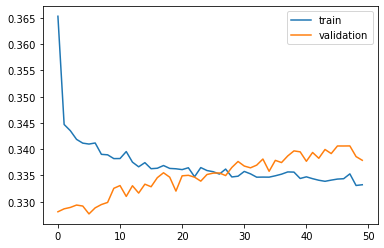

#################################
Number of units: 4
Batch size: 32
Fold: 0
best val loss: 0.32768370072046915
#################################
Time to train MLP:  313.56529211997986
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 6s - loss: 0.3787 - acc: 0.8682 - val_loss: 0.3439 - val_acc: 0.8713

Epoch 00001: val_loss improved from inf to 0.34394, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3482 - acc: 0.8726 - val_loss: 0.3413 - val_acc: 0.8713

Epoch 00002: val_loss improved from 0.34394 to 0.34133, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3420 - acc: 0.8727 - val_loss: 0.3371 - val_acc: 0.8713

Epoch 00003: val_loss improved from 0.34133 to 0.33709, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3404 - acc: 0.8727 - val_loss: 0.3375 - val_acc: 0.8713

Epoch 00004: val_loss did not improve from 0.33709
Epoch 5/50
 - 6s - loss: 0.3389 - acc: 0.8727 - val_loss: 0.3363 - val_acc: 0.8713

Epoch 00005: val_loss

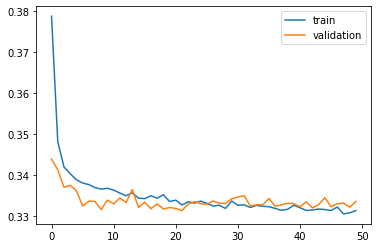

#################################
Number of units: 4
Batch size: 32
Fold: 1
best val loss: 0.33139434072706436
#################################
Time to train MLP:  325.7752299308777
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 7s - loss: 0.3821 - acc: 0.8676 - val_loss: 0.3383 - val_acc: 0.8710

Epoch 00001: val_loss improved from inf to 0.33831, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3424 - acc: 0.8743 - val_loss: 0.3275 - val_acc: 0.8747

Epoch 00002: val_loss improved from 0.33831 to 0.32746, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3382 - acc: 0.8753 - val_loss: 0.3282 - val_acc: 0.8740

Epoch 00003: val_loss did not improve from 0.32746
Epoch 4/50
 - 7s - loss: 0.3377 - acc: 0.8756 - val_loss: 0.3283 - val_acc: 0.8734

Epoch 00004: val_loss did not improve from 0.32746
Epoch 5/50
 - 7s - loss: 0.3359 - acc: 0.8758 - val_loss: 0.3288 - val_acc: 0.8740

Epoch 00005: val_loss did not improve from 0.32746
Epoch 6/50
 -

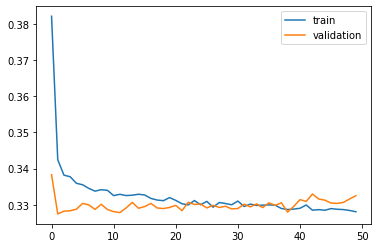

#################################
Number of units: 4
Batch size: 32
Fold: 2
best val loss: 0.3274587009482914
#################################
Time to train MLP:  332.16988730430603
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 7s - loss: 0.4058 - acc: 0.8677 - val_loss: 0.3413 - val_acc: 0.8689

Epoch 00001: val_loss improved from inf to 0.34133, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3493 - acc: 0.8759 - val_loss: 0.3432 - val_acc: 0.8670

Epoch 00002: val_loss did not improve from 0.34133
Epoch 3/50
 - 7s - loss: 0.3456 - acc: 0.8764 - val_loss: 0.3391 - val_acc: 0.8679

Epoch 00003: val_loss improved from 0.34133 to 0.33914, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3411 - acc: 0.8764 - val_loss: 0.3372 - val_acc: 0.8684

Epoch 00004: val_loss improved from 0.33914 to 0.33721, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3416 - acc: 0.8768 - val_loss: 0.3348 - val_acc: 0.8687

Epoch 00005: val_loss 

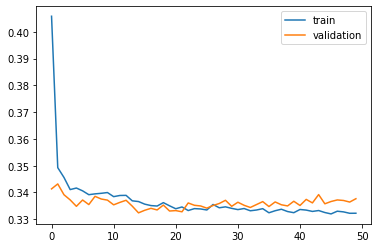

#################################
Number of units: 4
Batch size: 32
Fold: 3
best val loss: 0.3323778239356147
#################################
Time to train MLP:  334.52408599853516
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 7s - loss: 0.4230 - acc: 0.8617 - val_loss: 0.3296 - val_acc: 0.8743

Epoch 00001: val_loss improved from inf to 0.32956, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3431 - acc: 0.8745 - val_loss: 0.3259 - val_acc: 0.8773

Epoch 00002: val_loss improved from 0.32956 to 0.32594, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3412 - acc: 0.8750 - val_loss: 0.3235 - val_acc: 0.8771

Epoch 00003: val_loss improved from 0.32594 to 0.32353, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3395 - acc: 0.8753 - val_loss: 0.3244 - val_acc: 0.8756

Epoch 00004: val_loss did not improve from 0.32353
Epoch 5/50
 - 7s - loss: 0.3371 - acc: 0.8755 - val_loss: 0.3238 - val_acc: 0.8759

Epoch 00005: val_loss 

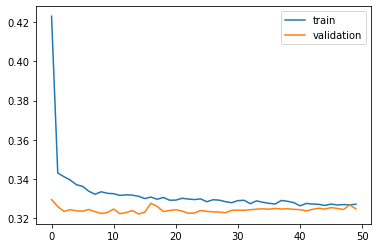

#################################
Number of units: 4
Batch size: 32
Fold: 4
best val loss: 0.3222410970396466
#################################
[[4, 32, 0, 0.32768370072046915], [4, 32, 1, 0.33139434072706436], [4, 32, 2, 0.3274587009482914], [4, 32, 3, 0.3323778239356147], [4, 32, 4, 0.3222410970396466]]
Time to train MLP:  336.9780647754669
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 8s - loss: 0.3823 - acc: 0.8659 - val_loss: 0.3317 - val_acc: 0.8769

Epoch 00001: val_loss improved from inf to 0.33166, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3366 - acc: 0.8744 - val_loss: 0.3253 - val_acc: 0.8786

Epoch 00002: val_loss improved from 0.33166 to 0.32526, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3339 - acc: 0.8750 - val_loss: 0.3208 - val_acc: 0.8796

Epoch 00003: val_loss improved from 0.32526 to 0.32080, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3300 - acc: 0.8759 - val_loss: 0.3218 - val_acc: 0.8

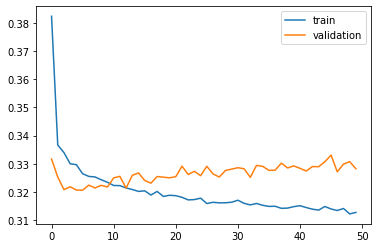

#################################
Number of units: 8
Batch size: 32
Fold: 0
best val loss: 0.32061696828736197
#################################
Time to train MLP:  338.6971971988678
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 8s - loss: 0.3945 - acc: 0.8654 - val_loss: 0.3351 - val_acc: 0.8739

Epoch 00001: val_loss improved from inf to 0.33514, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3426 - acc: 0.8748 - val_loss: 0.3299 - val_acc: 0.8740

Epoch 00002: val_loss improved from 0.33514 to 0.32991, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3363 - acc: 0.8748 - val_loss: 0.3262 - val_acc: 0.8753

Epoch 00003: val_loss improved from 0.32991 to 0.32617, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3343 - acc: 0.8753 - val_loss: 0.3266 - val_acc: 0.8738

Epoch 00004: val_loss did not improve from 0.32617
Epoch 5/50
 - 7s - loss: 0.3329 - acc: 0.8757 - val_loss: 0.3240 - val_acc: 0.8756

Epoch 00005: val_loss 

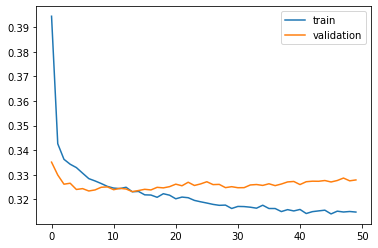

#################################
Number of units: 8
Batch size: 32
Fold: 1
best val loss: 0.3231385171413422
#################################
Time to train MLP:  341.3720443248749
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 8s - loss: 0.3604 - acc: 0.8694 - val_loss: 0.3289 - val_acc: 0.8731

Epoch 00001: val_loss improved from inf to 0.32892, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3318 - acc: 0.8751 - val_loss: 0.3287 - val_acc: 0.8750

Epoch 00002: val_loss improved from 0.32892 to 0.32875, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3294 - acc: 0.8756 - val_loss: 0.3263 - val_acc: 0.8766

Epoch 00003: val_loss improved from 0.32875 to 0.32632, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3280 - acc: 0.8756 - val_loss: 0.3250 - val_acc: 0.8759

Epoch 00004: val_loss improved from 0.32632 to 0.32503, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3267 - acc: 0.8762 - val_loss: 0.3315 

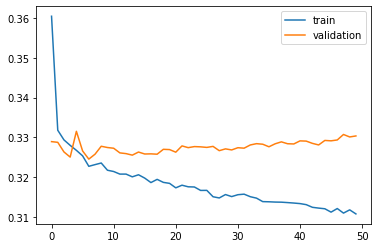

#################################
Number of units: 8
Batch size: 32
Fold: 2
best val loss: 0.32452617994944255
#################################
Time to train MLP:  343.06565856933594
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 8s - loss: 0.3581 - acc: 0.8688 - val_loss: 0.3330 - val_acc: 0.8666

Epoch 00001: val_loss improved from inf to 0.33297, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3330 - acc: 0.8757 - val_loss: 0.3309 - val_acc: 0.8694

Epoch 00002: val_loss improved from 0.33297 to 0.33092, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3296 - acc: 0.8755 - val_loss: 0.3271 - val_acc: 0.8710

Epoch 00003: val_loss improved from 0.33092 to 0.32710, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3276 - acc: 0.8764 - val_loss: 0.3269 - val_acc: 0.8701

Epoch 00004: val_loss improved from 0.32710 to 0.32695, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3267 - acc: 0.8766 - val_loss: 0.327

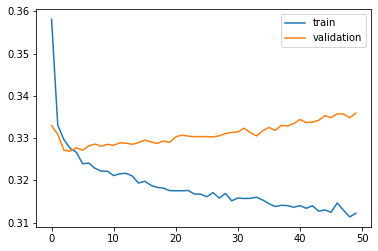

#################################
Number of units: 8
Batch size: 32
Fold: 3
best val loss: 0.3269455669456058
#################################
Time to train MLP:  343.2702782154083
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 9s - loss: 0.3585 - acc: 0.8711 - val_loss: 0.3249 - val_acc: 0.8753

Epoch 00001: val_loss improved from inf to 0.32491, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3323 - acc: 0.8755 - val_loss: 0.3234 - val_acc: 0.8770

Epoch 00002: val_loss improved from 0.32491 to 0.32337, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3311 - acc: 0.8752 - val_loss: 0.3237 - val_acc: 0.8763

Epoch 00003: val_loss did not improve from 0.32337
Epoch 4/50
 - 7s - loss: 0.3281 - acc: 0.8760 - val_loss: 0.3213 - val_acc: 0.8774

Epoch 00004: val_loss improved from 0.32337 to 0.32133, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3272 - acc: 0.8757 - val_loss: 0.3239 - val_acc: 0.8770

Epoch 00005: val_loss d

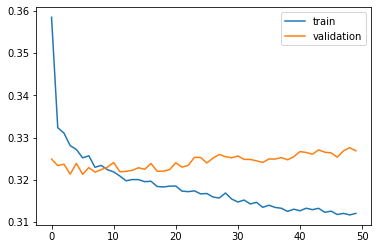

#################################
Number of units: 8
Batch size: 32
Fold: 4
best val loss: 0.321313190791342
#################################
[[4, 32, 0, 0.32768370072046915], [4, 32, 1, 0.33139434072706436], [4, 32, 2, 0.3274587009482914], [4, 32, 3, 0.3323778239356147], [4, 32, 4, 0.3222410970396466], [8, 32, 0, 0.32061696828736197], [8, 32, 1, 0.3231385171413422], [8, 32, 2, 0.32452617994944255], [8, 32, 3, 0.3269455669456058], [8, 32, 4, 0.321313190791342]]
Time to train MLP:  344.6223921775818
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 9s - loss: 0.3754 - acc: 0.8634 - val_loss: 0.3245 - val_acc: 0.8777

Epoch 00001: val_loss improved from inf to 0.32451, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3311 - acc: 0.8759 - val_loss: 0.3183 - val_acc: 0.8781

Epoch 00002: val_loss improved from 0.32451 to 0.31827, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3267 - acc: 0.8761 - val_loss: 0.3169 - val_acc: 0.8811

Epoch 00003:

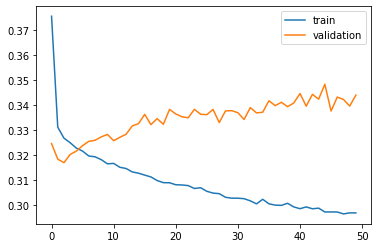

#################################
Number of units: 16
Batch size: 32
Fold: 0
best val loss: 0.31686443588468766
#################################
Time to train MLP:  349.3675012588501
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 9s - loss: 0.3797 - acc: 0.8661 - val_loss: 0.3326 - val_acc: 0.8736

Epoch 00001: val_loss improved from inf to 0.33260, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3307 - acc: 0.8753 - val_loss: 0.3275 - val_acc: 0.8752

Epoch 00002: val_loss improved from 0.33260 to 0.32752, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3270 - acc: 0.8760 - val_loss: 0.3267 - val_acc: 0.8751

Epoch 00003: val_loss improved from 0.32752 to 0.32673, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3253 - acc: 0.8768 - val_loss: 0.3241 - val_acc: 0.8756

Epoch 00004: val_loss improved from 0.32673 to 0.32406, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3227 - acc: 0.8773 - val_loss: 0.324

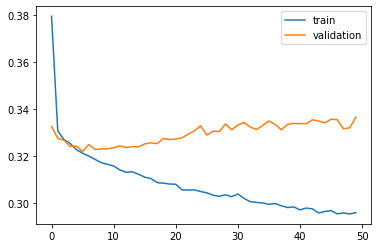

#################################
Number of units: 16
Batch size: 32
Fold: 1
best val loss: 0.32194148360358343
#################################
Time to train MLP:  350.61125469207764
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 9s - loss: 0.3722 - acc: 0.8682 - val_loss: 0.3335 - val_acc: 0.8734

Epoch 00001: val_loss improved from inf to 0.33354, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3323 - acc: 0.8745 - val_loss: 0.3270 - val_acc: 0.8750

Epoch 00002: val_loss improved from 0.33354 to 0.32704, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3263 - acc: 0.8763 - val_loss: 0.3291 - val_acc: 0.8767

Epoch 00003: val_loss did not improve from 0.32704
Epoch 4/50
 - 7s - loss: 0.3245 - acc: 0.8766 - val_loss: 0.3275 - val_acc: 0.8757

Epoch 00004: val_loss did not improve from 0.32704
Epoch 5/50
 - 7s - loss: 0.3222 - acc: 0.8766 - val_loss: 0.3281 - val_acc: 0.8747

Epoch 00005: val_loss did not improve from 0.32704
Epoch 6/50


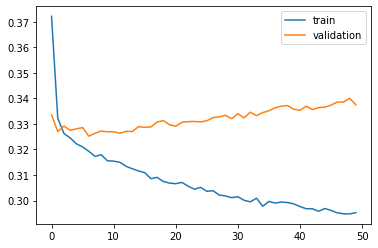

#################################
Number of units: 16
Batch size: 32
Fold: 2
best val loss: 0.32521333972613015
#################################
Time to train MLP:  353.0956883430481
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 9s - loss: 0.3560 - acc: 0.8696 - val_loss: 0.3306 - val_acc: 0.8698

Epoch 00001: val_loss improved from inf to 0.33056, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3294 - acc: 0.8761 - val_loss: 0.3288 - val_acc: 0.8704

Epoch 00002: val_loss improved from 0.33056 to 0.32877, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3270 - acc: 0.8765 - val_loss: 0.3291 - val_acc: 0.8702

Epoch 00003: val_loss did not improve from 0.32877
Epoch 4/50
 - 7s - loss: 0.3244 - acc: 0.8773 - val_loss: 0.3288 - val_acc: 0.8697

Epoch 00004: val_loss did not improve from 0.32877
Epoch 5/50
 - 7s - loss: 0.3230 - acc: 0.8775 - val_loss: 0.3296 - val_acc: 0.8699

Epoch 00005: val_loss did not improve from 0.32877
Epoch 6/50
 

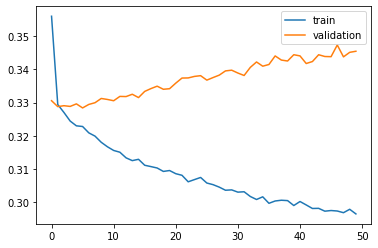

#################################
Number of units: 16
Batch size: 32
Fold: 3
best val loss: 0.32838223348723516
#################################
Time to train MLP:  355.0348656177521
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 12s - loss: 0.3621 - acc: 0.8699 - val_loss: 0.3240 - val_acc: 0.8751

Epoch 00001: val_loss improved from inf to 0.32402, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3306 - acc: 0.8754 - val_loss: 0.3214 - val_acc: 0.8782

Epoch 00002: val_loss improved from 0.32402 to 0.32138, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3257 - acc: 0.8758 - val_loss: 0.3217 - val_acc: 0.8768

Epoch 00003: val_loss did not improve from 0.32138
Epoch 4/50
 - 7s - loss: 0.3239 - acc: 0.8766 - val_loss: 0.3202 - val_acc: 0.8786

Epoch 00004: val_loss improved from 0.32138 to 0.32024, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3220 - acc: 0.8769 - val_loss: 0.3188 - val_acc: 0.8791

Epoch 00005: val_los

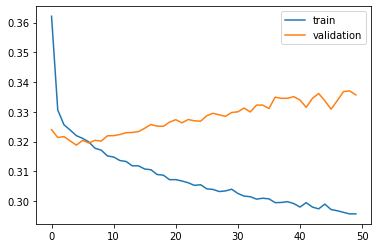

#################################
Number of units: 16
Batch size: 32
Fold: 4
best val loss: 0.31882082149717544
#################################
[[4, 32, 0, 0.32768370072046915], [4, 32, 1, 0.33139434072706436], [4, 32, 2, 0.3274587009482914], [4, 32, 3, 0.3323778239356147], [4, 32, 4, 0.3222410970396466], [8, 32, 0, 0.32061696828736197], [8, 32, 1, 0.3231385171413422], [8, 32, 2, 0.32452617994944255], [8, 32, 3, 0.3269455669456058], [8, 32, 4, 0.321313190791342], [16, 32, 0, 0.31686443588468766], [16, 32, 1, 0.32194148360358343], [16, 32, 2, 0.32521333972613015], [16, 32, 3, 0.32838223348723516], [16, 32, 4, 0.31882082149717544]]
Time to train MLP:  360.65966391563416
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 10s - loss: 0.3511 - acc: 0.8707 - val_loss: 0.3171 - val_acc: 0.8781

Epoch 00001: val_loss improved from inf to 0.31714, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3269 - acc: 0.8757 - val_loss: 0.3162 - val_acc: 0.8801

Epoch 00002: v

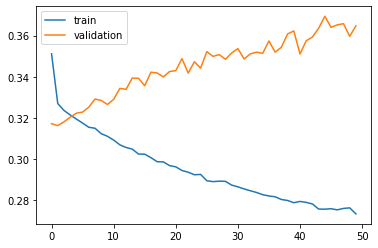

#################################
Number of units: 32
Batch size: 32
Fold: 0
best val loss: 0.31623594337039523
#################################
Time to train MLP:  362.5077335834503
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 11s - loss: 0.3647 - acc: 0.8695 - val_loss: 0.3277 - val_acc: 0.8746

Epoch 00001: val_loss improved from inf to 0.32772, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3279 - acc: 0.8764 - val_loss: 0.3238 - val_acc: 0.8758

Epoch 00002: val_loss improved from 0.32772 to 0.32379, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3236 - acc: 0.8767 - val_loss: 0.3247 - val_acc: 0.8749

Epoch 00003: val_loss did not improve from 0.32379
Epoch 4/50
 - 7s - loss: 0.3213 - acc: 0.8773 - val_loss: 0.3233 - val_acc: 0.8751

Epoch 00004: val_loss improved from 0.32379 to 0.32326, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3198 - acc: 0.8781 - val_loss: 0.3226 - val_acc: 0.8758

Epoch 00005: val_los

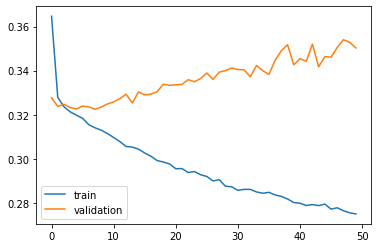

#################################
Number of units: 32
Batch size: 32
Fold: 1
best val loss: 0.32247198208173117
#################################
Time to train MLP:  364.419798374176
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 11s - loss: 0.3537 - acc: 0.8699 - val_loss: 0.3318 - val_acc: 0.8760

Epoch 00001: val_loss improved from inf to 0.33185, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3259 - acc: 0.8759 - val_loss: 0.3314 - val_acc: 0.8759

Epoch 00002: val_loss improved from 0.33185 to 0.33136, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3217 - acc: 0.8772 - val_loss: 0.3283 - val_acc: 0.8754

Epoch 00003: val_loss improved from 0.33136 to 0.32835, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3207 - acc: 0.8767 - val_loss: 0.3336 - val_acc: 0.8757

Epoch 00004: val_loss did not improve from 0.32835
Epoch 5/50
 - 7s - loss: 0.3197 - acc: 0.8779 - val_loss: 0.3290 - val_acc: 0.8768

Epoch 00005: val_loss

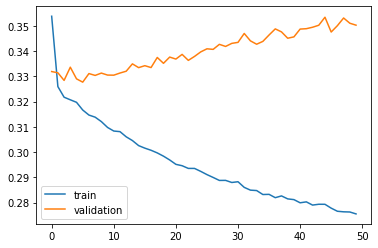

#################################
Number of units: 32
Batch size: 32
Fold: 2
best val loss: 0.3276571595933702
#################################
Time to train MLP:  364.5814368724823
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 11s - loss: 0.3516 - acc: 0.8722 - val_loss: 0.3294 - val_acc: 0.8706

Epoch 00001: val_loss improved from inf to 0.32944, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3251 - acc: 0.8763 - val_loss: 0.3280 - val_acc: 0.8704

Epoch 00002: val_loss improved from 0.32944 to 0.32801, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3222 - acc: 0.8772 - val_loss: 0.3279 - val_acc: 0.8714

Epoch 00003: val_loss improved from 0.32801 to 0.32792, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3203 - acc: 0.8781 - val_loss: 0.3263 - val_acc: 0.8709

Epoch 00004: val_loss improved from 0.32792 to 0.32630, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3172 - acc: 0.8791 - val_loss: 0.329

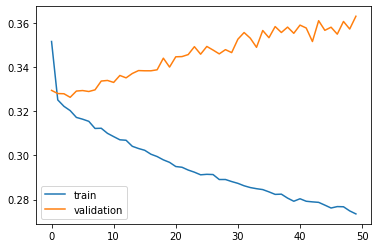

#################################
Number of units: 32
Batch size: 32
Fold: 3
best val loss: 0.32630023712582057
#################################
Time to train MLP:  368.22352266311646
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 11s - loss: 0.3636 - acc: 0.8684 - val_loss: 0.3232 - val_acc: 0.8777

Epoch 00001: val_loss improved from inf to 0.32322, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3266 - acc: 0.8754 - val_loss: 0.3203 - val_acc: 0.8768

Epoch 00002: val_loss improved from 0.32322 to 0.32029, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3229 - acc: 0.8765 - val_loss: 0.3197 - val_acc: 0.8771

Epoch 00003: val_loss improved from 0.32029 to 0.31968, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3209 - acc: 0.8777 - val_loss: 0.3193 - val_acc: 0.8781

Epoch 00004: val_loss improved from 0.31968 to 0.31934, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3186 - acc: 0.8785 - val_loss: 0.3

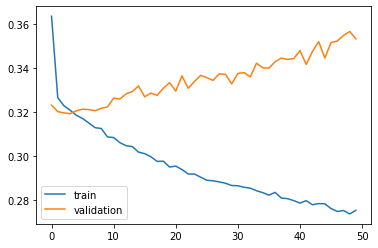

#################################
Number of units: 32
Batch size: 32
Fold: 4
best val loss: 0.3193443985250261
#################################
[[4, 32, 0, 0.32768370072046915], [4, 32, 1, 0.33139434072706436], [4, 32, 2, 0.3274587009482914], [4, 32, 3, 0.3323778239356147], [4, 32, 4, 0.3222410970396466], [8, 32, 0, 0.32061696828736197], [8, 32, 1, 0.3231385171413422], [8, 32, 2, 0.32452617994944255], [8, 32, 3, 0.3269455669456058], [8, 32, 4, 0.321313190791342], [16, 32, 0, 0.31686443588468766], [16, 32, 1, 0.32194148360358343], [16, 32, 2, 0.32521333972613015], [16, 32, 3, 0.32838223348723516], [16, 32, 4, 0.31882082149717544], [32, 32, 0, 0.31623594337039523], [32, 32, 1, 0.32247198208173117], [32, 32, 2, 0.3276571595933702], [32, 32, 3, 0.32630023712582057], [32, 32, 4, 0.3193443985250261]]
Time to train MLP:  370.6208050251007
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 11s - loss: 0.3503 - acc: 0.8713 - val_loss: 0.3165 - val_acc: 0.8806

Epoch 00001: val_loss

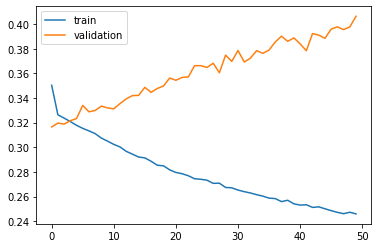

#################################
Number of units: 64
Batch size: 32
Fold: 0
best val loss: 0.31649187835057574
#################################
Time to train MLP:  371.4511811733246
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 11s - loss: 0.3525 - acc: 0.8704 - val_loss: 0.3277 - val_acc: 0.8748

Epoch 00001: val_loss improved from inf to 0.32771, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3253 - acc: 0.8762 - val_loss: 0.3240 - val_acc: 0.8758

Epoch 00002: val_loss improved from 0.32771 to 0.32404, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3222 - acc: 0.8776 - val_loss: 0.3251 - val_acc: 0.8760

Epoch 00003: val_loss did not improve from 0.32404
Epoch 4/50
 - 7s - loss: 0.3203 - acc: 0.8782 - val_loss: 0.3241 - val_acc: 0.8756

Epoch 00004: val_loss did not improve from 0.32404
Epoch 5/50
 - 7s - loss: 0.3171 - acc: 0.8794 - val_loss: 0.3248 - val_acc: 0.8733

Epoch 00005: val_loss did not improve from 0.32404
Epoch 6/50


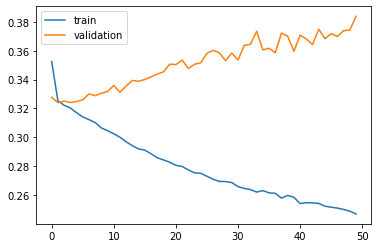

#################################
Number of units: 64
Batch size: 32
Fold: 1
best val loss: 0.3240358305242326
#################################
Time to train MLP:  375.6146011352539
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 13s - loss: 0.3551 - acc: 0.8692 - val_loss: 0.3369 - val_acc: 0.8751

Epoch 00001: val_loss improved from inf to 0.33687, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3255 - acc: 0.8762 - val_loss: 0.3304 - val_acc: 0.8769

Epoch 00002: val_loss improved from 0.33687 to 0.33040, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3214 - acc: 0.8772 - val_loss: 0.3317 - val_acc: 0.8759

Epoch 00003: val_loss did not improve from 0.33040
Epoch 4/50
 - 7s - loss: 0.3198 - acc: 0.8782 - val_loss: 0.3313 - val_acc: 0.8769

Epoch 00004: val_loss did not improve from 0.33040
Epoch 5/50
 - 7s - loss: 0.3174 - acc: 0.8792 - val_loss: 0.3307 - val_acc: 0.8769

Epoch 00005: val_loss did not improve from 0.33040
Epoch 6/50
 

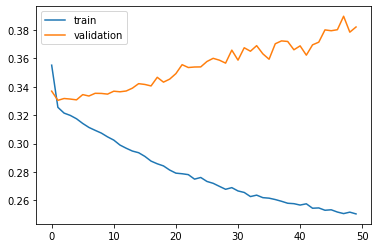

#################################
Number of units: 64
Batch size: 32
Fold: 2
best val loss: 0.33040384101867676
#################################
Time to train MLP:  378.80129075050354
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 12s - loss: 0.3593 - acc: 0.8699 - val_loss: 0.3303 - val_acc: 0.8714

Epoch 00001: val_loss improved from inf to 0.33031, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3250 - acc: 0.8765 - val_loss: 0.3302 - val_acc: 0.8716

Epoch 00002: val_loss improved from 0.33031 to 0.33016, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3216 - acc: 0.8777 - val_loss: 0.3295 - val_acc: 0.8717

Epoch 00003: val_loss improved from 0.33016 to 0.32952, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3186 - acc: 0.8786 - val_loss: 0.3286 - val_acc: 0.8714

Epoch 00004: val_loss improved from 0.32952 to 0.32863, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3174 - acc: 0.8797 - val_loss: 0.3

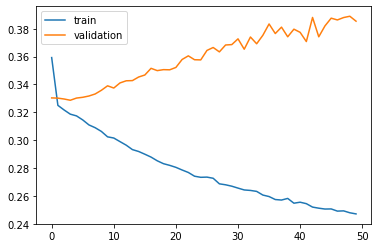

#################################
Number of units: 64
Batch size: 32
Fold: 3
best val loss: 0.3286325040128496
#################################
Time to train MLP:  379.07587814331055
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 12s - loss: 0.3480 - acc: 0.8708 - val_loss: 0.3227 - val_acc: 0.8758

Epoch 00001: val_loss improved from inf to 0.32272, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 8s - loss: 0.3258 - acc: 0.8754 - val_loss: 0.3210 - val_acc: 0.8781

Epoch 00002: val_loss improved from 0.32272 to 0.32101, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3227 - acc: 0.8764 - val_loss: 0.3216 - val_acc: 0.8786

Epoch 00003: val_loss did not improve from 0.32101
Epoch 4/50
 - 7s - loss: 0.3205 - acc: 0.8772 - val_loss: 0.3206 - val_acc: 0.8796

Epoch 00004: val_loss improved from 0.32101 to 0.32059, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 8s - loss: 0.3184 - acc: 0.8775 - val_loss: 0.3235 - val_acc: 0.8778

Epoch 00005: val_los

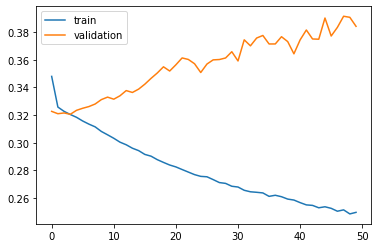

#################################
Number of units: 64
Batch size: 32
Fold: 4
best val loss: 0.32059426652060613
#################################
[[4, 32, 0, 0.32768370072046915], [4, 32, 1, 0.33139434072706436], [4, 32, 2, 0.3274587009482914], [4, 32, 3, 0.3323778239356147], [4, 32, 4, 0.3222410970396466], [8, 32, 0, 0.32061696828736197], [8, 32, 1, 0.3231385171413422], [8, 32, 2, 0.32452617994944255], [8, 32, 3, 0.3269455669456058], [8, 32, 4, 0.321313190791342], [16, 32, 0, 0.31686443588468766], [16, 32, 1, 0.32194148360358343], [16, 32, 2, 0.32521333972613015], [16, 32, 3, 0.32838223348723516], [16, 32, 4, 0.31882082149717544], [32, 32, 0, 0.31623594337039523], [32, 32, 1, 0.32247198208173117], [32, 32, 2, 0.3276571595933702], [32, 32, 3, 0.32630023712582057], [32, 32, 4, 0.3193443985250261], [64, 32, 0, 0.31649187835057574], [64, 32, 1, 0.3240358305242326], [64, 32, 2, 0.33040384101867676], [64, 32, 3, 0.3286325040128496], [64, 32, 4, 0.32059426652060613]]
Time to train MLP:  382.

In [14]:
from numpy.random import seed
seed(2)
from tensorflow import set_random_seed
set_random_seed(2)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units_list = [4,8,16,32,64]
batch_size_list = [32]#[64,128, 256, 512, 1024] # [8192]#[4096, 8192]#[2048] #[64, 128, 256, 512, 1024]# [512, 1024]# [1024] # [64, 128, 256, 512, 1024]

start_time = time.time()

exp_record = []

for n_units in units_list:
    for b_size in batch_size_list:
        for f in range(5):#10
            #start = f*num_per_fold
            end = (f+1)*num_per_fold
            train1_x = x_train[:end, ]
            train2_x = x_train[end:, ]
            train_x_mlp = np.append(train2_x, train1_x, axis=0) #new obj
            train1_y = y_train[:end, ]
            train2_y = y_train[end:, ]
            train_y_mlp = np.append(train2_y, train1_y, axis=0)

            start_time_inner = time.time()
            with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
                model = set_up_model(n_units, 0.25, 0.25)
                v_loss = fit_model(model, train_x_mlp,
                                   train_y_mlp, b_size)
                print("#################################")
                print("Number of units:", n_units)
                print("Batch size:", b_size)
                print("Fold:", f)
                print("best val loss:", v_loss)
                exp_record.append([n_units, b_size, f, v_loss])
                print("#################################")
            if (f==4):
                print(exp_record)
            end_time = time.time()
            print("Time to train MLP: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [19]:
n_units = 64
model = Sequential()
model.add(Dense(n_units, activation='relu', 
                    #kernel_regularizer=regularizers.l2(0.01),
                    input_shape=(1449, ))) #1457
model.add(Dropout(0.25))
model.add(Dense(n_units, activation='relu'))
                    #kernel_regularizer=regularizers.l2(0.01)))
    #model.add(Dropout(0.3))
    #model.add(Dense(512, activation='relu'))
                   #kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax')) #20
                   #kernel_regularizer=regularizers.l2(0.01)))
    #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-4)  #1e-4
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_388 (Dense)            (None, 64)                92800     
_________________________________________________________________
dropout_259 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_389 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_260 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_390 (Dense)            (None, 2)                 130       
Total params: 97,090
Trainable params: 97,090
Non-trainable params: 0
_________________________________________________________________


(5, 5)
(5, 5)
(5, 5)


<IPython.core.display.Javascript object>


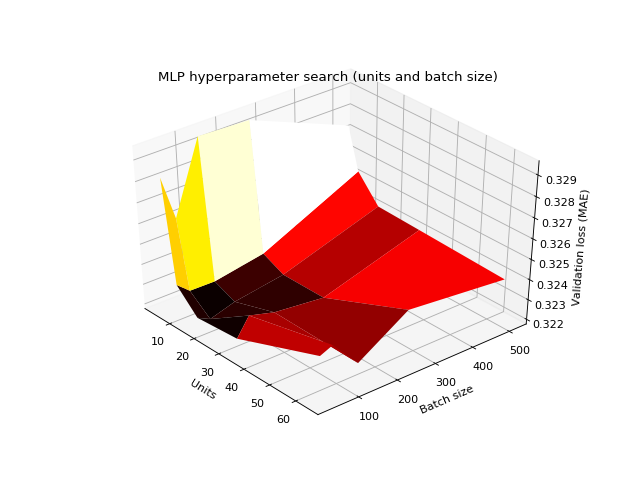

In [2]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d    
from mpl_toolkits import mplot3d
complete_list = [[0.32823, 0.32331, 0.32224, 0.32240, 0.32403],
                 [0.32607, 0.32277, 0.32192, 0.32331, 0.32430],
                 [0.32949, 0.32275, 0.32230, 0.32296, 0.32288],
                 [0.32939, 0.32319, 0.32269, 0.32269, 0.32447], 
                 [0.32746, 0.32547, 0.32425, 0.32416, 0.32397]]
x = np.array([4,8,16,32,64])
y = np.array([32,64,128,256,512])
X,Y = np.meshgrid(x, y)
z = np.array(complete_list)
print(X.shape)
print(Y.shape)
print(z.shape)
fig = pyplot.figure(figsize=(8, 6))
ax = pyplot.axes(projection='3d')
#ax.plot_surface(X, Y, z,cmap='viridis', edgecolor='none')
#ax.plot_wireframe(X, Y, z, color='g')
ax.set_xlabel('Units')
ax.set_ylabel('Batch size')
ax.set_zlabel('Validation loss (MAE)')
#ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, z, rstride=1, cstride=1,
                cmap='hot', edgecolor='none')
ax.set_title('MLP hyperparameter search (units and batch size)')
pyplot.show()

In [15]:
#exp_record = [[4, 64, 0, 0.3266700438923306], [4, 64, 1, 0.3240548405647278], [4, 64, 2, 0.3257799710167779], [4, 64, 3, 0.3317419354650709], [4, 64, 4, 0.3220915339257982], [4, 128, 0, 0.32752247619628905], [4, 128, 1, 0.32181496522161696], [4, 128, 2, 0.3350912875334422], [4, 128, 3, 0.34264717586835225], [4, 128, 4, 0.32037311283747355], [4, 256, 0, 0.3231688128842248], [4, 256, 1, 0.3215089569091797], [4, 256, 2, 0.33398351918326485], [4, 256, 3, 0.3371962758170234], [4, 256, 4, 0.33108973717689516], [4, 512, 0, 0.3219696685738034], [4, 512, 1, 0.330447577741411], [4, 512, 2, 0.33251232110129464], [4, 512, 3, 0.33032426773177254], [4, 512, 4, 0.3220512608687083], [4, 1024, 0, 0.31685965723461573], [4, 1024, 1, 0.322473601659139], [4, 1024, 2, 0.33016131546762256], [4, 1024, 3, 0.33412592482566833], [4, 1024, 4, 0.33178777114550273], [8, 64, 0, 0.3178424241807726], [8, 64, 1, 0.32375030268563165], [8, 64, 2, 0.3246675572130415], [8, 64, 3, 0.32864707475238375], [8, 64, 4, 0.31895668183432685], [8, 128, 0, 0.3186635559929742], [8, 128, 1, 0.3235352921485901], [8, 128, 2, 0.3244523493978712], [8, 128, 3, 0.32720482585165234], [8, 128, 4, 0.3198952035109202], [8, 256, 0, 0.3202793412208557], [8, 256, 1, 0.32290662423769634], [8, 256, 2, 0.32432157707214354], [8, 256, 3, 0.326682693084081], [8, 256, 4, 0.3217599381605784], [8, 512, 0, 0.32258718546231585], [8, 512, 1, 0.32402462805642024], [8, 512, 2, 0.32625704344113665], [8, 512, 3, 0.329017036014133], [8, 512, 4, 0.32544313695695665], [8, 1024, 0, 0.32059088362587823], [8, 1024, 1, 0.32204232716560366], [8, 1024, 2, 0.3328563615216149], [8, 1024, 3, 0.3317985061804454], [8, 1024, 4, 0.31980696066220604], [16, 64, 0, 0.31744422883457607], [16, 64, 1, 0.32179320610894097], [16, 64, 2, 0.32453742843204075], [16, 64, 3, 0.326901283370124], [16, 64, 4, 0.3189332647588518], [16, 128, 0, 0.3169396169980367], [16, 128, 1, 0.3229637423621284], [16, 128, 2, 0.32415719813770716], [16, 128, 3, 0.32680018332269456], [16, 128, 4, 0.3206610485712687], [16, 256, 0, 0.3172673535082075], [16, 256, 1, 0.32359535320599875], [16, 256, 2, 0.3251089953581492], [16, 256, 3, 0.3270960971249474], [16, 256, 4, 0.3203799919022454], [16, 512, 0, 0.320312852329678], [16, 512, 1, 0.3223737902906206], [16, 512, 2, 0.3250153042210473], [16, 512, 3, 0.3320775859091017], [16, 512, 4, 0.32147054227193195], [16, 1024, 0, 0.31765887451171876], [16, 1024, 1, 0.3230659832424588], [16, 1024, 2, 0.32981438170539007], [16, 1024, 3, 0.3294092066552904], [16, 1024, 4, 0.3193464167912801], [32, 64, 0, 0.3212367130385505], [32, 64, 1, 0.32328241692648996], [32, 64, 2, 0.3255665629174974], [32, 64, 3, 0.3271753168635898], [32, 64, 4, 0.3192900270885891], [32, 128, 0, 0.3191352994441986], [32, 128, 1, 0.324608055724038], [32, 128, 2, 0.3250632967154185], [32, 128, 3, 0.32698519044452246], [32, 128, 4, 0.31903156730863785], [32, 256, 0, 0.31707582897610137], [32, 256, 1, 0.3234467459519704], [32, 256, 2, 0.3249719353251987], [32, 256, 3, 0.3265922912756602], [32, 256, 4, 0.3213777479860518], [32, 512, 0, 0.31913117000791763], [32, 512, 1, 0.323333172665702], [32, 512, 2, 0.3270779701603784], [32, 512, 3, 0.3287989206578996], [32, 512, 4, 0.3224529347419739], [32, 1024, 0, 0.3180549185540941], [32, 1024, 1, 0.3250652750068241], [32, 1024, 2, 0.32806849037276375], [32, 1024, 3, 0.32890396200286015], [32, 1024, 4, 0.3209215846856435], [64, 64, 0, 0.3219102184507582], [64, 64, 1, 0.3243794186645084], [64, 64, 2, 0.3273755672772725], [64, 64, 3, 0.32745531164275277], [64, 64, 4, 0.3203586685922411], [64, 128, 0, 0.31736065379778544], [64, 128, 1, 0.32496516129705644], [64, 128, 2, 0.3242476808494992], [64, 128, 3, 0.327097564458847], [64, 128, 4, 0.320707249350018], [64, 256, 0, 0.32005361972914803], [64, 256, 1, 0.3241642544004652], [64, 256, 2, 0.3298074729177687], [64, 256, 3, 0.3280014406045278], [64, 256, 4, 0.3203255464235942], [64, 512, 0, 0.3185651894145542], [64, 512, 1, 0.3262670384777917], [64, 512, 2, 0.32672311777538726], [64, 512, 3, 0.32784048589070636], [64, 512, 4, 0.32046279403898453], [64, 1024, 0, 0.3207838879161411], [64, 1024, 1, 0.3247125679651896], [64, 1024, 2, 0.3286522008842892], [64, 1024, 3, 0.33038918979962667], [64, 1024, 4, 0.320843422598309]]

complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(25):
    h_params = complete_v[(i*5):((i+1)*5), :]
    print("###############################")
    print("Units:", h_params[0, 0])
    print("Batch size:", h_params[0, 1])
    #print("Val loss (mean):", np.mean(h_params[:, 3]))
    #print("Val loss (std):", np.std(h_params[:, 3]))
    print("Val loss (mean):", 
          np.round(np.mean(h_params[:, 3]), decimals=5))
    print("Val loss (std):", 
          np.round(np.std(h_params[:, 3]), decimals=5))
    print("###############################")
    val_loss_list.append(np.mean(h_params[:, 3]))
print(min(val_loss_list))

(25, 4)
###############################
Units: 4.0
Batch size: 32.0
Val loss (mean): 0.32823
Val loss (std): 0.00358
###############################
###############################
Units: 8.0
Batch size: 32.0
Val loss (mean): 0.32331
Val loss (std): 0.00228
###############################
###############################
Units: 16.0
Batch size: 32.0
Val loss (mean): 0.32224
Val loss (std): 0.00418
###############################
###############################
Units: 32.0
Batch size: 32.0
Val loss (mean): 0.3224
Val loss (std): 0.00425
###############################
###############################
Units: 64.0
Batch size: 32.0
Val loss (mean): 0.32403
Val loss (std): 0.00511
###############################
0.3222444628397624


In [12]:
###########################
# generate random numbers
# for dropout rate
###########################
from numpy.random import seed
seed(12)
# dropout rate for 1st dropout
# layer (between 0.0 and 0.5)
# seed 12 for EVENT 
dropout_rate_1_list = []
for i in range(25):
    dropout_rate_1_list.append(np.random.uniform(0.0, 0.5))
# dropout rate for 2nd dropout
# layer (between 0.0 and 0.5)
dropout_rate_2_list = []
for i in range(25):
    dropout_rate_2_list.append(np.random.uniform(0.0, 0.5))
print(min(dropout_rate_1_list))
print(max(dropout_rate_1_list))
print(min(dropout_rate_2_list))
print(max(dropout_rate_2_list))
print(dropout_rate_1_list)
print(dropout_rate_2_list)

0.0011296167592567685
0.4784746681375584
0.01758413073540238
0.49756908016927925
[0.07708142118983619, 0.3700248482577024, 0.13165750759256734, 0.26686969669014887, 0.007287481242709837, 0.4593735040499425, 0.4503574270585061, 0.016710713813172295, 0.4784746681375584, 0.06860466067803822, 0.14191417647897292, 0.30304159217941445, 0.4721125680265211, 0.4263677705546425, 0.0011296167592567685, 0.26061301361014644, 0.2760188166322833, 0.24268870683135485, 0.38406707703221116, 0.08035837656278505, 0.3822802251694394, 0.010404898976033083, 0.06760508918455843, 0.05813650870084491, 0.15494879224501462]
[0.3357263226060013, 0.23561488912500705, 0.40808414902301343, 0.14479339176527678, 0.3665629888063353, 0.35131117762762315, 0.16378473813171152, 0.1673237645530279, 0.48902903950825943, 0.3122910558676762, 0.4751567623497627, 0.38373782531024436, 0.41250462660738674, 0.20332015090333083, 0.22565420571065714, 0.20031581368083679, 0.49756908016927925, 0.08878208796894466, 0.48129845151392514, 0

9000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 4s - loss: 0.3532 - acc: 0.8702 - val_loss: 0.3181 - val_acc: 0.8772

Epoch 00001: val_loss improved from inf to 0.31813, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3267 - acc: 0.8748 - val_loss: 0.3173 - val_acc: 0.8799

Epoch 00002: val_loss improved from 0.31813 to 0.31732, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 3s - loss: 0.3224 - acc: 0.8764 - val_loss: 0.3186 - val_acc: 0.8802

Epoch 00003: val_loss did not improve from 0.31732
Epoch 4/50
 - 4s - loss: 0.3197 - acc: 0.8775 - val_loss: 0.3198 - val_acc: 0.8817

Epoch 00004: val_loss did not improve from 0.31732
Epoch 5/50
 - 3s - loss: 0.3173 - acc: 0.8782 - val_loss: 0.3207 - val_acc: 0.8814

Epoch 0

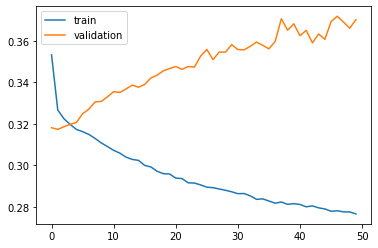

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.07708142118983619
Dropout rate 2: 0.3357263226060013
Fold: 0
Best val loss: 0.3173180478678809
#################################
Time to train MLP:  176.34639692306519
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 4s - loss: 0.3603 - acc: 0.8663 - val_loss: 0.3269 - val_acc: 0.8753

Epoch 00001: val_loss improved from inf to 0.32694, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 3s - loss: 0.3284 - acc: 0.8758 - val_loss: 0.3229 - val_acc: 0.8754

Epoch 00002: val_loss improved from 0.32694 to 0.32288, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3225 - acc: 0.8780 - val_loss: 0.3225 - val_acc: 0.8750

Epoch 00003: val_loss improved from 0.32288 to 0.32249, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3204 - acc: 0.8780 - val_loss: 0.3226 - val_acc: 0.8758

Epoch 00004: val_loss did not improve from 0.32249
Epoch 5/50
 - 4s - loss: 0.3185 - 

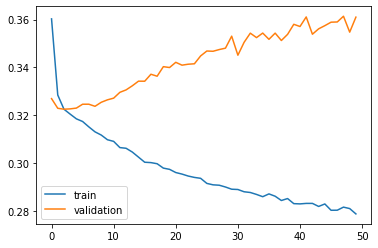

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.07708142118983619
Dropout rate 2: 0.3357263226060013
Fold: 1
Best val loss: 0.3224948298666212
#################################
Time to train MLP:  177.19350457191467
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 4s - loss: 0.3631 - acc: 0.8658 - val_loss: 0.3283 - val_acc: 0.8739

Epoch 00001: val_loss improved from inf to 0.32834, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3294 - acc: 0.8747 - val_loss: 0.3275 - val_acc: 0.8753

Epoch 00002: val_loss improved from 0.32834 to 0.32754, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3250 - acc: 0.8764 - val_loss: 0.3299 - val_acc: 0.8759

Epoch 00003: val_loss did not improve from 0.32754
Epoch 4/50
 - 4s - loss: 0.3219 - acc: 0.8773 - val_loss: 0.3311 - val_acc: 0.8753

Epoch 00004: val_loss did not improve from 0.32754
Epoch 5/50
 - 4s - loss: 0.3204 - acc: 0.8769 - val_loss: 0.3286 - val_acc: 

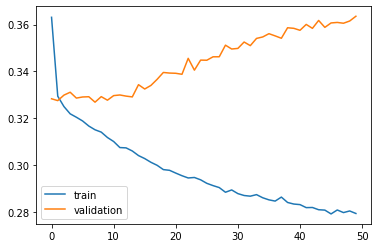

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.07708142118983619
Dropout rate 2: 0.3357263226060013
Fold: 2
Best val loss: 0.3268813591533237
#################################
Time to train MLP:  177.564129114151
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 4s - loss: 0.3655 - acc: 0.8667 - val_loss: 0.3304 - val_acc: 0.8691

Epoch 00001: val_loss improved from inf to 0.33036, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3293 - acc: 0.8765 - val_loss: 0.3284 - val_acc: 0.8692

Epoch 00002: val_loss improved from 0.33036 to 0.32841, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3242 - acc: 0.8778 - val_loss: 0.3271 - val_acc: 0.8707

Epoch 00003: val_loss improved from 0.32841 to 0.32710, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3210 - acc: 0.8787 - val_loss: 0.3260 - val_acc: 0.8710

Epoch 00004: val_loss improved from 0.32710 to 0.32604, saving model to MLP_val_weights

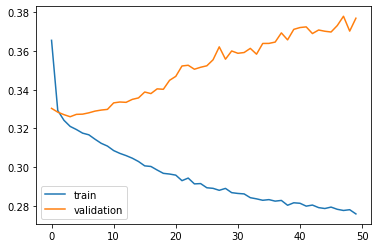

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.07708142118983619
Dropout rate 2: 0.3357263226060013
Fold: 3
Best val loss: 0.3260361191696591
#################################
Time to train MLP:  180.41310834884644
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 4s - loss: 0.3696 - acc: 0.8614 - val_loss: 0.3226 - val_acc: 0.8781

Epoch 00001: val_loss improved from inf to 0.32258, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3279 - acc: 0.8761 - val_loss: 0.3211 - val_acc: 0.8773

Epoch 00002: val_loss improved from 0.32258 to 0.32105, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3235 - acc: 0.8762 - val_loss: 0.3194 - val_acc: 0.8770

Epoch 00003: val_loss improved from 0.32105 to 0.31945, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3203 - acc: 0.8777 - val_loss: 0.3202 - val_acc: 0.8779

Epoch 00004: val_loss did not improve from 0.31945
Epoch 5/50
 - 4s - loss: 0.3192 - 

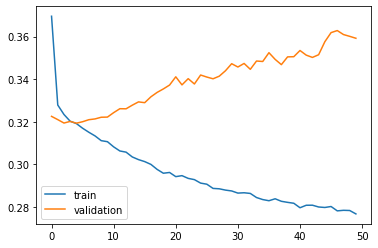

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.07708142118983619
Dropout rate 2: 0.3357263226060013
Fold: 4
Best val loss: 0.3193798927201165
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165]]
Time to train MLP:  180.85294699668884
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 4s - loss: 0.3853 - acc: 0.8625 - val_loss: 0.3311 - val_acc: 0.8767

Epoch 00001: val_loss improved from inf to 0.33111, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3404 - acc: 0.8736 - val_loss: 0.3235 - val_acc: 0.8774

Epoch 00002: val_loss improved from 0.33111 to 0.32351, saving model

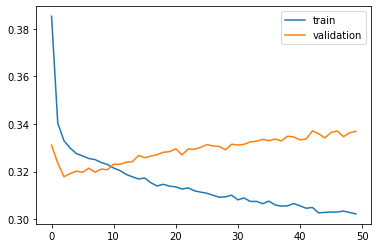

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.3700248482577024
Dropout rate 2: 0.23561488912500705
Fold: 0
Best val loss: 0.3178065161969927
#################################
Time to train MLP:  182.93943405151367
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 5s - loss: 0.3877 - acc: 0.8587 - val_loss: 0.3369 - val_acc: 0.8724

Epoch 00001: val_loss improved from inf to 0.33687, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3349 - acc: 0.8752 - val_loss: 0.3309 - val_acc: 0.8758

Epoch 00002: val_loss improved from 0.33687 to 0.33086, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3286 - acc: 0.8765 - val_loss: 0.3270 - val_acc: 0.8754

Epoch 00003: val_loss improved from 0.33086 to 0.32703, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3254 - acc: 0.8764 - val_loss: 0.3247 - val_acc: 0.8752

Epoch 00004: val_loss improved from 0.32703 to 0.32467, saving model to MLP_val_weigh

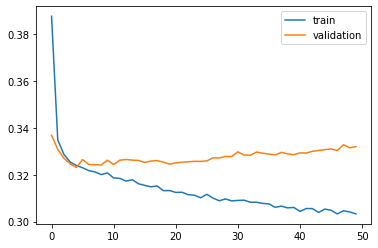

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.3700248482577024
Dropout rate 2: 0.23561488912500705
Fold: 1
Best val loss: 0.32310840423901876
#################################
Time to train MLP:  183.9874768257141
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 5s - loss: 0.3677 - acc: 0.8673 - val_loss: 0.3384 - val_acc: 0.8716

Epoch 00001: val_loss improved from inf to 0.33836, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3347 - acc: 0.8749 - val_loss: 0.3279 - val_acc: 0.8737

Epoch 00002: val_loss improved from 0.33836 to 0.32786, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3276 - acc: 0.8752 - val_loss: 0.3256 - val_acc: 0.8751

Epoch 00003: val_loss improved from 0.32786 to 0.32558, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3256 - acc: 0.8760 - val_loss: 0.3255 - val_acc: 0.8760

Epoch 00004: val_loss improved from 0.32558 to 0.32548, saving model to MLP_val_weigh

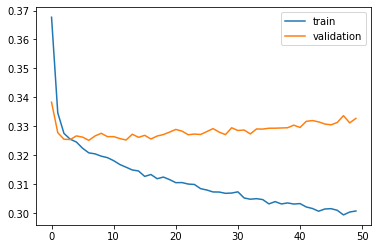

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.3700248482577024
Dropout rate 2: 0.23561488912500705
Fold: 2
Best val loss: 0.3251951296594408
#################################
Time to train MLP:  184.38060855865479
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 5s - loss: 0.3841 - acc: 0.8690 - val_loss: 0.3441 - val_acc: 0.8661

Epoch 00001: val_loss improved from inf to 0.34406, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3473 - acc: 0.8727 - val_loss: 0.3418 - val_acc: 0.8666

Epoch 00002: val_loss improved from 0.34406 to 0.34178, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3408 - acc: 0.8727 - val_loss: 0.3380 - val_acc: 0.8662

Epoch 00003: val_loss improved from 0.34178 to 0.33803, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3379 - acc: 0.8729 - val_loss: 0.3385 - val_acc: 0.8670

Epoch 00004: val_loss did not improve from 0.33803
Epoch 5/50
 - 4s - loss: 0.3344 - 

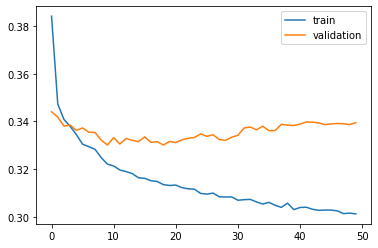

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.3700248482577024
Dropout rate 2: 0.23561488912500705
Fold: 3
Best val loss: 0.3300845676528083
#################################
Time to train MLP:  186.7663164138794
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 5s - loss: 0.3653 - acc: 0.8700 - val_loss: 0.3318 - val_acc: 0.8751

Epoch 00001: val_loss improved from inf to 0.33180, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3336 - acc: 0.8746 - val_loss: 0.3236 - val_acc: 0.8757

Epoch 00002: val_loss improved from 0.33180 to 0.32362, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3285 - acc: 0.8750 - val_loss: 0.3216 - val_acc: 0.8756

Epoch 00003: val_loss improved from 0.32362 to 0.32165, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3267 - acc: 0.8751 - val_loss: 0.3236 - val_acc: 0.8757

Epoch 00004: val_loss did not improve from 0.32165
Epoch 5/50
 - 4s - loss: 0.3246 - a

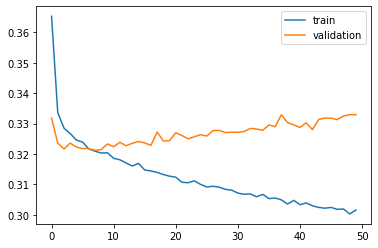

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.3700248482577024
Dropout rate 2: 0.23561488912500705
Fold: 4
Best val loss: 0.32121809917026095
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095]]
Time to train MLP:  187.96496176719666
T

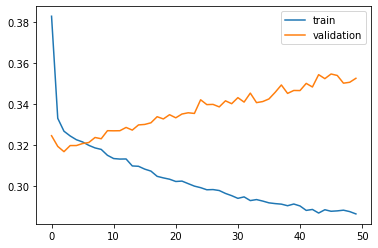

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.13165750759256734
Dropout rate 2: 0.40808414902301343
Fold: 0
Best val loss: 0.3169564678139157
#################################
Time to train MLP:  189.1783103942871


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f690052aef0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f69003d0da0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 6s - loss: 0.3732 - acc: 0.8670 - val_loss: 0.3287 - val_acc: 0.8733

Epoch 00001: val_loss improved from inf to 0.32867, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3330 - acc: 0.8750 - val_loss: 0.3254 - val_acc: 0.8756

Epoch 00002: val_loss improved from 0.32867 to 0.32543, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3284 - acc: 0.8752 - val_loss: 0.3239 - val_acc: 0.8753

Epoch 00003: val_loss improved from 0.32543 to 0.32388, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3255 - acc: 0.8766 - val_loss: 0.3234 - val_acc: 0.8748

Epoch 00004: val_loss improved from 0.32388 to 0.32343, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 4s - loss: 0.3237 - acc: 0.8763 - val_loss: 0.3246 - val_acc: 0.8760

Epoch 00005: val_loss did not improve from 0.32343
Epoch 6/50
 - 4s - loss: 0.3226 - acc: 0.8769 - val_loss: 0.3237 - val_acc: 0.8752

Epoch 00006: val_loss did no

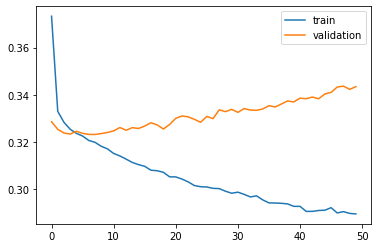

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.13165750759256734
Dropout rate 2: 0.40808414902301343
Fold: 1
Best val loss: 0.32326197327507866
#################################
Time to train MLP:  191.80907082557678
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 6s - loss: 0.3689 - acc: 0.8654 - val_loss: 0.3290 - val_acc: 0.8721

Epoch 00001: val_loss improved from inf to 0.32896, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3291 - acc: 0.8755 - val_loss: 0.3249 - val_acc: 0.8761

Epoch 00002: val_loss improved from 0.32896 to 0.32490, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3247 - acc: 0.8763 - val_loss: 0.3247 - val_acc: 0.8764

Epoch 00003: val_loss improved from 0.32490 to 0.32470, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3230 - acc: 0.8769 - val_loss: 0.3248 - val_acc: 0.8768

Epoch 00004: val_loss did not improve from 0.32470
Epoch 5/50
 - 4s - loss: 0.3189 

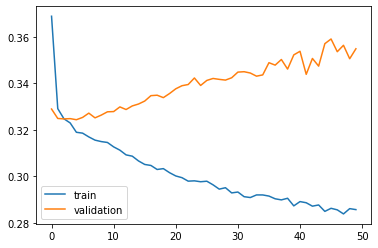

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.13165750759256734
Dropout rate 2: 0.40808414902301343
Fold: 2
Best val loss: 0.32435149918662176
#################################
Time to train MLP:  194.06528329849243
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 6s - loss: 0.3678 - acc: 0.8665 - val_loss: 0.3305 - val_acc: 0.8693

Epoch 00001: val_loss improved from inf to 0.33054, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3300 - acc: 0.8761 - val_loss: 0.3271 - val_acc: 0.8710

Epoch 00002: val_loss improved from 0.33054 to 0.32714, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3252 - acc: 0.8766 - val_loss: 0.3279 - val_acc: 0.8708

Epoch 00003: val_loss did not improve from 0.32714
Epoch 4/50
 - 4s - loss: 0.3226 - acc: 0.8773 - val_loss: 0.3278 - val_acc: 0.8708

Epoch 00004: val_loss did not improve from 0.32714
Epoch 5/50
 - 4s - loss: 0.3210 - acc: 0.8776 - val_loss: 0.3294 - val_acc

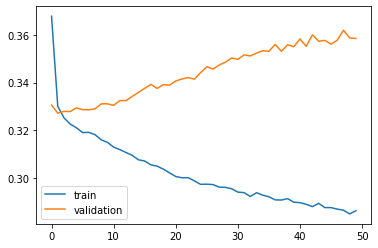

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.13165750759256734
Dropout rate 2: 0.40808414902301343
Fold: 3
Best val loss: 0.32713654653231306
#################################
Time to train MLP:  195.00912976264954
Train on 81000 samples, validate on 9000 samples
Epoch 1/50


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f68e0289e80>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f68e01acd68>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

 - 7s - loss: 0.3929 - acc: 0.8625 - val_loss: 0.3294 - val_acc: 0.8753

Epoch 00001: val_loss improved from inf to 0.32942, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3379 - acc: 0.8744 - val_loss: 0.3264 - val_acc: 0.8748

Epoch 00002: val_loss improved from 0.32942 to 0.32637, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3297 - acc: 0.8755 - val_loss: 0.3260 - val_acc: 0.8746

Epoch 00003: val_loss improved from 0.32637 to 0.32595, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3272 - acc: 0.8757 - val_loss: 0.3236 - val_acc: 0.8763

Epoch 00004: val_loss improved from 0.32595 to 0.32355, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 4s - loss: 0.3248 - acc: 0.8761 - val_loss: 0.3247 - val_acc: 0.8772

Epoch 00005: val_loss did not improve from 0.32355
Epoch 6/50
 - 4s - loss: 0.3231 - acc: 0.8770 - val_loss: 0.3221 - val_acc: 0.8784

Epoch 00006: val_loss improved from 0.32355 to 0.32207, saving model to MLP_val_weights.

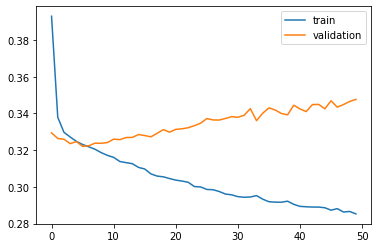

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.13165750759256734
Dropout rate 2: 0.40808414902301343
Fold: 4
Best val loss: 0.32206980954276193
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.4080841


Epoch 00049: val_loss did not improve from 0.31591
Epoch 50/50
 - 4s - loss: 0.2910 - acc: 0.8886 - val_loss: 0.3424 - val_acc: 0.8778

Epoch 00050: val_loss did not improve from 0.31591


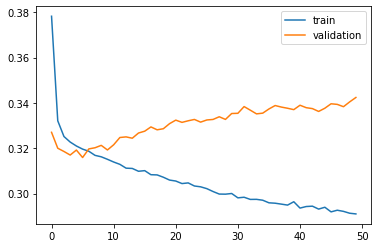

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.26686969669014887
Dropout rate 2: 0.14479339176527678
Fold: 0
Best val loss: 0.31591361411412555
#################################
Time to train MLP:  197.4272975921631
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 7s - loss: 0.3637 - acc: 0.8679 - val_loss: 0.3305 - val_acc: 0.8731

Epoch 00001: val_loss improved from inf to 0.33046, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3315 - acc: 0.8749 - val_loss: 0.3275 - val_acc: 0.8764

Epoch 00002: val_loss improved from 0.33046 to 0.32751, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3272 - acc: 0.8759 - val_loss: 0.3276 - val_acc: 0.8764

Epoch 00003: val_loss did not improve from 0.32751
Epoch 4/50
 - 4s - loss: 0.3239 - acc: 0.8765 - val_loss: 0.3269 - val_acc: 0.8758

Epoch 00004: val_loss improved from 0.32751 to 0.32693, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 4s - loss: 0.3217 -

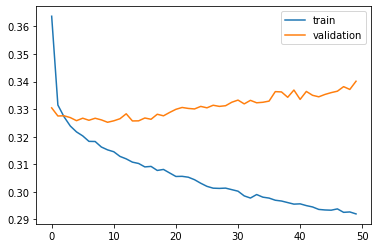

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.26686969669014887
Dropout rate 2: 0.14479339176527678
Fold: 1
Best val loss: 0.3252305828995175
#################################
Time to train MLP:  197.65111303329468
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 7s - loss: 0.3587 - acc: 0.8677 - val_loss: 0.3295 - val_acc: 0.8726

Epoch 00001: val_loss improved from inf to 0.32955, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3317 - acc: 0.8751 - val_loss: 0.3258 - val_acc: 0.8749

Epoch 00002: val_loss improved from 0.32955 to 0.32585, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3256 - acc: 0.8763 - val_loss: 0.3243 - val_acc: 0.8768

Epoch 00003: val_loss improved from 0.32585 to 0.32426, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3230 - acc: 0.8774 - val_loss: 0.3257 - val_acc: 0.8761

Epoch 00004: val_loss did not improve from 0.32426
Epoch 5/50
 - 4s - loss: 0.3209 -

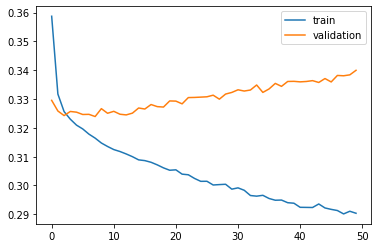

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.26686969669014887
Dropout rate 2: 0.14479339176527678
Fold: 2
Best val loss: 0.32392920337782966
#################################
Time to train MLP:  198.3206126689911
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 27s - loss: 0.3689 - acc: 0.8669 - val_loss: 0.3331 - val_acc: 0.8701

Epoch 00001: val_loss improved from inf to 0.33308, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3309 - acc: 0.8761 - val_loss: 0.3283 - val_acc: 0.8710

Epoch 00002: val_loss improved from 0.33308 to 0.32834, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3240 - acc: 0.8768 - val_loss: 0.3270 - val_acc: 0.8714

Epoch 00003: val_loss improved from 0.32834 to 0.32696, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3203 - acc: 0.8783 - val_loss: 0.3267 - val_acc: 0.8708

Epoch 00004: val_loss improved from 0.32696 to 0.32671, saving model to MLP_val_wei

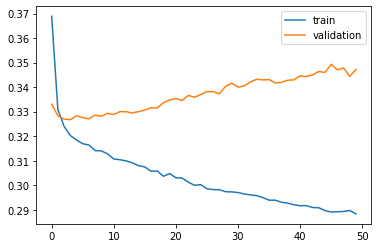

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.26686969669014887
Dropout rate 2: 0.14479339176527678
Fold: 3
Best val loss: 0.3267094491322835
#################################
Time to train MLP:  218.789710521698
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 7s - loss: 0.4109 - acc: 0.8510 - val_loss: 0.3330 - val_acc: 0.8760

Epoch 00001: val_loss improved from inf to 0.33297, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3376 - acc: 0.8744 - val_loss: 0.3244 - val_acc: 0.8773

Epoch 00002: val_loss improved from 0.33297 to 0.32439, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3281 - acc: 0.8762 - val_loss: 0.3223 - val_acc: 0.8763

Epoch 00003: val_loss improved from 0.32439 to 0.32233, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3241 - acc: 0.8763 - val_loss: 0.3226 - val_acc: 0.8768

Epoch 00004: val_loss did not improve from 0.32233
Epoch 5/50
 - 4s - loss: 0.3202 - a

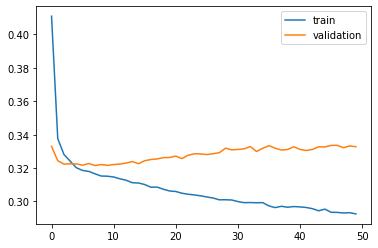

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.26686969669014887
Dropout rate 2: 0.14479339176527678
Fold: 4
Best val loss: 0.3215161043273078
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414


Epoch 00047: val_loss did not improve from 0.31590
Epoch 48/50
 - 4s - loss: 0.2711 - acc: 0.9000 - val_loss: 0.4137 - val_acc: 0.8752

Epoch 00048: val_loss did not improve from 0.31590
Epoch 49/50
 - 4s - loss: 0.2701 - acc: 0.9008 - val_loss: 0.4169 - val_acc: 0.8764

Epoch 00049: val_loss did not improve from 0.31590
Epoch 50/50
 - 4s - loss: 0.2694 - acc: 0.9016 - val_loss: 0.4132 - val_acc: 0.8743

Epoch 00050: val_loss did not improve from 0.31590


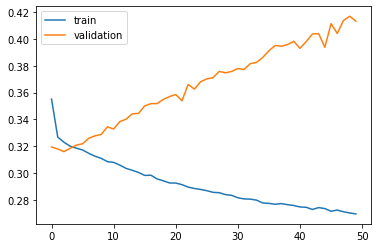

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.007287481242709837
Dropout rate 2: 0.3665629888063353
Fold: 0
Best val loss: 0.3158959857887692
#################################
Time to train MLP:  204.46659779548645
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 8s - loss: 0.3705 - acc: 0.8638 - val_loss: 0.3262 - val_acc: 0.8734

Epoch 00001: val_loss improved from inf to 0.32622, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3287 - acc: 0.8762 - val_loss: 0.3240 - val_acc: 0.8743

Epoch 00002: val_loss improved from 0.32622 to 0.32397, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3223 - acc: 0.8770 - val_loss: 0.3244 - val_acc: 0.8746

Epoch 00003: val_loss did not improve from 0.32397
Epoch 4/50
 - 4s - loss: 0.3204 - acc: 0.8774 - val_loss: 0.3244 - val_acc: 0.8746

Epoch 00004: val_loss did not improve from 0.32397
Epoch 5/50
 - 4s - loss: 0.3181 - acc: 0.8783 - val_loss: 0.3224 - val_acc:

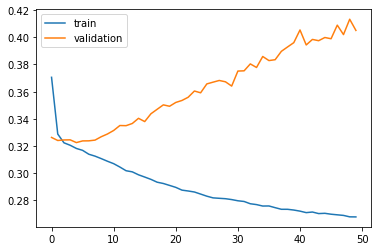

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.007287481242709837
Dropout rate 2: 0.3665629888063353
Fold: 1
Best val loss: 0.3224192425145043
#################################
Time to train MLP:  204.2810616493225
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 9s - loss: 0.3654 - acc: 0.8705 - val_loss: 0.3330 - val_acc: 0.8743

Epoch 00001: val_loss improved from inf to 0.33302, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3325 - acc: 0.8753 - val_loss: 0.3289 - val_acc: 0.8750

Epoch 00002: val_loss improved from 0.33302 to 0.32887, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3263 - acc: 0.8757 - val_loss: 0.3256 - val_acc: 0.8760

Epoch 00003: val_loss improved from 0.32887 to 0.32556, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3228 - acc: 0.8766 - val_loss: 0.3276 - val_acc: 0.8758

Epoch 00004: val_loss did not improve from 0.32556
Epoch 5/50
 - 4s - loss: 0.3209 - 

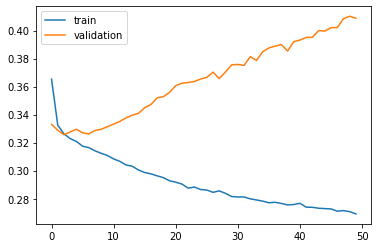

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.007287481242709837
Dropout rate 2: 0.3665629888063353
Fold: 2
Best val loss: 0.32556339184443156
#################################
Time to train MLP:  205.36570525169373
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 10s - loss: 0.3727 - acc: 0.8652 - val_loss: 0.3308 - val_acc: 0.8694

Epoch 00001: val_loss improved from inf to 0.33077, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3297 - acc: 0.8760 - val_loss: 0.3286 - val_acc: 0.8701

Epoch 00002: val_loss improved from 0.33077 to 0.32864, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3227 - acc: 0.8772 - val_loss: 0.3273 - val_acc: 0.8702

Epoch 00003: val_loss improved from 0.32864 to 0.32726, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3205 - acc: 0.8779 - val_loss: 0.3275 - val_acc: 0.8710

Epoch 00004: val_loss did not improve from 0.32726
Epoch 5/50
 - 4s - loss: 0.3184

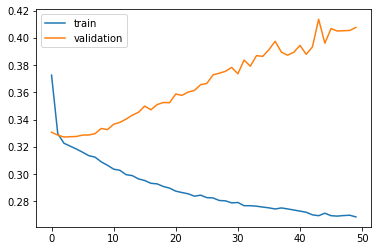

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.007287481242709837
Dropout rate 2: 0.3665629888063353
Fold: 3
Best val loss: 0.32725716524653964
#################################
Time to train MLP:  208.08152627944946
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 22s - loss: 0.3959 - acc: 0.8608 - val_loss: 0.3253 - val_acc: 0.8762

Epoch 00001: val_loss improved from inf to 0.32532, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3316 - acc: 0.8749 - val_loss: 0.3221 - val_acc: 0.8784

Epoch 00002: val_loss improved from 0.32532 to 0.32208, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3236 - acc: 0.8767 - val_loss: 0.3202 - val_acc: 0.8799

Epoch 00003: val_loss improved from 0.32208 to 0.32020, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3219 - acc: 0.8765 - val_loss: 0.3210 - val_acc: 0.8786

Epoch 00004: val_loss did not improve from 0.32020
Epoch 5/50
 - 4s - loss: 0.3200

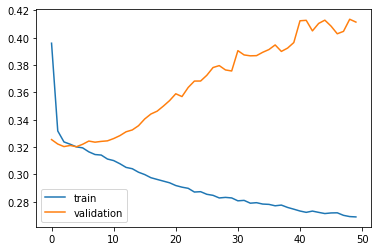

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.007287481242709837
Dropout rate 2: 0.3665629888063353
Fold: 4
Best val loss: 0.3200883808930715
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414

 - 4s - loss: 0.3129 - acc: 0.8786 - val_loss: 0.3299 - val_acc: 0.8790

Epoch 00044: val_loss did not improve from 0.31900
Epoch 45/50
 - 4s - loss: 0.3136 - acc: 0.8793 - val_loss: 0.3298 - val_acc: 0.8790

Epoch 00045: val_loss did not improve from 0.31900
Epoch 46/50
 - 4s - loss: 0.3131 - acc: 0.8801 - val_loss: 0.3311 - val_acc: 0.8790

Epoch 00046: val_loss did not improve from 0.31900
Epoch 47/50
 - 4s - loss: 0.3126 - acc: 0.8796 - val_loss: 0.3295 - val_acc: 0.8793

Epoch 00047: val_loss did not improve from 0.31900
Epoch 48/50
 - 4s - loss: 0.3129 - acc: 0.8800 - val_loss: 0.3293 - val_acc: 0.8797

Epoch 00048: val_loss did not improve from 0.31900
Epoch 49/50
 - 4s - loss: 0.3118 - acc: 0.8797 - val_loss: 0.3295 - val_acc: 0.8802

Epoch 00049: val_loss did not improve from 0.31900
Epoch 50/50
 - 4s - loss: 0.3120 - acc: 0.8800 - val_loss: 0.3307 - val_acc: 0.8787

Epoch 00050: val_loss did not improve from 0.31900


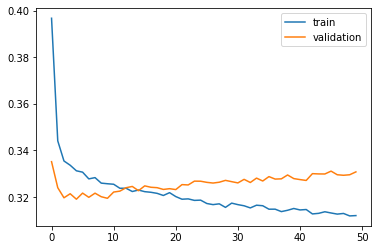

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4593735040499425
Dropout rate 2: 0.35131117762762315
Fold: 0
Best val loss: 0.3190029735300276
#################################
Time to train MLP:  210.96798372268677
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 12s - loss: 0.4111 - acc: 0.8536 - val_loss: 0.3336 - val_acc: 0.8717

Epoch 00001: val_loss improved from inf to 0.33358, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3422 - acc: 0.8738 - val_loss: 0.3279 - val_acc: 0.8724

Epoch 00002: val_loss improved from 0.33358 to 0.32788, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3352 - acc: 0.8747 - val_loss: 0.3278 - val_acc: 0.8730

Epoch 00003: val_loss improved from 0.32788 to 0.32785, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3321 - acc: 0.8750 - val_loss: 0.3263 - val_acc: 0.8719

Epoch 00004: val_loss improved from 0.32785 to 0.32634, saving model to MLP_val_weig

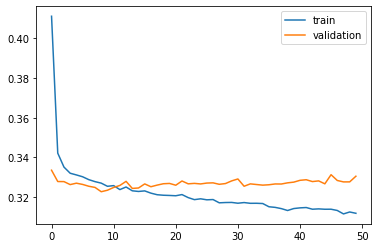

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4593735040499425
Dropout rate 2: 0.35131117762762315
Fold: 1
Best val loss: 0.3227528326246474
#################################
Time to train MLP:  216.49211764335632
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 12s - loss: 0.4172 - acc: 0.8539 - val_loss: 0.3400 - val_acc: 0.8709

Epoch 00001: val_loss improved from inf to 0.34005, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3448 - acc: 0.8733 - val_loss: 0.3332 - val_acc: 0.8710

Epoch 00002: val_loss improved from 0.34005 to 0.33317, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3350 - acc: 0.8743 - val_loss: 0.3326 - val_acc: 0.8714

Epoch 00003: val_loss improved from 0.33317 to 0.33256, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3310 - acc: 0.8757 - val_loss: 0.3286 - val_acc: 0.8724

Epoch 00004: val_loss improved from 0.33256 to 0.32861, saving model to MLP_val_weig

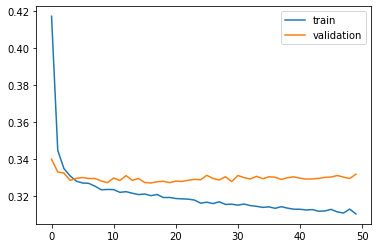

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4593735040499425
Dropout rate 2: 0.35131117762762315
Fold: 2
Best val loss: 0.32722796964645384
#################################
Time to train MLP:  215.5592770576477
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 12s - loss: 0.4095 - acc: 0.8610 - val_loss: 0.3414 - val_acc: 0.8678

Epoch 00001: val_loss improved from inf to 0.34135, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3447 - acc: 0.8747 - val_loss: 0.3364 - val_acc: 0.8682

Epoch 00002: val_loss improved from 0.34135 to 0.33644, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3342 - acc: 0.8758 - val_loss: 0.3327 - val_acc: 0.8697

Epoch 00003: val_loss improved from 0.33644 to 0.33272, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3297 - acc: 0.8767 - val_loss: 0.3339 - val_acc: 0.8691

Epoch 00004: val_loss did not improve from 0.33272
Epoch 5/50
 - 4s - loss: 0.3292 -

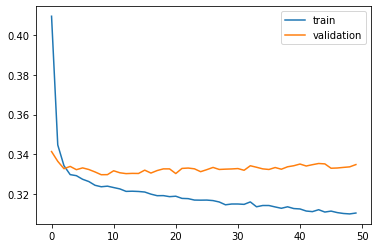

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4593735040499425
Dropout rate 2: 0.35131117762762315
Fold: 3
Best val loss: 0.32968605340851675
#################################
Time to train MLP:  219.76003170013428
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 12s - loss: 0.4562 - acc: 0.8486 - val_loss: 0.3336 - val_acc: 0.8736

Epoch 00001: val_loss improved from inf to 0.33362, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3486 - acc: 0.8737 - val_loss: 0.3283 - val_acc: 0.8743

Epoch 00002: val_loss improved from 0.33362 to 0.32834, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3353 - acc: 0.8748 - val_loss: 0.3238 - val_acc: 0.8754

Epoch 00003: val_loss improved from 0.32834 to 0.32385, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3320 - acc: 0.8749 - val_loss: 0.3257 - val_acc: 0.8743

Epoch 00004: val_loss did not improve from 0.32385
Epoch 5/50
 - 4s - loss: 0.3284 

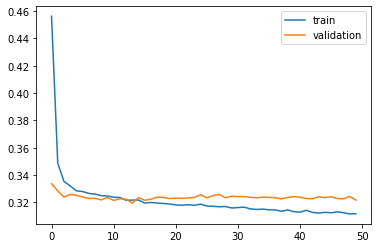

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4593735040499425
Dropout rate 2: 0.35131117762762315
Fold: 4
Best val loss: 0.3193510242568122
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.408084149


Epoch 00040: val_loss did not improve from 0.31844
Epoch 41/50
 - 4s - loss: 0.3089 - acc: 0.8802 - val_loss: 0.3332 - val_acc: 0.8794

Epoch 00041: val_loss did not improve from 0.31844
Epoch 42/50
 - 4s - loss: 0.3074 - acc: 0.8814 - val_loss: 0.3341 - val_acc: 0.8783

Epoch 00042: val_loss did not improve from 0.31844
Epoch 43/50
 - 4s - loss: 0.3077 - acc: 0.8808 - val_loss: 0.3332 - val_acc: 0.8794

Epoch 00043: val_loss did not improve from 0.31844
Epoch 44/50
 - 4s - loss: 0.3080 - acc: 0.8814 - val_loss: 0.3334 - val_acc: 0.8792

Epoch 00044: val_loss did not improve from 0.31844
Epoch 45/50
 - 4s - loss: 0.3072 - acc: 0.8807 - val_loss: 0.3356 - val_acc: 0.8780

Epoch 00045: val_loss did not improve from 0.31844
Epoch 46/50
 - 4s - loss: 0.3072 - acc: 0.8811 - val_loss: 0.3329 - val_acc: 0.8793

Epoch 00046: val_loss did not improve from 0.31844
Epoch 47/50
 - 4s - loss: 0.3069 - acc: 0.8811 - val_loss: 0.3299 - val_acc: 0.8796

Epoch 00047: val_loss did not improve from 0.31

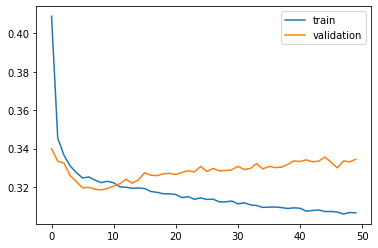

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4503574270585061
Dropout rate 2: 0.16378473813171152
Fold: 0
Best val loss: 0.318441382461124
#################################
Time to train MLP:  221.5244038105011
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 14s - loss: 0.3741 - acc: 0.8656 - val_loss: 0.3367 - val_acc: 0.8722

Epoch 00001: val_loss improved from inf to 0.33674, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3382 - acc: 0.8740 - val_loss: 0.3325 - val_acc: 0.8740

Epoch 00002: val_loss improved from 0.33674 to 0.33253, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3324 - acc: 0.8749 - val_loss: 0.3302 - val_acc: 0.8742

Epoch 00003: val_loss improved from 0.33253 to 0.33019, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3304 - acc: 0.8752 - val_loss: 0.3314 - val_acc: 0.8740

Epoch 00004: val_loss did not improve from 0.33019
Epoch 5/50
 - 4s - loss: 0.3273 - a

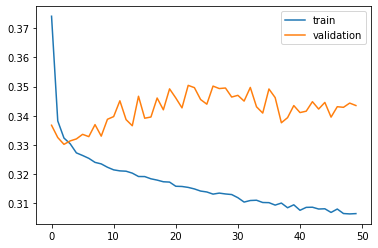

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4503574270585061
Dropout rate 2: 0.16378473813171152
Fold: 1
Best val loss: 0.330189049217436
#################################
Time to train MLP:  225.2419192790985
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 13s - loss: 0.3890 - acc: 0.8636 - val_loss: 0.3370 - val_acc: 0.8730

Epoch 00001: val_loss improved from inf to 0.33701, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3388 - acc: 0.8743 - val_loss: 0.3299 - val_acc: 0.8747

Epoch 00002: val_loss improved from 0.33701 to 0.32995, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3297 - acc: 0.8761 - val_loss: 0.3292 - val_acc: 0.8743

Epoch 00003: val_loss improved from 0.32995 to 0.32923, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3254 - acc: 0.8771 - val_loss: 0.3289 - val_acc: 0.8737

Epoch 00004: val_loss improved from 0.32923 to 0.32888, saving model to MLP_val_weight

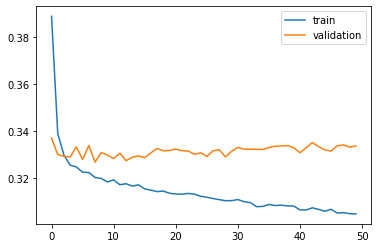

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4503574270585061
Dropout rate 2: 0.16378473813171152
Fold: 2
Best val loss: 0.3267341976695591
#################################
Time to train MLP:  223.37634587287903
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 14s - loss: 0.3727 - acc: 0.8661 - val_loss: 0.3412 - val_acc: 0.8684

Epoch 00001: val_loss improved from inf to 0.34118, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3352 - acc: 0.8751 - val_loss: 0.3333 - val_acc: 0.8693

Epoch 00002: val_loss improved from 0.34118 to 0.33332, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3288 - acc: 0.8758 - val_loss: 0.3297 - val_acc: 0.8701

Epoch 00003: val_loss improved from 0.33332 to 0.32967, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3248 - acc: 0.8764 - val_loss: 0.3308 - val_acc: 0.8687

Epoch 00004: val_loss did not improve from 0.32967
Epoch 5/50
 - 4s - loss: 0.3226 -

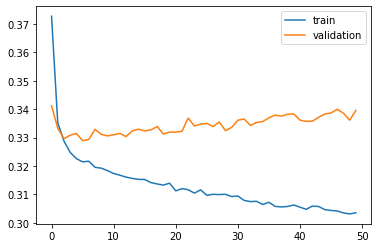

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4503574270585061
Dropout rate 2: 0.16378473813171152
Fold: 3
Best val loss: 0.328933658334944
#################################
Time to train MLP:  227.46186017990112
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 13s - loss: 0.3972 - acc: 0.8642 - val_loss: 0.3527 - val_acc: 0.8736

Epoch 00001: val_loss improved from inf to 0.35265, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3513 - acc: 0.8720 - val_loss: 0.3448 - val_acc: 0.8736

Epoch 00002: val_loss improved from 0.35265 to 0.34482, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3432 - acc: 0.8720 - val_loss: 0.3437 - val_acc: 0.8736

Epoch 00003: val_loss improved from 0.34482 to 0.34370, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3382 - acc: 0.8722 - val_loss: 0.3385 - val_acc: 0.8736

Epoch 00004: val_loss improved from 0.34370 to 0.33846, saving model to MLP_val_weigh

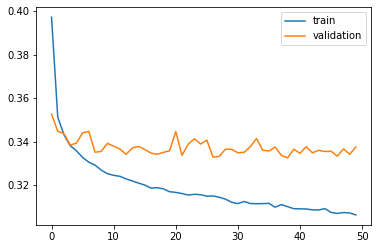

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4503574270585061
Dropout rate 2: 0.16378473813171152
Fold: 4
Best val loss: 0.33259383214844596
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414


Epoch 00039: val_loss did not improve from 0.32018
Epoch 40/50
 - 4s - loss: 0.2716 - acc: 0.8978 - val_loss: 0.3897 - val_acc: 0.8748

Epoch 00040: val_loss did not improve from 0.32018
Epoch 41/50
 - 4s - loss: 0.2701 - acc: 0.8978 - val_loss: 0.3937 - val_acc: 0.8726

Epoch 00041: val_loss did not improve from 0.32018
Epoch 42/50
 - 4s - loss: 0.2708 - acc: 0.8977 - val_loss: 0.3881 - val_acc: 0.8752

Epoch 00042: val_loss did not improve from 0.32018
Epoch 43/50
 - 4s - loss: 0.2690 - acc: 0.8985 - val_loss: 0.3922 - val_acc: 0.8730

Epoch 00043: val_loss did not improve from 0.32018
Epoch 44/50
 - 5s - loss: 0.2690 - acc: 0.8985 - val_loss: 0.3926 - val_acc: 0.8756

Epoch 00044: val_loss did not improve from 0.32018
Epoch 45/50
 - 4s - loss: 0.2676 - acc: 0.8995 - val_loss: 0.3945 - val_acc: 0.8741

Epoch 00045: val_loss did not improve from 0.32018
Epoch 46/50
 - 4s - loss: 0.2684 - acc: 0.8993 - val_loss: 0.3955 - val_acc: 0.8756

Epoch 00046: val_loss did not improve from 0.32

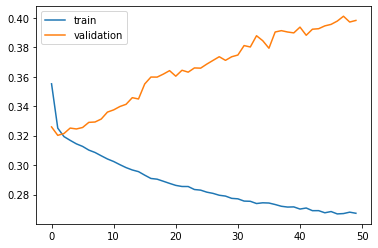

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.016710713813172295
Dropout rate 2: 0.1673237645530279
Fold: 0
Best val loss: 0.32017532881100974
#################################
Time to train MLP:  233.04529762268066
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 17s - loss: 0.3510 - acc: 0.8689 - val_loss: 0.3304 - val_acc: 0.8728

Epoch 00001: val_loss improved from inf to 0.33043, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3234 - acc: 0.8779 - val_loss: 0.3266 - val_acc: 0.8723

Epoch 00002: val_loss improved from 0.33043 to 0.32659, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3184 - acc: 0.8791 - val_loss: 0.3254 - val_acc: 0.8748

Epoch 00003: val_loss improved from 0.32659 to 0.32540, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 4s - loss: 0.3151 - acc: 0.8800 - val_loss: 0.3275 - val_acc: 0.8738

Epoch 00004: val_loss did not improve from 0.32540
Epoch 5/50
 - 4s - loss: 0.3129

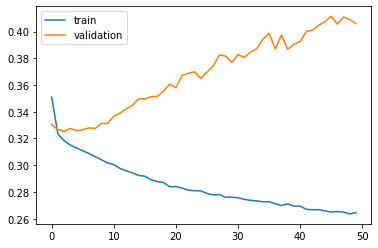

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.016710713813172295
Dropout rate 2: 0.1673237645530279
Fold: 1
Best val loss: 0.32540142554706997
#################################
Time to train MLP:  238.37388944625854
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 14s - loss: 0.3592 - acc: 0.8675 - val_loss: 0.3324 - val_acc: 0.8739

Epoch 00001: val_loss improved from inf to 0.33237, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3254 - acc: 0.8761 - val_loss: 0.3262 - val_acc: 0.8778

Epoch 00002: val_loss improved from 0.33237 to 0.32620, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3181 - acc: 0.8780 - val_loss: 0.3269 - val_acc: 0.8768

Epoch 00003: val_loss did not improve from 0.32620
Epoch 4/50
 - 4s - loss: 0.3157 - acc: 0.8785 - val_loss: 0.3272 - val_acc: 0.8777

Epoch 00004: val_loss did not improve from 0.32620
Epoch 5/50
 - 4s - loss: 0.3137 - acc: 0.8789 - val_loss: 0.3268 - val_ac

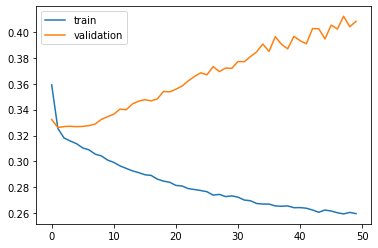

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.016710713813172295
Dropout rate 2: 0.1673237645530279
Fold: 2
Best val loss: 0.3261988467110528
#################################
Time to train MLP:  234.20017766952515
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 12s - loss: 0.3564 - acc: 0.8684 - val_loss: 0.3315 - val_acc: 0.8694

Epoch 00001: val_loss improved from inf to 0.33152, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3234 - acc: 0.8776 - val_loss: 0.3275 - val_acc: 0.8722

Epoch 00002: val_loss improved from 0.33152 to 0.32755, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3175 - acc: 0.8788 - val_loss: 0.3280 - val_acc: 0.8714

Epoch 00003: val_loss did not improve from 0.32755
Epoch 4/50
 - 4s - loss: 0.3151 - acc: 0.8796 - val_loss: 0.3282 - val_acc: 0.8721

Epoch 00004: val_loss did not improve from 0.32755
Epoch 5/50
 - 4s - loss: 0.3134 - acc: 0.8804 - val_loss: 0.3297 - val_acc

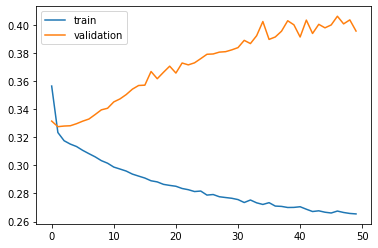

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.016710713813172295
Dropout rate 2: 0.1673237645530279
Fold: 3
Best val loss: 0.32754500759972466
#################################
Time to train MLP:  231.4712278842926
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 13s - loss: 0.3421 - acc: 0.8730 - val_loss: 0.3225 - val_acc: 0.8769

Epoch 00001: val_loss improved from inf to 0.32248, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 4s - loss: 0.3224 - acc: 0.8774 - val_loss: 0.3197 - val_acc: 0.8798

Epoch 00002: val_loss improved from 0.32248 to 0.31968, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 4s - loss: 0.3170 - acc: 0.8778 - val_loss: 0.3207 - val_acc: 0.8784

Epoch 00003: val_loss did not improve from 0.31968
Epoch 4/50
 - 5s - loss: 0.3148 - acc: 0.8790 - val_loss: 0.3206 - val_acc: 0.8800

Epoch 00004: val_loss did not improve from 0.31968
Epoch 5/50
 - 4s - loss: 0.3123 - acc: 0.8797 - val_loss: 0.3214 - val_acc

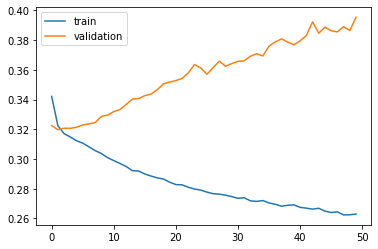

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.016710713813172295
Dropout rate 2: 0.1673237645530279
Fold: 4
Best val loss: 0.3196763230694665
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414

 - 4s - loss: 0.3214 - acc: 0.8767 - val_loss: 0.3313 - val_acc: 0.8791

Epoch 00036: val_loss did not improve from 0.32224
Epoch 37/50
 - 4s - loss: 0.3211 - acc: 0.8776 - val_loss: 0.3328 - val_acc: 0.8781

Epoch 00037: val_loss did not improve from 0.32224
Epoch 38/50
 - 4s - loss: 0.3209 - acc: 0.8767 - val_loss: 0.3320 - val_acc: 0.8791

Epoch 00038: val_loss did not improve from 0.32224
Epoch 39/50
 - 4s - loss: 0.3216 - acc: 0.8757 - val_loss: 0.3327 - val_acc: 0.8789

Epoch 00039: val_loss did not improve from 0.32224
Epoch 40/50
 - 5s - loss: 0.3216 - acc: 0.8769 - val_loss: 0.3336 - val_acc: 0.8789

Epoch 00040: val_loss did not improve from 0.32224
Epoch 41/50
 - 4s - loss: 0.3210 - acc: 0.8763 - val_loss: 0.3327 - val_acc: 0.8787

Epoch 00041: val_loss did not improve from 0.32224
Epoch 42/50
 - 5s - loss: 0.3197 - acc: 0.8777 - val_loss: 0.3306 - val_acc: 0.8796

Epoch 00042: val_loss did not improve from 0.32224
Epoch 43/50
 - 5s - loss: 0.3201 - acc: 0.8771 - val_loss: 0

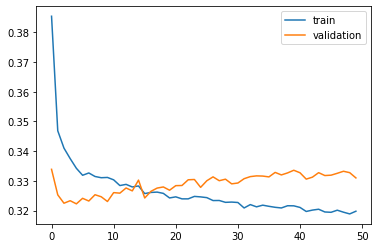

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4784746681375584
Dropout rate 2: 0.48902903950825943
Fold: 0
Best val loss: 0.3222442766295539
#################################
Time to train MLP:  237.03408312797546
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 15s - loss: 0.3930 - acc: 0.8673 - val_loss: 0.3449 - val_acc: 0.8713

Epoch 00001: val_loss improved from inf to 0.34492, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3458 - acc: 0.8732 - val_loss: 0.3371 - val_acc: 0.8712

Epoch 00002: val_loss improved from 0.34492 to 0.33706, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3394 - acc: 0.8737 - val_loss: 0.3322 - val_acc: 0.8713

Epoch 00003: val_loss improved from 0.33706 to 0.33217, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3376 - acc: 0.8738 - val_loss: 0.3315 - val_acc: 0.8714

Epoch 00004: val_loss improved from 0.33217 to 0.33151, saving model to MLP_val_weig

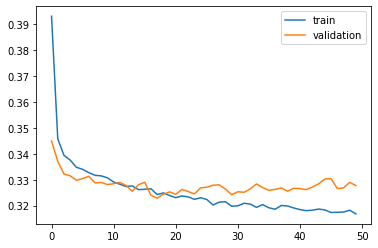

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4784746681375584
Dropout rate 2: 0.48902903950825943
Fold: 1
Best val loss: 0.32287161376741197
#################################
Time to train MLP:  239.7784764766693
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 14s - loss: 0.4317 - acc: 0.8583 - val_loss: 0.3371 - val_acc: 0.8719

Epoch 00001: val_loss improved from inf to 0.33709, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3541 - acc: 0.8724 - val_loss: 0.3371 - val_acc: 0.8709

Epoch 00002: val_loss improved from 0.33709 to 0.33708, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3408 - acc: 0.8737 - val_loss: 0.3287 - val_acc: 0.8723

Epoch 00003: val_loss improved from 0.33708 to 0.32870, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3364 - acc: 0.8738 - val_loss: 0.3324 - val_acc: 0.8719

Epoch 00004: val_loss did not improve from 0.32870
Epoch 5/50
 - 5s - loss: 0.3327 -

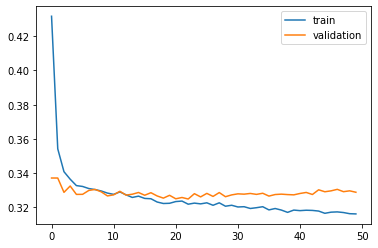

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4784746681375584
Dropout rate 2: 0.48902903950825943
Fold: 2
Best val loss: 0.32479855574501887
#################################
Time to train MLP:  239.0994279384613
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 15s - loss: 0.3947 - acc: 0.8653 - val_loss: 0.3439 - val_acc: 0.8661

Epoch 00001: val_loss improved from inf to 0.34394, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3458 - acc: 0.8730 - val_loss: 0.3379 - val_acc: 0.8661

Epoch 00002: val_loss improved from 0.34394 to 0.33793, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3416 - acc: 0.8732 - val_loss: 0.3392 - val_acc: 0.8661

Epoch 00003: val_loss did not improve from 0.33793
Epoch 4/50
 - 5s - loss: 0.3394 - acc: 0.8732 - val_loss: 0.3372 - val_acc: 0.8661

Epoch 00004: val_loss improved from 0.33793 to 0.33719, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 5s - loss: 0.3383 -

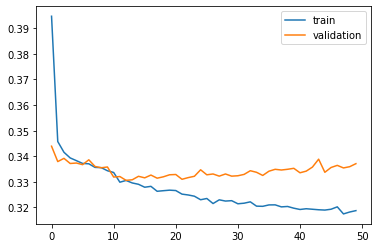

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4784746681375584
Dropout rate 2: 0.48902903950825943
Fold: 3
Best val loss: 0.3306011211077372
#################################
Time to train MLP:  246.03573942184448
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 14s - loss: 0.4047 - acc: 0.8603 - val_loss: 0.3327 - val_acc: 0.8738

Epoch 00001: val_loss improved from inf to 0.33272, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3437 - acc: 0.8736 - val_loss: 0.3278 - val_acc: 0.8740

Epoch 00002: val_loss improved from 0.33272 to 0.32783, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3380 - acc: 0.8737 - val_loss: 0.3275 - val_acc: 0.8736

Epoch 00003: val_loss improved from 0.32783 to 0.32753, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3342 - acc: 0.8748 - val_loss: 0.3236 - val_acc: 0.8746

Epoch 00004: val_loss improved from 0.32753 to 0.32364, saving model to MLP_val_weig

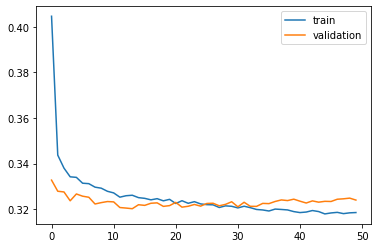

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4784746681375584
Dropout rate 2: 0.48902903950825943
Fold: 4
Best val loss: 0.3201624746852451
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.408084149


Epoch 00033: val_loss did not improve from 0.31772
Epoch 34/50
 - 5s - loss: 0.2854 - acc: 0.8933 - val_loss: 0.3629 - val_acc: 0.8771

Epoch 00034: val_loss did not improve from 0.31772
Epoch 35/50
 - 5s - loss: 0.2841 - acc: 0.8943 - val_loss: 0.3578 - val_acc: 0.8753

Epoch 00035: val_loss did not improve from 0.31772
Epoch 36/50
 - 5s - loss: 0.2840 - acc: 0.8939 - val_loss: 0.3592 - val_acc: 0.8746

Epoch 00036: val_loss did not improve from 0.31772
Epoch 37/50
 - 5s - loss: 0.2831 - acc: 0.8941 - val_loss: 0.3635 - val_acc: 0.8739

Epoch 00037: val_loss did not improve from 0.31772
Epoch 38/50
 - 5s - loss: 0.2826 - acc: 0.8947 - val_loss: 0.3654 - val_acc: 0.8760

Epoch 00038: val_loss did not improve from 0.31772
Epoch 39/50
 - 5s - loss: 0.2822 - acc: 0.8951 - val_loss: 0.3679 - val_acc: 0.8758

Epoch 00039: val_loss did not improve from 0.31772
Epoch 40/50
 - 5s - loss: 0.2797 - acc: 0.8953 - val_loss: 0.3682 - val_acc: 0.8740

Epoch 00040: val_loss did not improve from 0.31

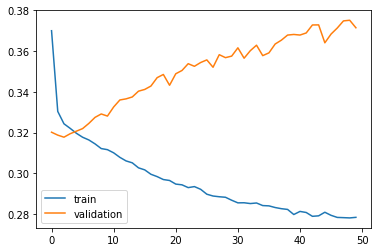

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.06860466067803822
Dropout rate 2: 0.3122910558676762
Fold: 0
Best val loss: 0.3177180922826131
#################################
Time to train MLP:  246.39240789413452
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 14s - loss: 0.3694 - acc: 0.8653 - val_loss: 0.3290 - val_acc: 0.8748

Epoch 00001: val_loss improved from inf to 0.32895, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3294 - acc: 0.8763 - val_loss: 0.3256 - val_acc: 0.8753

Epoch 00002: val_loss improved from 0.32895 to 0.32555, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3226 - acc: 0.8770 - val_loss: 0.3240 - val_acc: 0.8764

Epoch 00003: val_loss improved from 0.32555 to 0.32405, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3203 - acc: 0.8772 - val_loss: 0.3251 - val_acc: 0.8757

Epoch 00004: val_loss did not improve from 0.32405
Epoch 5/50
 - 5s - loss: 0.3184 -

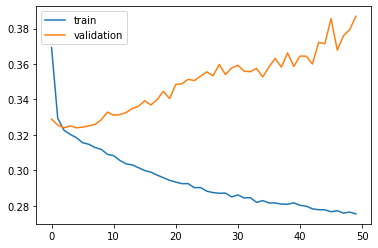

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.06860466067803822
Dropout rate 2: 0.3122910558676762
Fold: 1
Best val loss: 0.32403251367145114
#################################
Time to train MLP:  249.60012221336365
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 14s - loss: 0.3655 - acc: 0.8683 - val_loss: 0.3301 - val_acc: 0.8729

Epoch 00001: val_loss improved from inf to 0.33005, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3318 - acc: 0.8750 - val_loss: 0.3268 - val_acc: 0.8752

Epoch 00002: val_loss improved from 0.33005 to 0.32676, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3252 - acc: 0.8762 - val_loss: 0.3257 - val_acc: 0.8758

Epoch 00003: val_loss improved from 0.32676 to 0.32571, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3217 - acc: 0.8774 - val_loss: 0.3240 - val_acc: 0.8774

Epoch 00004: val_loss improved from 0.32571 to 0.32402, saving model to MLP_val_wei

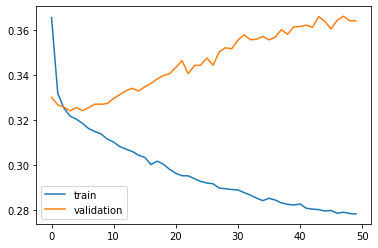

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.06860466067803822
Dropout rate 2: 0.3122910558676762
Fold: 2
Best val loss: 0.32402182126045226
#################################
Time to train MLP:  249.2422366142273
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 14s - loss: 0.3651 - acc: 0.8662 - val_loss: 0.3300 - val_acc: 0.8693

Epoch 00001: val_loss improved from inf to 0.32999, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3283 - acc: 0.8765 - val_loss: 0.3274 - val_acc: 0.8704

Epoch 00002: val_loss improved from 0.32999 to 0.32736, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3227 - acc: 0.8776 - val_loss: 0.3287 - val_acc: 0.8707

Epoch 00003: val_loss did not improve from 0.32736
Epoch 4/50
 - 5s - loss: 0.3205 - acc: 0.8778 - val_loss: 0.3282 - val_acc: 0.8699

Epoch 00004: val_loss did not improve from 0.32736
Epoch 5/50
 - 5s - loss: 0.3187 - acc: 0.8786 - val_loss: 0.3265 - val_acc:

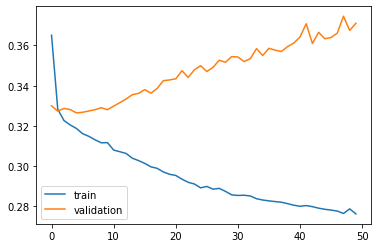

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.06860466067803822
Dropout rate 2: 0.3122910558676762
Fold: 3
Best val loss: 0.3264691656430562
#################################
Time to train MLP:  249.9982147216797
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 15s - loss: 0.3574 - acc: 0.8683 - val_loss: 0.3256 - val_acc: 0.8768

Epoch 00001: val_loss improved from inf to 0.32555, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3285 - acc: 0.8753 - val_loss: 0.3221 - val_acc: 0.8779

Epoch 00002: val_loss improved from 0.32555 to 0.32205, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3239 - acc: 0.8765 - val_loss: 0.3236 - val_acc: 0.8786

Epoch 00003: val_loss did not improve from 0.32205
Epoch 4/50
 - 5s - loss: 0.3208 - acc: 0.8771 - val_loss: 0.3210 - val_acc: 0.8779

Epoch 00004: val_loss improved from 0.32205 to 0.32100, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 5s - loss: 0.3182 - 

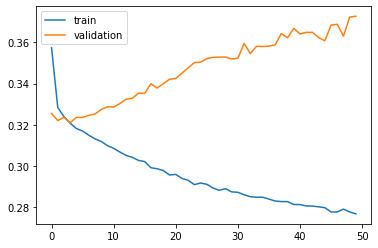

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.06860466067803822
Dropout rate 2: 0.3122910558676762
Fold: 4
Best val loss: 0.32100344679090714
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f6775485e48>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f6775289da0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 15s - loss: 0.4057 - acc: 0.8568 - val_loss: 0.3320 - val_acc: 0.8764

Epoch 00001: val_loss improved from inf to 0.33203, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3402 - acc: 0.8737 - val_loss: 0.3220 - val_acc: 0.8778

Epoch 00002: val_loss improved from 0.33203 to 0.32195, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3323 - acc: 0.8750 - val_loss: 0.3203 - val_acc: 0.8782

Epoch 00003: val_loss improved from 0.32195 to 0.32027, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3286 - acc: 0.8754 - val_loss: 0.3171 - val_acc: 0.8786

Epoch 00004: val_loss improved from 0.32027 to 0.31714, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 5s - loss: 0.3268 - acc: 0.8763 - val_loss: 0.3166 - val_acc: 0.8798

Epoch 00005: val_loss improved from 0.31714 to 0.31665, saving model to MLP_val_weights.hdf5
Epoch 6/50
 - 5s - loss: 0.3254 - acc: 0.8761 - val_loss: 0.3206 - va

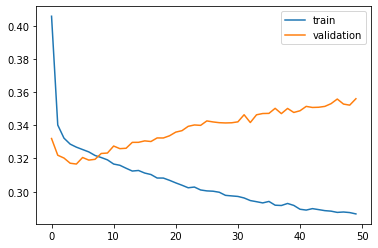

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.14191417647897292
Dropout rate 2: 0.4751567623497627
Fold: 0
Best val loss: 0.3166457651456197
#################################
Time to train MLP:  253.62860798835754
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 16s - loss: 0.3949 - acc: 0.8614 - val_loss: 0.3288 - val_acc: 0.8748

Epoch 00001: val_loss improved from inf to 0.32876, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3353 - acc: 0.8750 - val_loss: 0.3261 - val_acc: 0.8759

Epoch 00002: val_loss improved from 0.32876 to 0.32609, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3297 - acc: 0.8754 - val_loss: 0.3240 - val_acc: 0.8744

Epoch 00003: val_loss improved from 0.32609 to 0.32397, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3263 - acc: 0.8767 - val_loss: 0.3250 - val_acc: 0.8751

Epoch 00004: val_loss did not improve from 0.32397
Epoch 5/50
 - 5s - loss: 0.3250 -

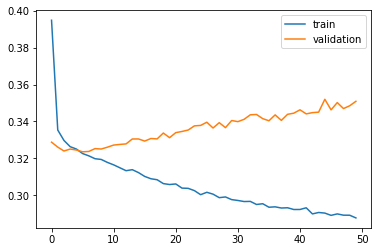

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.14191417647897292
Dropout rate 2: 0.4751567623497627
Fold: 1
Best val loss: 0.3235441229873233
#################################
Time to train MLP:  254.82777285575867
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 16s - loss: 0.3726 - acc: 0.8630 - val_loss: 0.3295 - val_acc: 0.8723

Epoch 00001: val_loss improved from inf to 0.32954, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3316 - acc: 0.8752 - val_loss: 0.3267 - val_acc: 0.8739

Epoch 00002: val_loss improved from 0.32954 to 0.32668, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3273 - acc: 0.8759 - val_loss: 0.3261 - val_acc: 0.8760

Epoch 00003: val_loss improved from 0.32668 to 0.32606, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3249 - acc: 0.8765 - val_loss: 0.3258 - val_acc: 0.8764

Epoch 00004: val_loss improved from 0.32606 to 0.32581, saving model to MLP_val_weig

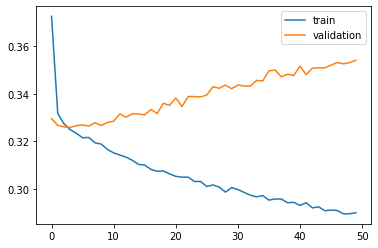

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.14191417647897292
Dropout rate 2: 0.4751567623497627
Fold: 2
Best val loss: 0.32581406723128425
#################################
Time to train MLP:  256.6396064758301
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 16s - loss: 0.3755 - acc: 0.8666 - val_loss: 0.3312 - val_acc: 0.8677

Epoch 00001: val_loss improved from inf to 0.33116, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3338 - acc: 0.8753 - val_loss: 0.3296 - val_acc: 0.8691

Epoch 00002: val_loss improved from 0.33116 to 0.32963, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3280 - acc: 0.8760 - val_loss: 0.3284 - val_acc: 0.8696

Epoch 00003: val_loss improved from 0.32963 to 0.32840, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3261 - acc: 0.8761 - val_loss: 0.3278 - val_acc: 0.8708

Epoch 00004: val_loss improved from 0.32840 to 0.32779, saving model to MLP_val_weig

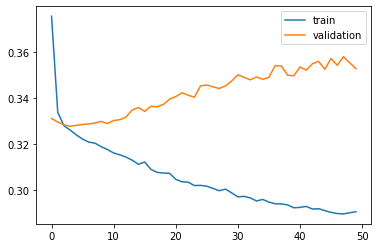

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.14191417647897292
Dropout rate 2: 0.4751567623497627
Fold: 3
Best val loss: 0.3277858355840047
#################################
Time to train MLP:  259.23577427864075
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 16s - loss: 0.3729 - acc: 0.8655 - val_loss: 0.3260 - val_acc: 0.8764

Epoch 00001: val_loss improved from inf to 0.32600, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3319 - acc: 0.8740 - val_loss: 0.3216 - val_acc: 0.8778

Epoch 00002: val_loss improved from 0.32600 to 0.32156, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3274 - acc: 0.8756 - val_loss: 0.3197 - val_acc: 0.8780

Epoch 00003: val_loss improved from 0.32156 to 0.31967, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3274 - acc: 0.8754 - val_loss: 0.3205 - val_acc: 0.8782

Epoch 00004: val_loss did not improve from 0.31967
Epoch 5/50
 - 5s - loss: 0.3233 -

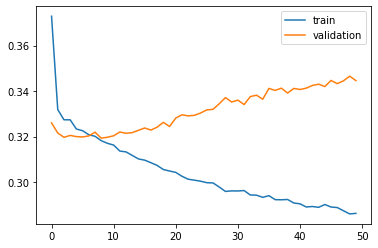

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.14191417647897292
Dropout rate 2: 0.4751567623497627
Fold: 4
Best val loss: 0.31929867039786447
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414


Epoch 00028: val_loss did not improve from 0.31666
Epoch 29/50
 - 5s - loss: 0.3114 - acc: 0.8790 - val_loss: 0.3278 - val_acc: 0.8824

Epoch 00029: val_loss did not improve from 0.31666
Epoch 30/50
 - 5s - loss: 0.3115 - acc: 0.8796 - val_loss: 0.3286 - val_acc: 0.8810

Epoch 00030: val_loss did not improve from 0.31666
Epoch 31/50
 - 5s - loss: 0.3096 - acc: 0.8797 - val_loss: 0.3278 - val_acc: 0.8818

Epoch 00031: val_loss did not improve from 0.31666
Epoch 32/50
 - 5s - loss: 0.3095 - acc: 0.8802 - val_loss: 0.3292 - val_acc: 0.8819

Epoch 00032: val_loss did not improve from 0.31666
Epoch 33/50
 - 5s - loss: 0.3092 - acc: 0.8802 - val_loss: 0.3295 - val_acc: 0.8824

Epoch 00033: val_loss did not improve from 0.31666
Epoch 34/50
 - 5s - loss: 0.3085 - acc: 0.8806 - val_loss: 0.3314 - val_acc: 0.8820

Epoch 00034: val_loss did not improve from 0.31666
Epoch 35/50
 - 5s - loss: 0.3081 - acc: 0.8803 - val_loss: 0.3297 - val_acc: 0.8813

Epoch 00035: val_loss did not improve from 0.31

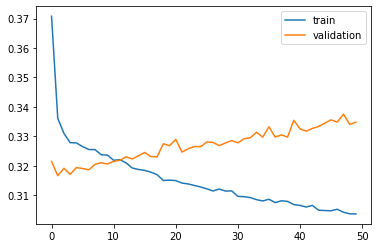

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.30304159217941445
Dropout rate 2: 0.38373782531024436
Fold: 0
Best val loss: 0.31666069467862445
#################################
Time to train MLP:  262.5054578781128
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 17s - loss: 0.3728 - acc: 0.8655 - val_loss: 0.3312 - val_acc: 0.8738

Epoch 00001: val_loss improved from inf to 0.33123, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3344 - acc: 0.8743 - val_loss: 0.3278 - val_acc: 0.8752

Epoch 00002: val_loss improved from 0.33123 to 0.32781, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3283 - acc: 0.8755 - val_loss: 0.3246 - val_acc: 0.8761

Epoch 00003: val_loss improved from 0.32781 to 0.32455, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3266 - acc: 0.8758 - val_loss: 0.3263 - val_acc: 0.8761

Epoch 00004: val_loss did not improve from 0.32455
Epoch 5/50
 - 5s - loss: 0.3236 

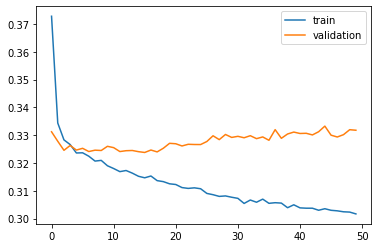

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.30304159217941445
Dropout rate 2: 0.38373782531024436
Fold: 1
Best val loss: 0.3237766391436259
#################################
Time to train MLP:  264.2840404510498
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 20s - loss: 0.4185 - acc: 0.8484 - val_loss: 0.3325 - val_acc: 0.8720

Epoch 00001: val_loss improved from inf to 0.33247, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3418 - acc: 0.8740 - val_loss: 0.3291 - val_acc: 0.8730

Epoch 00002: val_loss improved from 0.33247 to 0.32913, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3301 - acc: 0.8750 - val_loss: 0.3259 - val_acc: 0.8743

Epoch 00003: val_loss improved from 0.32913 to 0.32592, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3288 - acc: 0.8758 - val_loss: 0.3269 - val_acc: 0.8738

Epoch 00004: val_loss did not improve from 0.32592
Epoch 5/50
 - 5s - loss: 0.3255 -

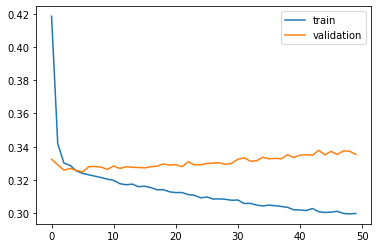

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.30304159217941445
Dropout rate 2: 0.38373782531024436
Fold: 2
Best val loss: 0.32486317920684815
#################################
Time to train MLP:  268.7223699092865
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 18s - loss: 0.3859 - acc: 0.8682 - val_loss: 0.3401 - val_acc: 0.8661

Epoch 00001: val_loss improved from inf to 0.34010, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3417 - acc: 0.8735 - val_loss: 0.3340 - val_acc: 0.8668

Epoch 00002: val_loss improved from 0.34010 to 0.33397, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3337 - acc: 0.8749 - val_loss: 0.3294 - val_acc: 0.8692

Epoch 00003: val_loss improved from 0.33397 to 0.32943, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3288 - acc: 0.8753 - val_loss: 0.3278 - val_acc: 0.8696

Epoch 00004: val_loss improved from 0.32943 to 0.32778, saving model to MLP_val_wei

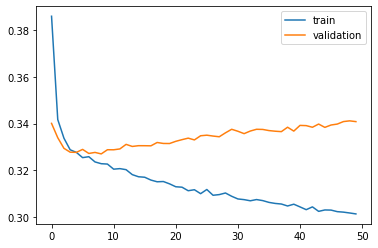

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.30304159217941445
Dropout rate 2: 0.38373782531024436
Fold: 3
Best val loss: 0.3270529132684072
#################################
Time to train MLP:  269.5258710384369
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 18s - loss: 0.3668 - acc: 0.8696 - val_loss: 0.3278 - val_acc: 0.8748

Epoch 00001: val_loss improved from inf to 0.32784, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3339 - acc: 0.8742 - val_loss: 0.3219 - val_acc: 0.8769

Epoch 00002: val_loss improved from 0.32784 to 0.32186, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3280 - acc: 0.8760 - val_loss: 0.3198 - val_acc: 0.8778

Epoch 00003: val_loss improved from 0.32186 to 0.31984, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3259 - acc: 0.8762 - val_loss: 0.3221 - val_acc: 0.8774

Epoch 00004: val_loss did not improve from 0.31984
Epoch 5/50
 - 5s - loss: 0.3252 -

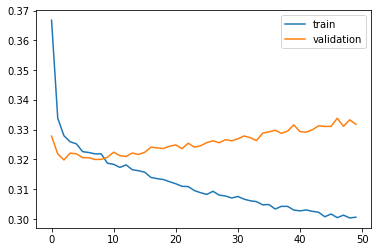

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.30304159217941445
Dropout rate 2: 0.38373782531024436
Fold: 4
Best val loss: 0.3198350150850084
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414


Epoch 00024: val_loss did not improve from 0.31858
Epoch 25/50
 - 5s - loss: 0.3203 - acc: 0.8778 - val_loss: 0.3243 - val_acc: 0.8786

Epoch 00025: val_loss did not improve from 0.31858
Epoch 26/50
 - 5s - loss: 0.3202 - acc: 0.8769 - val_loss: 0.3246 - val_acc: 0.8784

Epoch 00026: val_loss did not improve from 0.31858
Epoch 27/50
 - 5s - loss: 0.3194 - acc: 0.8783 - val_loss: 0.3254 - val_acc: 0.8788

Epoch 00027: val_loss did not improve from 0.31858
Epoch 28/50
 - 5s - loss: 0.3202 - acc: 0.8771 - val_loss: 0.3263 - val_acc: 0.8783

Epoch 00028: val_loss did not improve from 0.31858
Epoch 29/50
 - 5s - loss: 0.3181 - acc: 0.8778 - val_loss: 0.3257 - val_acc: 0.8791

Epoch 00029: val_loss did not improve from 0.31858
Epoch 30/50
 - 5s - loss: 0.3202 - acc: 0.8774 - val_loss: 0.3253 - val_acc: 0.8790

Epoch 00030: val_loss did not improve from 0.31858
Epoch 31/50
 - 5s - loss: 0.3180 - acc: 0.8778 - val_loss: 0.3248 - val_acc: 0.8794

Epoch 00031: val_loss did not improve from 0.31

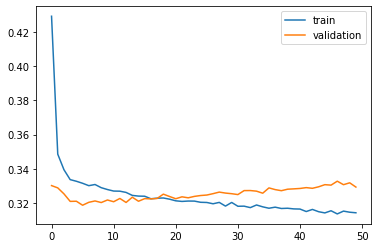

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4721125680265211
Dropout rate 2: 0.41250462660738674
Fold: 0
Best val loss: 0.31857537828551397
#################################
Time to train MLP:  270.7485098838806
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 18s - loss: 0.3799 - acc: 0.8692 - val_loss: 0.3410 - val_acc: 0.8707

Epoch 00001: val_loss improved from inf to 0.34102, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3415 - acc: 0.8730 - val_loss: 0.3375 - val_acc: 0.8712

Epoch 00002: val_loss improved from 0.34102 to 0.33750, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3375 - acc: 0.8737 - val_loss: 0.3290 - val_acc: 0.8724

Epoch 00003: val_loss improved from 0.33750 to 0.32904, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3347 - acc: 0.8742 - val_loss: 0.3333 - val_acc: 0.8722

Epoch 00004: val_loss did not improve from 0.32904
Epoch 5/50
 - 5s - loss: 0.3340 -

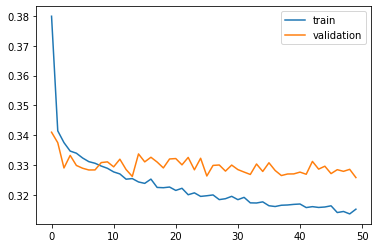

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4721125680265211
Dropout rate 2: 0.41250462660738674
Fold: 1
Best val loss: 0.32581927898195057
#################################
Time to train MLP:  273.81052327156067


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f675f819e10>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f675f5fc8d0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 19s - loss: 0.4166 - acc: 0.8583 - val_loss: 0.3395 - val_acc: 0.8709

Epoch 00001: val_loss improved from inf to 0.33950, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3469 - acc: 0.8745 - val_loss: 0.3311 - val_acc: 0.8718

Epoch 00002: val_loss improved from 0.33950 to 0.33114, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3368 - acc: 0.8750 - val_loss: 0.3293 - val_acc: 0.8732

Epoch 00003: val_loss improved from 0.33114 to 0.32933, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3340 - acc: 0.8750 - val_loss: 0.3290 - val_acc: 0.8721

Epoch 00004: val_loss improved from 0.32933 to 0.32898, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 5s - loss: 0.3323 - acc: 0.8749 - val_loss: 0.3305 - val_acc: 0.8727

Epoch 00005: val_loss did not improve from 0.32898
Epoch 6/50
 - 5s - loss: 0.3305 - acc: 0.8757 - val_loss: 0.3305 - val_acc: 0.8730

Epoch 00006: val_loss did n

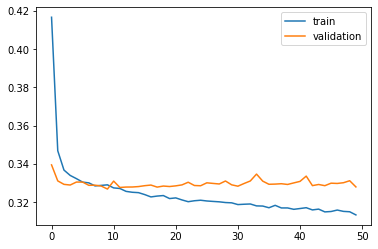

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4721125680265211
Dropout rate 2: 0.41250462660738674
Fold: 2
Best val loss: 0.32687989981969195
#################################
Time to train MLP:  275.61176204681396
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 19s - loss: 0.4288 - acc: 0.8524 - val_loss: 0.3400 - val_acc: 0.8661

Epoch 00001: val_loss improved from inf to 0.34003, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3458 - acc: 0.8737 - val_loss: 0.3363 - val_acc: 0.8664

Epoch 00002: val_loss improved from 0.34003 to 0.33630, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3354 - acc: 0.8751 - val_loss: 0.3352 - val_acc: 0.8668

Epoch 00003: val_loss improved from 0.33630 to 0.33518, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3318 - acc: 0.8756 - val_loss: 0.3366 - val_acc: 0.8673

Epoch 00004: val_loss did not improve from 0.33518
Epoch 5/50
 - 5s - loss: 0.3303 

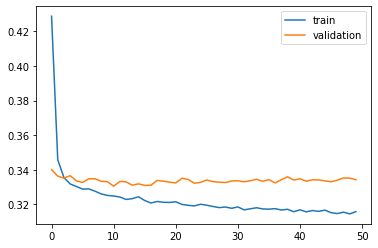

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4721125680265211
Dropout rate 2: 0.41250462660738674
Fold: 3
Best val loss: 0.33048838069703845
#################################
Time to train MLP:  278.3977379798889
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 19s - loss: 0.3915 - acc: 0.8628 - val_loss: 0.3347 - val_acc: 0.8749

Epoch 00001: val_loss improved from inf to 0.33467, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3433 - acc: 0.8724 - val_loss: 0.3270 - val_acc: 0.8758

Epoch 00002: val_loss improved from 0.33467 to 0.32696, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3364 - acc: 0.8740 - val_loss: 0.3238 - val_acc: 0.8749

Epoch 00003: val_loss improved from 0.32696 to 0.32379, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3339 - acc: 0.8746 - val_loss: 0.3232 - val_acc: 0.8757

Epoch 00004: val_loss improved from 0.32379 to 0.32315, saving model to MLP_val_weig

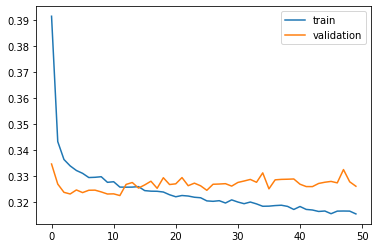

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4721125680265211
Dropout rate 2: 0.41250462660738674
Fold: 4
Best val loss: 0.32254811996883814
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414


Epoch 00022: val_loss did not improve from 0.31914
Epoch 23/50
 - 5s - loss: 0.3136 - acc: 0.8788 - val_loss: 0.3280 - val_acc: 0.8797

Epoch 00023: val_loss did not improve from 0.31914
Epoch 24/50
 - 5s - loss: 0.3141 - acc: 0.8785 - val_loss: 0.3289 - val_acc: 0.8799

Epoch 00024: val_loss did not improve from 0.31914
Epoch 25/50
 - 5s - loss: 0.3136 - acc: 0.8796 - val_loss: 0.3323 - val_acc: 0.8780

Epoch 00025: val_loss did not improve from 0.31914
Epoch 26/50
 - 5s - loss: 0.3140 - acc: 0.8790 - val_loss: 0.3290 - val_acc: 0.8784

Epoch 00026: val_loss did not improve from 0.31914
Epoch 27/50
 - 5s - loss: 0.3125 - acc: 0.8797 - val_loss: 0.3292 - val_acc: 0.8791

Epoch 00027: val_loss did not improve from 0.31914
Epoch 28/50
 - 5s - loss: 0.3122 - acc: 0.8800 - val_loss: 0.3321 - val_acc: 0.8786

Epoch 00028: val_loss did not improve from 0.31914
Epoch 29/50
 - 5s - loss: 0.3111 - acc: 0.8795 - val_loss: 0.3309 - val_acc: 0.8800

Epoch 00029: val_loss did not improve from 0.31

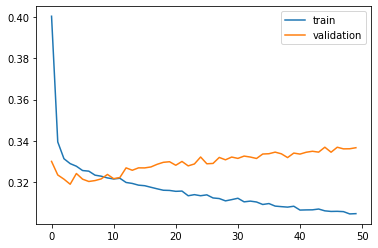

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4263677705546425
Dropout rate 2: 0.20332015090333083
Fold: 0
Best val loss: 0.31913511281543305
#################################
Time to train MLP:  281.62825417518616
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 19s - loss: 0.3755 - acc: 0.8660 - val_loss: 0.3343 - val_acc: 0.8726

Epoch 00001: val_loss improved from inf to 0.33429, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3361 - acc: 0.8744 - val_loss: 0.3295 - val_acc: 0.8749

Epoch 00002: val_loss improved from 0.33429 to 0.32945, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3297 - acc: 0.8753 - val_loss: 0.3290 - val_acc: 0.8753

Epoch 00003: val_loss improved from 0.32945 to 0.32905, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3281 - acc: 0.8755 - val_loss: 0.3266 - val_acc: 0.8757

Epoch 00004: val_loss improved from 0.32905 to 0.32660, saving model to MLP_val_wei

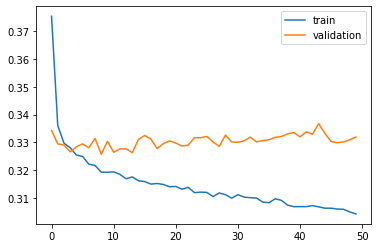

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4263677705546425
Dropout rate 2: 0.20332015090333083
Fold: 1
Best val loss: 0.3257371796237098
#################################
Time to train MLP:  282.8034906387329
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 19s - loss: 0.3731 - acc: 0.8694 - val_loss: 0.3371 - val_acc: 0.8710

Epoch 00001: val_loss improved from inf to 0.33706, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3397 - acc: 0.8737 - val_loss: 0.3304 - val_acc: 0.8732

Epoch 00002: val_loss improved from 0.33706 to 0.33041, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3331 - acc: 0.8743 - val_loss: 0.3312 - val_acc: 0.8726

Epoch 00003: val_loss did not improve from 0.33041
Epoch 4/50
 - 5s - loss: 0.3302 - acc: 0.8748 - val_loss: 0.3301 - val_acc: 0.8731

Epoch 00004: val_loss improved from 0.33041 to 0.33008, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 5s - loss: 0.3287 - 

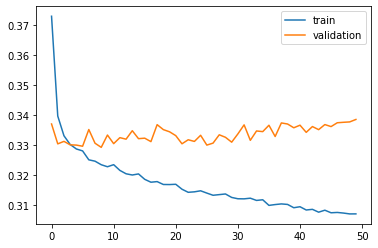

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4263677705546425
Dropout rate 2: 0.20332015090333083
Fold: 2
Best val loss: 0.32924000562561884
#################################
Time to train MLP:  284.23764872550964
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 19s - loss: 0.3737 - acc: 0.8652 - val_loss: 0.3358 - val_acc: 0.8682

Epoch 00001: val_loss improved from inf to 0.33581, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3343 - acc: 0.8746 - val_loss: 0.3301 - val_acc: 0.8700

Epoch 00002: val_loss improved from 0.33581 to 0.33007, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3279 - acc: 0.8759 - val_loss: 0.3323 - val_acc: 0.8696

Epoch 00003: val_loss did not improve from 0.33007
Epoch 4/50
 - 5s - loss: 0.3252 - acc: 0.8769 - val_loss: 0.3305 - val_acc: 0.8694

Epoch 00004: val_loss did not improve from 0.33007
Epoch 5/50
 - 5s - loss: 0.3231 - acc: 0.8772 - val_loss: 0.3308 - val_acc

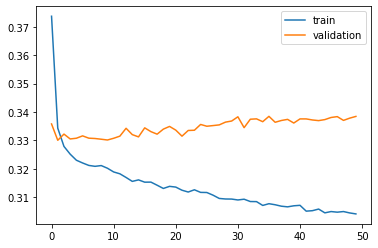

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4263677705546425
Dropout rate 2: 0.20332015090333083
Fold: 3
Best val loss: 0.3300725911723243
#################################
Time to train MLP:  286.8793742656708
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 20s - loss: 0.4040 - acc: 0.8607 - val_loss: 0.3348 - val_acc: 0.8761

Epoch 00001: val_loss improved from inf to 0.33476, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3429 - acc: 0.8740 - val_loss: 0.3269 - val_acc: 0.8769

Epoch 00002: val_loss improved from 0.33476 to 0.32692, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3322 - acc: 0.8752 - val_loss: 0.3254 - val_acc: 0.8764

Epoch 00003: val_loss improved from 0.32692 to 0.32538, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3283 - acc: 0.8762 - val_loss: 0.3235 - val_acc: 0.8771

Epoch 00004: val_loss improved from 0.32538 to 0.32346, saving model to MLP_val_weigh

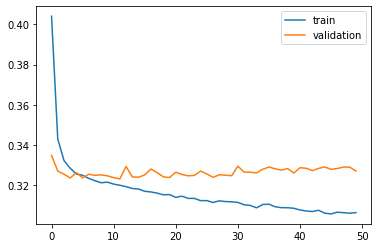

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.4263677705546425
Dropout rate 2: 0.20332015090333083
Fold: 4
Best val loss: 0.3230105776786804
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.408084149

 - 5s - loss: 0.2862 - acc: 0.8923 - val_loss: 0.3598 - val_acc: 0.8764

Epoch 00020: val_loss did not improve from 0.31885
Epoch 21/50
 - 6s - loss: 0.2844 - acc: 0.8931 - val_loss: 0.3628 - val_acc: 0.8758

Epoch 00021: val_loss did not improve from 0.31885
Epoch 22/50
 - 5s - loss: 0.2830 - acc: 0.8940 - val_loss: 0.3641 - val_acc: 0.8770

Epoch 00022: val_loss did not improve from 0.31885
Epoch 23/50
 - 5s - loss: 0.2806 - acc: 0.8954 - val_loss: 0.3687 - val_acc: 0.8766

Epoch 00023: val_loss did not improve from 0.31885
Epoch 24/50
 - 5s - loss: 0.2816 - acc: 0.8948 - val_loss: 0.3687 - val_acc: 0.8760

Epoch 00024: val_loss did not improve from 0.31885
Epoch 25/50
 - 5s - loss: 0.2806 - acc: 0.8952 - val_loss: 0.3681 - val_acc: 0.8769

Epoch 00025: val_loss did not improve from 0.31885
Epoch 26/50
 - 5s - loss: 0.2786 - acc: 0.8957 - val_loss: 0.3676 - val_acc: 0.8771

Epoch 00026: val_loss did not improve from 0.31885
Epoch 27/50
 - 5s - loss: 0.2783 - acc: 0.8966 - val_loss: 0

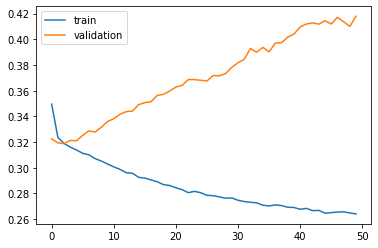

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.0011296167592567685
Dropout rate 2: 0.22565420571065714
Fold: 0
Best val loss: 0.31885435973273385
#################################
Time to train MLP:  291.7112274169922
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 21s - loss: 0.3544 - acc: 0.8695 - val_loss: 0.3304 - val_acc: 0.8720

Epoch 00001: val_loss improved from inf to 0.33044, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 5s - loss: 0.3267 - acc: 0.8762 - val_loss: 0.3284 - val_acc: 0.8732

Epoch 00002: val_loss improved from 0.33044 to 0.32839, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 5s - loss: 0.3205 - acc: 0.8782 - val_loss: 0.3271 - val_acc: 0.8738

Epoch 00003: val_loss improved from 0.32839 to 0.32707, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 5s - loss: 0.3165 - acc: 0.8797 - val_loss: 0.3265 - val_acc: 0.8729

Epoch 00004: val_loss improved from 0.32707 to 0.32649, saving model to MLP_val_w

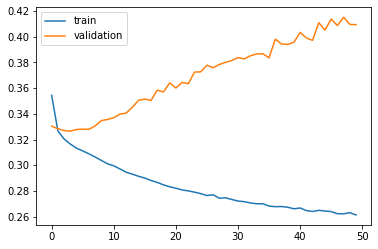

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.0011296167592567685
Dropout rate 2: 0.22565420571065714
Fold: 1
Best val loss: 0.326488552014033
#################################
Time to train MLP:  295.0879530906677
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 20s - loss: 0.3478 - acc: 0.8697 - val_loss: 0.3298 - val_acc: 0.8704

Epoch 00001: val_loss improved from inf to 0.32984, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3273 - acc: 0.8732 - val_loss: 0.3275 - val_acc: 0.8760

Epoch 00002: val_loss improved from 0.32984 to 0.32746, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3194 - acc: 0.8766 - val_loss: 0.3295 - val_acc: 0.8752

Epoch 00003: val_loss did not improve from 0.32746
Epoch 4/50
 - 6s - loss: 0.3161 - acc: 0.8788 - val_loss: 0.3290 - val_acc: 0.8757

Epoch 00004: val_loss did not improve from 0.32746
Epoch 5/50
 - 6s - loss: 0.3130 - acc: 0.8800 - val_loss: 0.3292 - val_acc

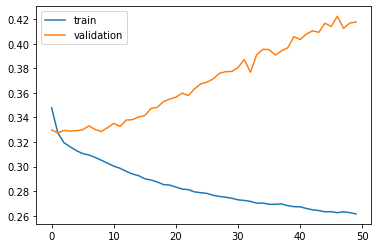

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.0011296167592567685
Dropout rate 2: 0.22565420571065714
Fold: 2
Best val loss: 0.3274574817551507
#################################
Time to train MLP:  295.67398142814636
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 21s - loss: 0.3689 - acc: 0.8696 - val_loss: 0.3316 - val_acc: 0.8713

Epoch 00001: val_loss improved from inf to 0.33160, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3297 - acc: 0.8772 - val_loss: 0.3303 - val_acc: 0.8698

Epoch 00002: val_loss improved from 0.33160 to 0.33032, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3218 - acc: 0.8788 - val_loss: 0.3300 - val_acc: 0.8702

Epoch 00003: val_loss improved from 0.33032 to 0.32999, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3204 - acc: 0.8791 - val_loss: 0.3300 - val_acc: 0.8701

Epoch 00004: val_loss improved from 0.32999 to 0.32999, saving model to MLP_val_w

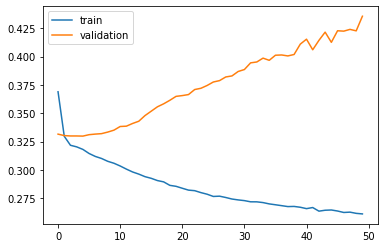

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.0011296167592567685
Dropout rate 2: 0.22565420571065714
Fold: 3
Best val loss: 0.3298671326637268
#################################
Time to train MLP:  297.6803262233734
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 22s - loss: 0.3512 - acc: 0.8705 - val_loss: 0.3241 - val_acc: 0.8782

Epoch 00001: val_loss improved from inf to 0.32407, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3253 - acc: 0.8764 - val_loss: 0.3235 - val_acc: 0.8786

Epoch 00002: val_loss improved from 0.32407 to 0.32354, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3195 - acc: 0.8775 - val_loss: 0.3229 - val_acc: 0.8794

Epoch 00003: val_loss improved from 0.32354 to 0.32286, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3162 - acc: 0.8790 - val_loss: 0.3240 - val_acc: 0.8783

Epoch 00004: val_loss did not improve from 0.32286
Epoch 5/50
 - 6s - loss: 0.3143

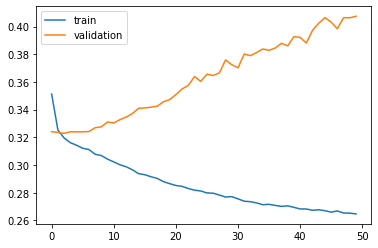

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.0011296167592567685
Dropout rate 2: 0.22565420571065714
Fold: 4
Best val loss: 0.32285622848404777
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808

 - 5s - loss: 0.3118 - acc: 0.8806 - val_loss: 0.3258 - val_acc: 0.8794

Epoch 00016: val_loss did not improve from 0.31976
Epoch 17/50
 - 6s - loss: 0.3115 - acc: 0.8803 - val_loss: 0.3267 - val_acc: 0.8796

Epoch 00017: val_loss did not improve from 0.31976
Epoch 18/50
 - 6s - loss: 0.3092 - acc: 0.8812 - val_loss: 0.3288 - val_acc: 0.8803

Epoch 00018: val_loss did not improve from 0.31976
Epoch 19/50
 - 6s - loss: 0.3091 - acc: 0.8808 - val_loss: 0.3288 - val_acc: 0.8801

Epoch 00019: val_loss did not improve from 0.31976
Epoch 20/50
 - 6s - loss: 0.3073 - acc: 0.8826 - val_loss: 0.3296 - val_acc: 0.8791

Epoch 00020: val_loss did not improve from 0.31976
Epoch 21/50
 - 6s - loss: 0.3081 - acc: 0.8816 - val_loss: 0.3306 - val_acc: 0.8797

Epoch 00021: val_loss did not improve from 0.31976
Epoch 22/50
 - 6s - loss: 0.3069 - acc: 0.8819 - val_loss: 0.3297 - val_acc: 0.8791

Epoch 00022: val_loss did not improve from 0.31976
Epoch 23/50
 - 6s - loss: 0.3052 - acc: 0.8830 - val_loss: 0

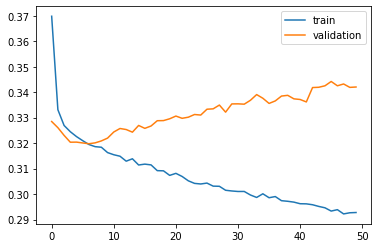

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.26061301361014644
Dropout rate 2: 0.20031581368083679
Fold: 0
Best val loss: 0.3197565063105689
#################################
Time to train MLP:  308.7627024650574
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 22s - loss: 0.3800 - acc: 0.8604 - val_loss: 0.3290 - val_acc: 0.8743

Epoch 00001: val_loss improved from inf to 0.32902, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3341 - acc: 0.8750 - val_loss: 0.3292 - val_acc: 0.8738

Epoch 00002: val_loss did not improve from 0.32902
Epoch 3/50
 - 6s - loss: 0.3268 - acc: 0.8757 - val_loss: 0.3259 - val_acc: 0.8756

Epoch 00003: val_loss improved from 0.32902 to 0.32594, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3224 - acc: 0.8774 - val_loss: 0.3247 - val_acc: 0.8754

Epoch 00004: val_loss improved from 0.32594 to 0.32468, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 6s - loss: 0.3217 -

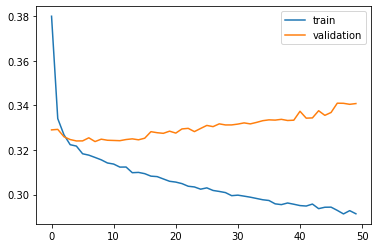

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.26061301361014644
Dropout rate 2: 0.20031581368083679
Fold: 1
Best val loss: 0.32377512023184035
#################################
Time to train MLP:  303.96643924713135
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 34s - loss: 0.4189 - acc: 0.8542 - val_loss: 0.3315 - val_acc: 0.8741

Epoch 00001: val_loss improved from inf to 0.33148, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3343 - acc: 0.8751 - val_loss: 0.3301 - val_acc: 0.8753

Epoch 00002: val_loss improved from 0.33148 to 0.33007, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3265 - acc: 0.8764 - val_loss: 0.3261 - val_acc: 0.8750

Epoch 00003: val_loss improved from 0.33007 to 0.32610, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3220 - acc: 0.8771 - val_loss: 0.3244 - val_acc: 0.8758

Epoch 00004: val_loss improved from 0.32610 to 0.32441, saving model to MLP_val_we

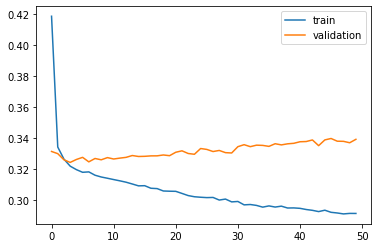

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.26061301361014644
Dropout rate 2: 0.20031581368083679
Fold: 2
Best val loss: 0.32441161849763656
#################################
Time to train MLP:  316.55839586257935
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 28s - loss: 0.3916 - acc: 0.8614 - val_loss: 0.3337 - val_acc: 0.8684

Epoch 00001: val_loss improved from inf to 0.33366, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3372 - acc: 0.8757 - val_loss: 0.3289 - val_acc: 0.8702

Epoch 00002: val_loss improved from 0.33366 to 0.32894, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3281 - acc: 0.8766 - val_loss: 0.3280 - val_acc: 0.8708

Epoch 00003: val_loss improved from 0.32894 to 0.32804, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3235 - acc: 0.8774 - val_loss: 0.3286 - val_acc: 0.8682

Epoch 00004: val_loss did not improve from 0.32804
Epoch 5/50
 - 6s - loss: 0.3209

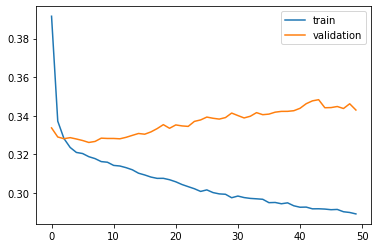

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.26061301361014644
Dropout rate 2: 0.20031581368083679
Fold: 3
Best val loss: 0.32609393225775823
#################################
Time to train MLP:  317.3477144241333
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 32s - loss: 0.3635 - acc: 0.8680 - val_loss: 0.3295 - val_acc: 0.8760

Epoch 00001: val_loss improved from inf to 0.32952, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3305 - acc: 0.8752 - val_loss: 0.3223 - val_acc: 0.8777

Epoch 00002: val_loss improved from 0.32952 to 0.32234, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3250 - acc: 0.8766 - val_loss: 0.3208 - val_acc: 0.8773

Epoch 00003: val_loss improved from 0.32234 to 0.32083, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3222 - acc: 0.8776 - val_loss: 0.3200 - val_acc: 0.8772

Epoch 00004: val_loss improved from 0.32083 to 0.32000, saving model to MLP_val_wei

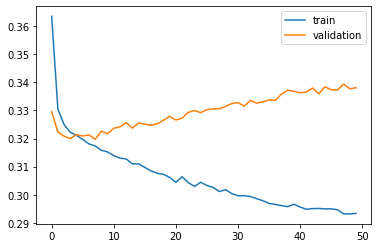

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.26061301361014644
Dropout rate 2: 0.20031581368083679
Fold: 4
Best val loss: 0.3197466779814826
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414

 - 6s - loss: 0.3209 - acc: 0.8776 - val_loss: 0.3265 - val_acc: 0.8812

Epoch 00014: val_loss did not improve from 0.31791
Epoch 15/50
 - 6s - loss: 0.3199 - acc: 0.8779 - val_loss: 0.3272 - val_acc: 0.8797

Epoch 00015: val_loss did not improve from 0.31791
Epoch 16/50
 - 6s - loss: 0.3190 - acc: 0.8776 - val_loss: 0.3271 - val_acc: 0.8816

Epoch 00016: val_loss did not improve from 0.31791
Epoch 17/50
 - 6s - loss: 0.3183 - acc: 0.8783 - val_loss: 0.3278 - val_acc: 0.8787

Epoch 00017: val_loss did not improve from 0.31791
Epoch 18/50
 - 6s - loss: 0.3168 - acc: 0.8788 - val_loss: 0.3290 - val_acc: 0.8811

Epoch 00018: val_loss did not improve from 0.31791
Epoch 19/50
 - 6s - loss: 0.3169 - acc: 0.8785 - val_loss: 0.3250 - val_acc: 0.8824

Epoch 00019: val_loss did not improve from 0.31791
Epoch 20/50
 - 6s - loss: 0.3147 - acc: 0.8789 - val_loss: 0.3302 - val_acc: 0.8812

Epoch 00020: val_loss did not improve from 0.31791
Epoch 21/50
 - 6s - loss: 0.3147 - acc: 0.8789 - val_loss: 0

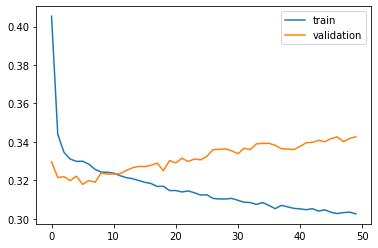

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.2760188166322833
Dropout rate 2: 0.49756908016927925
Fold: 0
Best val loss: 0.3179132391081916
#################################
Time to train MLP:  315.4856045246124
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 43s - loss: 0.4667 - acc: 0.8406 - val_loss: 0.3334 - val_acc: 0.8757

Epoch 00001: val_loss improved from inf to 0.33340, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3462 - acc: 0.8736 - val_loss: 0.3280 - val_acc: 0.8747

Epoch 00002: val_loss improved from 0.33340 to 0.32795, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3346 - acc: 0.8757 - val_loss: 0.3257 - val_acc: 0.8766

Epoch 00003: val_loss improved from 0.32795 to 0.32566, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3308 - acc: 0.8756 - val_loss: 0.3251 - val_acc: 0.8757

Epoch 00004: val_loss improved from 0.32566 to 0.32509, saving model to MLP_val_weigh

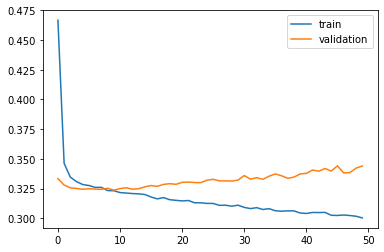

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.2760188166322833
Dropout rate 2: 0.49756908016927925
Fold: 1
Best val loss: 0.32366892382833695
#################################
Time to train MLP:  336.63595151901245
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 26s - loss: 0.3715 - acc: 0.8684 - val_loss: 0.3304 - val_acc: 0.8707

Epoch 00001: val_loss improved from inf to 0.33042, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3371 - acc: 0.8733 - val_loss: 0.3272 - val_acc: 0.8734

Epoch 00002: val_loss improved from 0.33042 to 0.32721, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3313 - acc: 0.8743 - val_loss: 0.3290 - val_acc: 0.8730

Epoch 00003: val_loss did not improve from 0.32721
Epoch 4/50
 - 6s - loss: 0.3276 - acc: 0.8757 - val_loss: 0.3268 - val_acc: 0.8751

Epoch 00004: val_loss improved from 0.32721 to 0.32683, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 6s - loss: 0.3259 

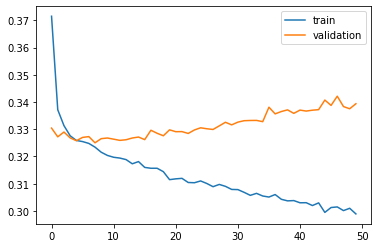

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.2760188166322833
Dropout rate 2: 0.49756908016927925
Fold: 2
Best val loss: 0.3250280370447371
#################################
Time to train MLP:  320.78835368156433
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 34s - loss: 0.4232 - acc: 0.8553 - val_loss: 0.3377 - val_acc: 0.8699

Epoch 00001: val_loss improved from inf to 0.33768, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3421 - acc: 0.8758 - val_loss: 0.3325 - val_acc: 0.8691

Epoch 00002: val_loss improved from 0.33768 to 0.33253, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3325 - acc: 0.8760 - val_loss: 0.3308 - val_acc: 0.8696

Epoch 00003: val_loss improved from 0.33253 to 0.33080, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3289 - acc: 0.8765 - val_loss: 0.3288 - val_acc: 0.8709

Epoch 00004: val_loss improved from 0.33080 to 0.32885, saving model to MLP_val_weig

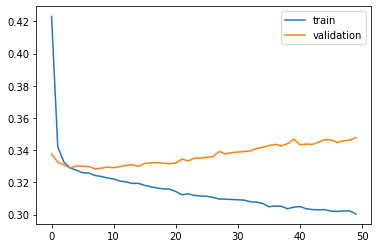

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.2760188166322833
Dropout rate 2: 0.49756908016927925
Fold: 3
Best val loss: 0.32833261643515693
#################################
Time to train MLP:  333.64368295669556
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 28s - loss: 0.4442 - acc: 0.8486 - val_loss: 0.3323 - val_acc: 0.8759

Epoch 00001: val_loss improved from inf to 0.33226, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3463 - acc: 0.8746 - val_loss: 0.3251 - val_acc: 0.8757

Epoch 00002: val_loss improved from 0.33226 to 0.32505, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3352 - acc: 0.8747 - val_loss: 0.3271 - val_acc: 0.8746

Epoch 00003: val_loss did not improve from 0.32505
Epoch 4/50
 - 6s - loss: 0.3315 - acc: 0.8753 - val_loss: 0.3248 - val_acc: 0.8760

Epoch 00004: val_loss improved from 0.32505 to 0.32485, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 6s - loss: 0.3309 

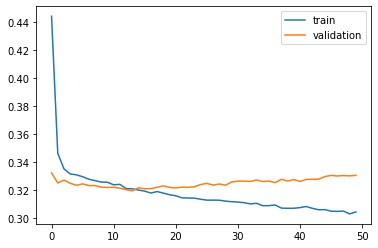

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.2760188166322833
Dropout rate 2: 0.49756908016927925
Fold: 4
Best val loss: 0.31944876612557305
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414

 - 6s - loss: 0.3099 - acc: 0.8806 - val_loss: 0.3219 - val_acc: 0.8812

Epoch 00011: val_loss did not improve from 0.31633
Epoch 12/50
 - 6s - loss: 0.3104 - acc: 0.8804 - val_loss: 0.3219 - val_acc: 0.8812

Epoch 00012: val_loss did not improve from 0.31633
Epoch 13/50
 - 6s - loss: 0.3091 - acc: 0.8814 - val_loss: 0.3231 - val_acc: 0.8811

Epoch 00013: val_loss did not improve from 0.31633
Epoch 14/50
 - 6s - loss: 0.3076 - acc: 0.8814 - val_loss: 0.3248 - val_acc: 0.8808

Epoch 00014: val_loss did not improve from 0.31633
Epoch 15/50
 - 6s - loss: 0.3062 - acc: 0.8820 - val_loss: 0.3262 - val_acc: 0.8803

Epoch 00015: val_loss did not improve from 0.31633
Epoch 16/50
 - 6s - loss: 0.3059 - acc: 0.8821 - val_loss: 0.3282 - val_acc: 0.8803

Epoch 00016: val_loss did not improve from 0.31633
Epoch 17/50
 - 6s - loss: 0.3046 - acc: 0.8833 - val_loss: 0.3283 - val_acc: 0.8808

Epoch 00017: val_loss did not improve from 0.31633
Epoch 18/50
 - 6s - loss: 0.3047 - acc: 0.8831 - val_loss: 0

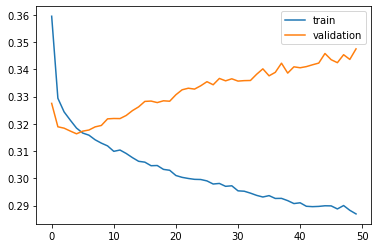

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.24268870683135485
Dropout rate 2: 0.08878208796894466
Fold: 0
Best val loss: 0.3163298938009474
#################################
Time to train MLP:  333.02549171447754
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 27s - loss: 0.3519 - acc: 0.8707 - val_loss: 0.3312 - val_acc: 0.8748

Epoch 00001: val_loss improved from inf to 0.33118, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3289 - acc: 0.8757 - val_loss: 0.3284 - val_acc: 0.8750

Epoch 00002: val_loss improved from 0.33118 to 0.32840, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3238 - acc: 0.8767 - val_loss: 0.3253 - val_acc: 0.8749

Epoch 00003: val_loss improved from 0.32840 to 0.32531, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3205 - acc: 0.8769 - val_loss: 0.3257 - val_acc: 0.8742

Epoch 00004: val_loss did not improve from 0.32531
Epoch 5/50
 - 6s - loss: 0.3197 

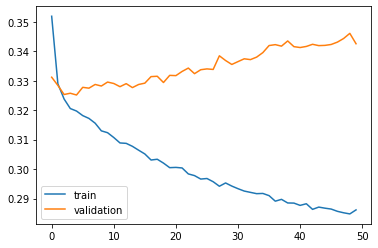

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.24268870683135485
Dropout rate 2: 0.08878208796894466
Fold: 1
Best val loss: 0.32514399978849623
#################################
Time to train MLP:  328.90013670921326
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 24s - loss: 0.3769 - acc: 0.8614 - val_loss: 0.3285 - val_acc: 0.8748

Epoch 00001: val_loss improved from inf to 0.32852, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3299 - acc: 0.8764 - val_loss: 0.3262 - val_acc: 0.8749

Epoch 00002: val_loss improved from 0.32852 to 0.32622, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3232 - acc: 0.8773 - val_loss: 0.3247 - val_acc: 0.8759

Epoch 00003: val_loss improved from 0.32622 to 0.32465, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3197 - acc: 0.8776 - val_loss: 0.3255 - val_acc: 0.8768

Epoch 00004: val_loss did not improve from 0.32465
Epoch 5/50
 - 6s - loss: 0.3177

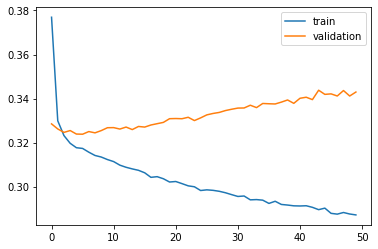

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.24268870683135485
Dropout rate 2: 0.08878208796894466
Fold: 2
Best val loss: 0.32382959132724337
#################################
Time to train MLP:  307.64284491539
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 31s - loss: 0.3653 - acc: 0.8669 - val_loss: 0.3328 - val_acc: 0.8692

Epoch 00001: val_loss improved from inf to 0.33284, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3312 - acc: 0.8759 - val_loss: 0.3313 - val_acc: 0.8691

Epoch 00002: val_loss improved from 0.33284 to 0.33134, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3217 - acc: 0.8784 - val_loss: 0.3285 - val_acc: 0.8701

Epoch 00003: val_loss improved from 0.33134 to 0.32850, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3204 - acc: 0.8781 - val_loss: 0.3284 - val_acc: 0.8707

Epoch 00004: val_loss improved from 0.32850 to 0.32841, saving model to MLP_val_weigh

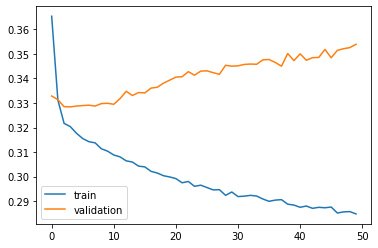

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.24268870683135485
Dropout rate 2: 0.08878208796894466
Fold: 3
Best val loss: 0.3284146672619714
#################################
Time to train MLP:  344.0550525188446
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 35s - loss: 0.3567 - acc: 0.8696 - val_loss: 0.3236 - val_acc: 0.8774

Epoch 00001: val_loss improved from inf to 0.32358, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3274 - acc: 0.8761 - val_loss: 0.3218 - val_acc: 0.8776

Epoch 00002: val_loss improved from 0.32358 to 0.32185, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3238 - acc: 0.8769 - val_loss: 0.3212 - val_acc: 0.8773

Epoch 00003: val_loss improved from 0.32185 to 0.32116, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3213 - acc: 0.8773 - val_loss: 0.3212 - val_acc: 0.8777

Epoch 00004: val_loss did not improve from 0.32116
Epoch 5/50
 - 6s - loss: 0.3190 -

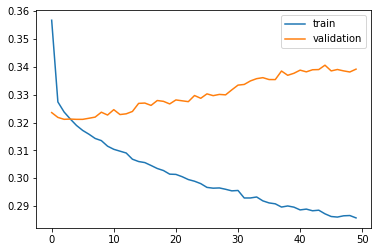

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.24268870683135485
Dropout rate 2: 0.08878208796894466
Fold: 4
Best val loss: 0.32115079045295714
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.4080841


Epoch 00007: val_loss did not improve from 0.31963
Epoch 8/50
 - 6s - loss: 0.3286 - acc: 0.8756 - val_loss: 0.3208 - val_acc: 0.8773

Epoch 00008: val_loss did not improve from 0.31963
Epoch 9/50
 - 6s - loss: 0.3279 - acc: 0.8759 - val_loss: 0.3203 - val_acc: 0.8779

Epoch 00009: val_loss did not improve from 0.31963
Epoch 10/50
 - 6s - loss: 0.3259 - acc: 0.8758 - val_loss: 0.3224 - val_acc: 0.8788

Epoch 00010: val_loss did not improve from 0.31963
Epoch 11/50
 - 6s - loss: 0.3265 - acc: 0.8762 - val_loss: 0.3224 - val_acc: 0.8777

Epoch 00011: val_loss did not improve from 0.31963
Epoch 12/50
 - 6s - loss: 0.3258 - acc: 0.8758 - val_loss: 0.3267 - val_acc: 0.8772

Epoch 00012: val_loss did not improve from 0.31963
Epoch 13/50
 - 6s - loss: 0.3244 - acc: 0.8760 - val_loss: 0.3230 - val_acc: 0.8784

Epoch 00013: val_loss did not improve from 0.31963
Epoch 14/50
 - 6s - loss: 0.3239 - acc: 0.8763 - val_loss: 0.3238 - val_acc: 0.8781

Epoch 00014: val_loss did not improve from 0.3196

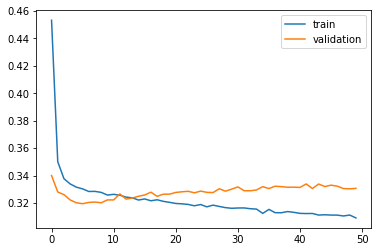

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.38406707703221116
Dropout rate 2: 0.48129845151392514
Fold: 0
Best val loss: 0.31962767322858177
#################################
Time to train MLP:  354.63988971710205
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 30s - loss: 0.4486 - acc: 0.8573 - val_loss: 0.3416 - val_acc: 0.8719

Epoch 00001: val_loss improved from inf to 0.34164, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3558 - acc: 0.8736 - val_loss: 0.3355 - val_acc: 0.8727

Epoch 00002: val_loss improved from 0.34164 to 0.33546, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 6s - loss: 0.3392 - acc: 0.8749 - val_loss: 0.3310 - val_acc: 0.8731

Epoch 00003: val_loss improved from 0.33546 to 0.33096, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3365 - acc: 0.8748 - val_loss: 0.3277 - val_acc: 0.8756

Epoch 00004: val_loss improved from 0.33096 to 0.32771, saving model to MLP_val_we

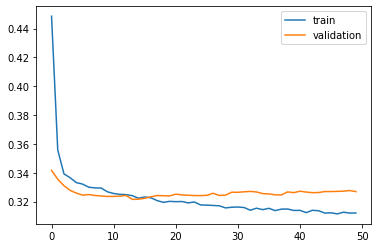

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.38406707703221116
Dropout rate 2: 0.48129845151392514
Fold: 1
Best val loss: 0.321490025361379
#################################
Time to train MLP:  352.75294375419617
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 43s - loss: 0.4058 - acc: 0.8672 - val_loss: 0.3351 - val_acc: 0.8724

Epoch 00001: val_loss improved from inf to 0.33513, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3444 - acc: 0.8743 - val_loss: 0.3283 - val_acc: 0.8734

Epoch 00002: val_loss improved from 0.33513 to 0.32834, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3360 - acc: 0.8743 - val_loss: 0.3281 - val_acc: 0.8737

Epoch 00003: val_loss improved from 0.32834 to 0.32811, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3325 - acc: 0.8749 - val_loss: 0.3257 - val_acc: 0.8742

Epoch 00004: val_loss improved from 0.32811 to 0.32572, saving model to MLP_val_weig

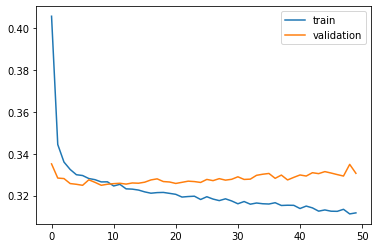

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.38406707703221116
Dropout rate 2: 0.48129845151392514
Fold: 2
Best val loss: 0.3248827610280779
#################################
Time to train MLP:  364.26724791526794
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 30s - loss: 0.4057 - acc: 0.8610 - val_loss: 0.3427 - val_acc: 0.8661

Epoch 00001: val_loss improved from inf to 0.34269, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 6s - loss: 0.3446 - acc: 0.8731 - val_loss: 0.3347 - val_acc: 0.8667

Epoch 00002: val_loss improved from 0.34269 to 0.33473, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3376 - acc: 0.8747 - val_loss: 0.3331 - val_acc: 0.8664

Epoch 00003: val_loss improved from 0.33473 to 0.33311, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3342 - acc: 0.8745 - val_loss: 0.3307 - val_acc: 0.8682

Epoch 00004: val_loss improved from 0.33311 to 0.33068, saving model to MLP_val_wei

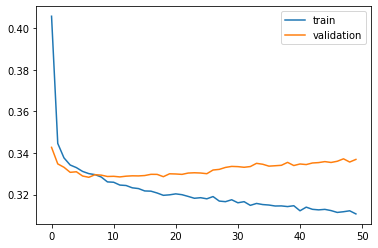

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.38406707703221116
Dropout rate 2: 0.48129845151392514
Fold: 3
Best val loss: 0.3282875286208259
#################################
Time to train MLP:  353.1204752922058
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 27s - loss: 0.4238 - acc: 0.8571 - val_loss: 0.3406 - val_acc: 0.8736

Epoch 00001: val_loss improved from inf to 0.34057, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3503 - acc: 0.8721 - val_loss: 0.3347 - val_acc: 0.8736

Epoch 00002: val_loss improved from 0.34057 to 0.33474, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3441 - acc: 0.8723 - val_loss: 0.3334 - val_acc: 0.8736

Epoch 00003: val_loss improved from 0.33474 to 0.33338, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 6s - loss: 0.3402 - acc: 0.8724 - val_loss: 0.3329 - val_acc: 0.8736

Epoch 00004: val_loss improved from 0.33338 to 0.33285, saving model to MLP_val_weig

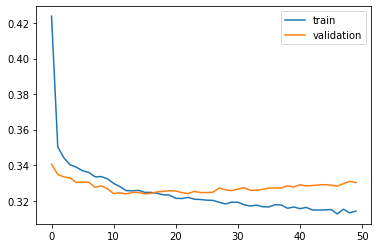

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.38406707703221116
Dropout rate 2: 0.48129845151392514
Fold: 4
Best val loss: 0.32381629469659595
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.4080841

 - 7s - loss: 0.3148 - acc: 0.8785 - val_loss: 0.3252 - val_acc: 0.8804

Epoch 00006: val_loss did not improve from 0.31890
Epoch 7/50
 - 7s - loss: 0.3127 - acc: 0.8795 - val_loss: 0.3245 - val_acc: 0.8802

Epoch 00007: val_loss did not improve from 0.31890
Epoch 8/50
 - 7s - loss: 0.3109 - acc: 0.8792 - val_loss: 0.3300 - val_acc: 0.8817

Epoch 00008: val_loss did not improve from 0.31890
Epoch 9/50
 - 7s - loss: 0.3100 - acc: 0.8795 - val_loss: 0.3294 - val_acc: 0.8822

Epoch 00009: val_loss did not improve from 0.31890
Epoch 10/50
 - 7s - loss: 0.3071 - acc: 0.8808 - val_loss: 0.3343 - val_acc: 0.8824

Epoch 00010: val_loss did not improve from 0.31890
Epoch 11/50
 - 7s - loss: 0.3055 - acc: 0.8811 - val_loss: 0.3345 - val_acc: 0.8811

Epoch 00011: val_loss did not improve from 0.31890
Epoch 12/50
 - 7s - loss: 0.3030 - acc: 0.8830 - val_loss: 0.3390 - val_acc: 0.8810

Epoch 00012: val_loss did not improve from 0.31890
Epoch 13/50
 - 7s - loss: 0.3027 - acc: 0.8826 - val_loss: 0.33

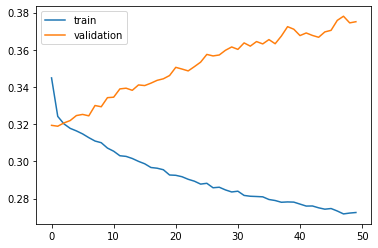

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.08035837656278505
Dropout rate 2: 0.2096251351295531
Fold: 0
Best val loss: 0.3188981132507324
#################################
Time to train MLP:  379.23663449287415
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 38s - loss: 0.3536 - acc: 0.8703 - val_loss: 0.3317 - val_acc: 0.8747

Epoch 00001: val_loss improved from inf to 0.33169, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3274 - acc: 0.8753 - val_loss: 0.3290 - val_acc: 0.8758

Epoch 00002: val_loss improved from 0.33169 to 0.32897, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3210 - acc: 0.8770 - val_loss: 0.3285 - val_acc: 0.8742

Epoch 00003: val_loss improved from 0.32897 to 0.32853, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3186 - acc: 0.8775 - val_loss: 0.3278 - val_acc: 0.8743

Epoch 00004: val_loss improved from 0.32853 to 0.32780, saving model to MLP_val_weig

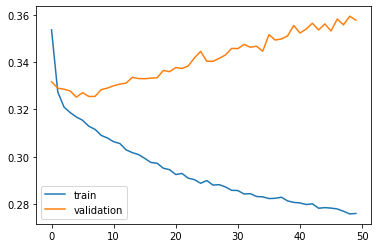

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.08035837656278505
Dropout rate 2: 0.2096251351295531
Fold: 1
Best val loss: 0.32517150280210705
#################################
Time to train MLP:  367.6866283416748


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f65e4c85da0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f65e4c85eb8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 30s - loss: 0.3867 - acc: 0.8609 - val_loss: 0.3297 - val_acc: 0.8743

Epoch 00001: val_loss improved from inf to 0.32966, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3306 - acc: 0.8760 - val_loss: 0.3245 - val_acc: 0.8770

Epoch 00002: val_loss improved from 0.32966 to 0.32452, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3237 - acc: 0.8773 - val_loss: 0.3244 - val_acc: 0.8767

Epoch 00003: val_loss improved from 0.32452 to 0.32443, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3204 - acc: 0.8782 - val_loss: 0.3235 - val_acc: 0.8763

Epoch 00004: val_loss improved from 0.32443 to 0.32348, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3171 - acc: 0.8793 - val_loss: 0.3234 - val_acc: 0.8762

Epoch 00005: val_loss improved from 0.32348 to 0.32336, saving model to MLP_val_weights.hdf5
Epoch 6/50
 - 7s - loss: 0.3149 - acc: 0.8799 - val_loss: 0.3244 - va

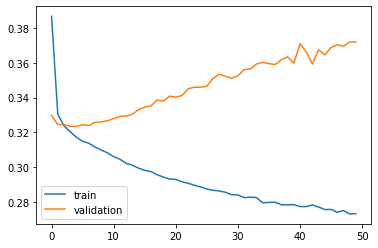

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.08035837656278505
Dropout rate 2: 0.2096251351295531
Fold: 2
Best val loss: 0.32335852829615275
#################################
Time to train MLP:  363.3145477771759
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 30s - loss: 0.3611 - acc: 0.8659 - val_loss: 0.3296 - val_acc: 0.8707

Epoch 00001: val_loss improved from inf to 0.32958, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3271 - acc: 0.8765 - val_loss: 0.3280 - val_acc: 0.8729

Epoch 00002: val_loss improved from 0.32958 to 0.32795, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3216 - acc: 0.8782 - val_loss: 0.3275 - val_acc: 0.8720

Epoch 00003: val_loss improved from 0.32795 to 0.32747, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3191 - acc: 0.8792 - val_loss: 0.3283 - val_acc: 0.8713

Epoch 00004: val_loss did not improve from 0.32747
Epoch 5/50
 - 7s - loss: 0.3173 -

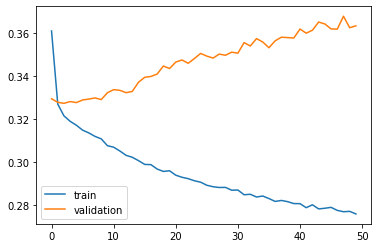

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.08035837656278505
Dropout rate 2: 0.2096251351295531
Fold: 3
Best val loss: 0.32747227409150864
#################################
Time to train MLP:  368.8223931789398
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 28s - loss: 0.3605 - acc: 0.8662 - val_loss: 0.3249 - val_acc: 0.8770

Epoch 00001: val_loss improved from inf to 0.32490, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3298 - acc: 0.8757 - val_loss: 0.3236 - val_acc: 0.8781

Epoch 00002: val_loss improved from 0.32490 to 0.32362, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3231 - acc: 0.8764 - val_loss: 0.3231 - val_acc: 0.8773

Epoch 00003: val_loss improved from 0.32362 to 0.32309, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3195 - acc: 0.8774 - val_loss: 0.3225 - val_acc: 0.8780

Epoch 00004: val_loss improved from 0.32309 to 0.32248, saving model to MLP_val_weig

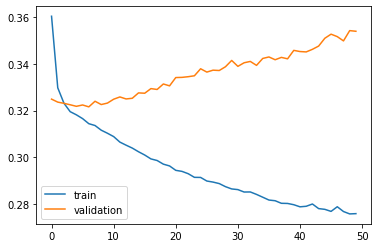

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.08035837656278505
Dropout rate 2: 0.2096251351295531
Fold: 4
Best val loss: 0.32158150378863015
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414


Epoch 00003: val_loss improved from 0.32810 to 0.32200, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3268 - acc: 0.8755 - val_loss: 0.3181 - val_acc: 0.8773

Epoch 00004: val_loss improved from 0.32200 to 0.31815, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3241 - acc: 0.8761 - val_loss: 0.3184 - val_acc: 0.8778

Epoch 00005: val_loss did not improve from 0.31815
Epoch 6/50
 - 7s - loss: 0.3238 - acc: 0.8759 - val_loss: 0.3181 - val_acc: 0.8780

Epoch 00006: val_loss improved from 0.31815 to 0.31813, saving model to MLP_val_weights.hdf5
Epoch 7/50
 - 7s - loss: 0.3233 - acc: 0.8765 - val_loss: 0.3174 - val_acc: 0.8780

Epoch 00007: val_loss improved from 0.31813 to 0.31743, saving model to MLP_val_weights.hdf5
Epoch 8/50
 - 7s - loss: 0.3210 - acc: 0.8773 - val_loss: 0.3190 - val_acc: 0.8790

Epoch 00008: val_loss did not improve from 0.31743
Epoch 9/50
 - 7s - loss: 0.3214 - acc: 0.8773 - val_loss: 0.3167 - val_acc: 0.8801

Epoch 00009: val_loss

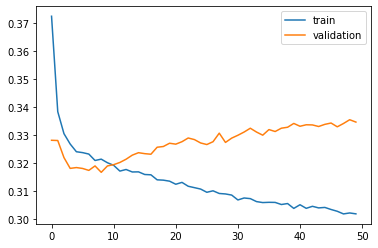

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.3822802251694394
Dropout rate 2: 0.21202622327549936
Fold: 0
Best val loss: 0.3167485135926141
#################################
Time to train MLP:  371.1559867858887
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 28s - loss: 0.3947 - acc: 0.8632 - val_loss: 0.3335 - val_acc: 0.8749

Epoch 00001: val_loss improved from inf to 0.33345, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3415 - acc: 0.8746 - val_loss: 0.3298 - val_acc: 0.8753

Epoch 00002: val_loss improved from 0.33345 to 0.32979, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3305 - acc: 0.8760 - val_loss: 0.3267 - val_acc: 0.8763

Epoch 00003: val_loss improved from 0.32979 to 0.32673, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3262 - acc: 0.8772 - val_loss: 0.3244 - val_acc: 0.8758

Epoch 00004: val_loss improved from 0.32673 to 0.32444, saving model to MLP_val_weigh

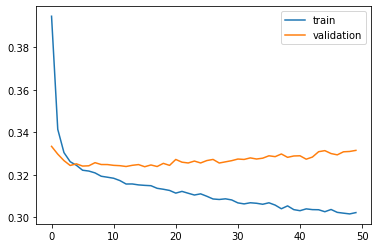

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.3822802251694394
Dropout rate 2: 0.21202622327549936
Fold: 1
Best val loss: 0.3238530765109592
#################################
Time to train MLP:  371.74521350860596
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 32s - loss: 0.3646 - acc: 0.8695 - val_loss: 0.3324 - val_acc: 0.8722

Epoch 00001: val_loss improved from inf to 0.33237, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3304 - acc: 0.8750 - val_loss: 0.3296 - val_acc: 0.8723

Epoch 00002: val_loss improved from 0.33237 to 0.32963, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3266 - acc: 0.8754 - val_loss: 0.3321 - val_acc: 0.8747

Epoch 00003: val_loss did not improve from 0.32963
Epoch 4/50
 - 7s - loss: 0.3242 - acc: 0.8761 - val_loss: 0.3289 - val_acc: 0.8748

Epoch 00004: val_loss improved from 0.32963 to 0.32889, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3220 -

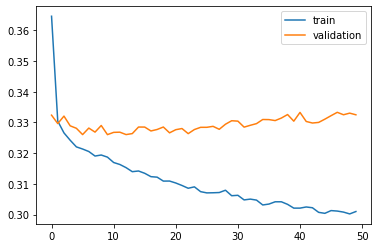

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.3822802251694394
Dropout rate 2: 0.21202622327549936
Fold: 2
Best val loss: 0.326025791115231
#################################
Time to train MLP:  373.51126861572266
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 47s - loss: 0.3824 - acc: 0.8650 - val_loss: 0.3408 - val_acc: 0.8662

Epoch 00001: val_loss improved from inf to 0.34081, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3393 - acc: 0.8736 - val_loss: 0.3341 - val_acc: 0.8688

Epoch 00002: val_loss improved from 0.34081 to 0.33411, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3300 - acc: 0.8753 - val_loss: 0.3308 - val_acc: 0.8689

Epoch 00003: val_loss improved from 0.33411 to 0.33079, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3291 - acc: 0.8758 - val_loss: 0.3292 - val_acc: 0.8703

Epoch 00004: val_loss improved from 0.33079 to 0.32921, saving model to MLP_val_weigh

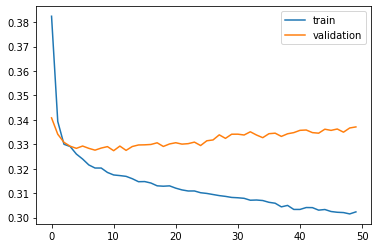

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.3822802251694394
Dropout rate 2: 0.21202622327549936
Fold: 3
Best val loss: 0.3273803888161977
#################################
Time to train MLP:  393.1211678981781
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 32s - loss: 0.3963 - acc: 0.8596 - val_loss: 0.3310 - val_acc: 0.8740

Epoch 00001: val_loss improved from inf to 0.33097, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3413 - acc: 0.8739 - val_loss: 0.3230 - val_acc: 0.8767

Epoch 00002: val_loss improved from 0.33097 to 0.32301, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3317 - acc: 0.8747 - val_loss: 0.3224 - val_acc: 0.8763

Epoch 00003: val_loss improved from 0.32301 to 0.32241, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3287 - acc: 0.8757 - val_loss: 0.3229 - val_acc: 0.8757

Epoch 00004: val_loss did not improve from 0.32241
Epoch 5/50
 - 7s - loss: 0.3244 - 

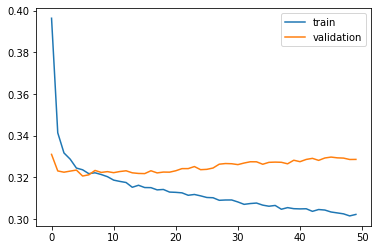

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.3822802251694394
Dropout rate 2: 0.21202622327549936
Fold: 4
Best val loss: 0.32057349064615037
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414


Epoch 00001: val_loss improved from inf to 0.32303, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3282 - acc: 0.8768 - val_loss: 0.3189 - val_acc: 0.8794

Epoch 00002: val_loss improved from 0.32303 to 0.31886, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3219 - acc: 0.8775 - val_loss: 0.3181 - val_acc: 0.8811

Epoch 00003: val_loss improved from 0.31886 to 0.31812, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3197 - acc: 0.8777 - val_loss: 0.3161 - val_acc: 0.8801

Epoch 00004: val_loss improved from 0.31812 to 0.31613, saving model to MLP_val_weights.hdf5
Epoch 5/50
 - 7s - loss: 0.3171 - acc: 0.8789 - val_loss: 0.3222 - val_acc: 0.8807

Epoch 00005: val_loss did not improve from 0.31613
Epoch 6/50
 - 7s - loss: 0.3156 - acc: 0.8797 - val_loss: 0.3233 - val_acc: 0.8824

Epoch 00006: val_loss did not improve from 0.31613
Epoch 7/50
 - 7s - loss: 0.3128 - acc: 0.8802 - val_loss: 0.3272 - val_acc: 0.8811

Epoch 00007: val_loss did

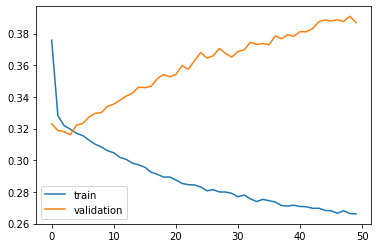

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.010404898976033083
Dropout rate 2: 0.23157443486367296
Fold: 0
Best val loss: 0.31613192812601726
#################################
Time to train MLP:  412.7860839366913
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 58s - loss: 0.3562 - acc: 0.8662 - val_loss: 0.3286 - val_acc: 0.8742

Epoch 00001: val_loss improved from inf to 0.32858, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3261 - acc: 0.8767 - val_loss: 0.3257 - val_acc: 0.8756

Epoch 00002: val_loss improved from 0.32858 to 0.32567, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3205 - acc: 0.8775 - val_loss: 0.3248 - val_acc: 0.8762

Epoch 00003: val_loss improved from 0.32567 to 0.32478, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3176 - acc: 0.8783 - val_loss: 0.3247 - val_acc: 0.8762

Epoch 00004: val_loss improved from 0.32478 to 0.32471, saving model to MLP_val_we

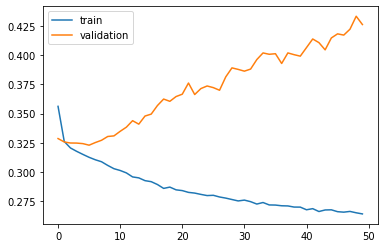

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.010404898976033083
Dropout rate 2: 0.23157443486367296
Fold: 1
Best val loss: 0.3229132130146027
#################################
Time to train MLP:  409.0764226913452
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 32s - loss: 0.3601 - acc: 0.8666 - val_loss: 0.3268 - val_acc: 0.8753

Epoch 00001: val_loss improved from inf to 0.32681, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3262 - acc: 0.8757 - val_loss: 0.3253 - val_acc: 0.8767

Epoch 00002: val_loss improved from 0.32681 to 0.32527, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3209 - acc: 0.8771 - val_loss: 0.3243 - val_acc: 0.8767

Epoch 00003: val_loss improved from 0.32527 to 0.32433, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3184 - acc: 0.8778 - val_loss: 0.3278 - val_acc: 0.8762

Epoch 00004: val_loss did not improve from 0.32433
Epoch 5/50
 - 7s - loss: 0.3166 

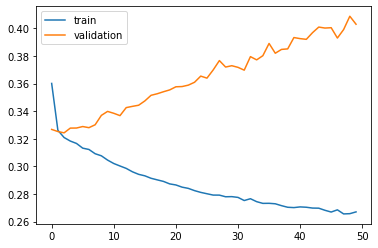

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.010404898976033083
Dropout rate 2: 0.23157443486367296
Fold: 2
Best val loss: 0.3243279708756341
#################################
Time to train MLP:  386.6239380836487
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 52s - loss: 0.3550 - acc: 0.8701 - val_loss: 0.3305 - val_acc: 0.8697

Epoch 00001: val_loss improved from inf to 0.33051, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3267 - acc: 0.8767 - val_loss: 0.3263 - val_acc: 0.8720

Epoch 00002: val_loss improved from 0.33051 to 0.32633, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3193 - acc: 0.8781 - val_loss: 0.3266 - val_acc: 0.8710

Epoch 00003: val_loss did not improve from 0.32633
Epoch 4/50
 - 7s - loss: 0.3170 - acc: 0.8786 - val_loss: 0.3277 - val_acc: 0.8712

Epoch 00004: val_loss did not improve from 0.32633
Epoch 5/50
 - 7s - loss: 0.3144 - acc: 0.8799 - val_loss: 0.3292 - val_acc

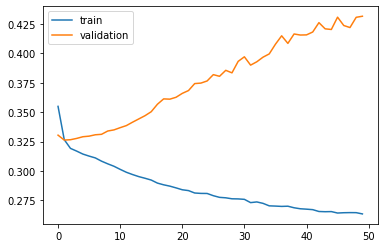

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.010404898976033083
Dropout rate 2: 0.23157443486367296
Fold: 3
Best val loss: 0.326334117465549
#################################
Time to train MLP:  407.0838930606842
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 33s - loss: 0.3515 - acc: 0.8689 - val_loss: 0.3253 - val_acc: 0.8766

Epoch 00001: val_loss improved from inf to 0.32534, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3253 - acc: 0.8766 - val_loss: 0.3200 - val_acc: 0.8784

Epoch 00002: val_loss improved from 0.32534 to 0.32003, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3196 - acc: 0.8778 - val_loss: 0.3199 - val_acc: 0.8782

Epoch 00003: val_loss improved from 0.32003 to 0.31991, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3170 - acc: 0.8785 - val_loss: 0.3211 - val_acc: 0.8777

Epoch 00004: val_loss did not improve from 0.31991
Epoch 5/50
 - 7s - loss: 0.3153 -

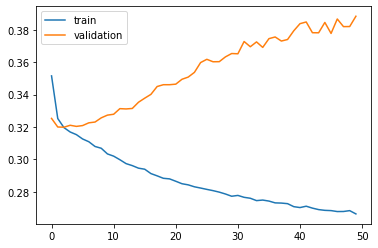

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.010404898976033083
Dropout rate 2: 0.23157443486367296
Fold: 4
Best val loss: 0.319906196170383
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414

Time to train MLP:  391.1884055137634
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 38s - loss: 0.3571 - acc: 0.8667 - val_loss: 0.3210 - val_acc: 0.8769

Epoch 00001: val_loss improved from inf to 0.32097, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3274 - acc: 0.8755 - val_loss: 0.3174 - val_acc: 0.8796

Epoch 00002: val_loss improved from 0.32097 to 0.31740, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3213 - acc: 0.8770 - val_loss: 0.3168 - val_acc: 0.8807

Epoch 00003: val_loss improved from 0.31740 to 0.31683, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3179 - acc: 0.8781 - val_loss: 0.3176 - val_acc: 0.8797

Epoch 00004: val_loss did not improve from 0.31683
Epoch 5/50
 - 7s - loss: 0.3163 - acc: 0.8785 - val_loss: 0.3178 - val_acc: 0.8821

Epoch 00005: val_loss did not improve from 0.31683
Epoch 6/50
 - 7s - loss: 0.3141 - acc: 0.8796 - val_loss: 0.3207 - val_acc: 0.8821

Epoch 00006: val_loss did not i

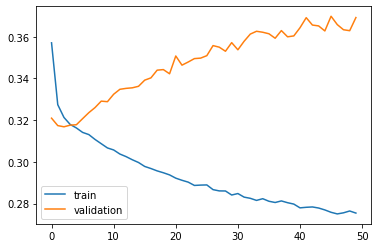

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.06760508918455843
Dropout rate 2: 0.18686157441195766
Fold: 0
Best val loss: 0.3168250073591868
#################################
Time to train MLP:  401.6822466850281
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 32s - loss: 0.3612 - acc: 0.8681 - val_loss: 0.3303 - val_acc: 0.8722

Epoch 00001: val_loss improved from inf to 0.33026, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3256 - acc: 0.8769 - val_loss: 0.3279 - val_acc: 0.8727

Epoch 00002: val_loss improved from 0.33026 to 0.32794, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 7s - loss: 0.3205 - acc: 0.8780 - val_loss: 0.3250 - val_acc: 0.8752

Epoch 00003: val_loss improved from 0.32794 to 0.32503, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 7s - loss: 0.3171 - acc: 0.8793 - val_loss: 0.3251 - val_acc: 0.8743

Epoch 00004: val_loss did not improve from 0.32503
Epoch 5/50
 - 7s - loss: 0.3155 -

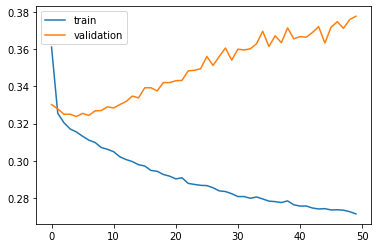

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.06760508918455843
Dropout rate 2: 0.18686157441195766
Fold: 1
Best val loss: 0.3238159776793586
#################################
Time to train MLP:  404.15676259994507
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 33s - loss: 0.3632 - acc: 0.8674 - val_loss: 0.3320 - val_acc: 0.8742

Epoch 00001: val_loss improved from inf to 0.33200, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 8s - loss: 0.3288 - acc: 0.8761 - val_loss: 0.3310 - val_acc: 0.8756

Epoch 00002: val_loss improved from 0.33200 to 0.33095, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3214 - acc: 0.8770 - val_loss: 0.3252 - val_acc: 0.8766

Epoch 00003: val_loss improved from 0.33095 to 0.32518, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 8s - loss: 0.3175 - acc: 0.8787 - val_loss: 0.3255 - val_acc: 0.8777

Epoch 00004: val_loss did not improve from 0.32518
Epoch 5/50
 - 8s - loss: 0.3156 

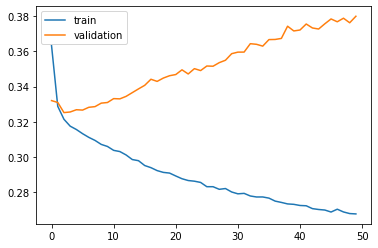

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.06760508918455843
Dropout rate 2: 0.18686157441195766
Fold: 2
Best val loss: 0.3251833142704434
#################################
Time to train MLP:  410.0999665260315
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 36s - loss: 0.3490 - acc: 0.8706 - val_loss: 0.3298 - val_acc: 0.8707

Epoch 00001: val_loss improved from inf to 0.32981, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 8s - loss: 0.3245 - acc: 0.8767 - val_loss: 0.3274 - val_acc: 0.8714

Epoch 00002: val_loss improved from 0.32981 to 0.32742, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3188 - acc: 0.8788 - val_loss: 0.3281 - val_acc: 0.8713

Epoch 00003: val_loss did not improve from 0.32742
Epoch 4/50
 - 8s - loss: 0.3169 - acc: 0.8798 - val_loss: 0.3291 - val_acc: 0.8702

Epoch 00004: val_loss did not improve from 0.32742
Epoch 5/50
 - 7s - loss: 0.3143 - acc: 0.8803 - val_loss: 0.3289 - val_acc:

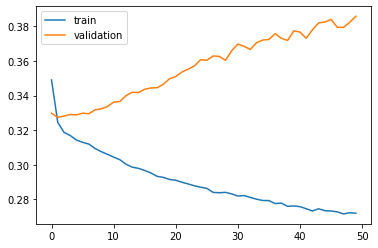

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.06760508918455843
Dropout rate 2: 0.18686157441195766
Fold: 3
Best val loss: 0.32742322749561736
#################################
Time to train MLP:  413.4617729187012
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 34s - loss: 0.3562 - acc: 0.8659 - val_loss: 0.3288 - val_acc: 0.8734

Epoch 00001: val_loss improved from inf to 0.32880, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 8s - loss: 0.3303 - acc: 0.8722 - val_loss: 0.3269 - val_acc: 0.8736

Epoch 00002: val_loss improved from 0.32880 to 0.32686, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3254 - acc: 0.8734 - val_loss: 0.3216 - val_acc: 0.8763

Epoch 00003: val_loss improved from 0.32686 to 0.32159, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 8s - loss: 0.3196 - acc: 0.8763 - val_loss: 0.3207 - val_acc: 0.8772

Epoch 00004: val_loss improved from 0.32159 to 0.32068, saving model to MLP_val_wei

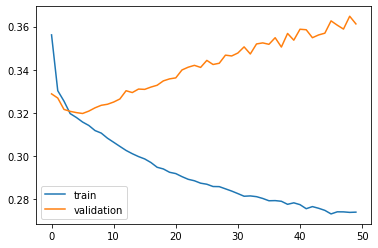

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.06760508918455843
Dropout rate 2: 0.18686157441195766
Fold: 4
Best val loss: 0.3196977679994371
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414

Time to train MLP:  411.73561906814575
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 35s - loss: 0.3497 - acc: 0.8719 - val_loss: 0.3201 - val_acc: 0.8784

Epoch 00001: val_loss improved from inf to 0.32006, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 8s - loss: 0.3266 - acc: 0.8761 - val_loss: 0.3182 - val_acc: 0.8809

Epoch 00002: val_loss improved from 0.32006 to 0.31816, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3213 - acc: 0.8768 - val_loss: 0.3198 - val_acc: 0.8813

Epoch 00003: val_loss did not improve from 0.31816
Epoch 4/50
 - 8s - loss: 0.3190 - acc: 0.8773 - val_loss: 0.3201 - val_acc: 0.8814

Epoch 00004: val_loss did not improve from 0.31816
Epoch 5/50
 - 8s - loss: 0.3163 - acc: 0.8785 - val_loss: 0.3234 - val_acc: 0.8812

Epoch 00005: val_loss did not improve from 0.31816
Epoch 6/50
 - 8s - loss: 0.3147 - acc: 0.8787 - val_loss: 0.3262 - val_acc: 0.8822

Epoch 00006: val_loss did not improve from 0.31816
Epoch 7/50
 - 8s - lo

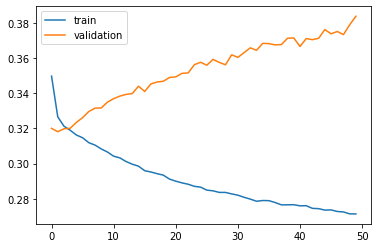

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.05813650870084491
Dropout rate 2: 0.2327540500862555
Fold: 0
Best val loss: 0.31815503901905484
#################################
Time to train MLP:  414.78489875793457
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 34s - loss: 0.3525 - acc: 0.8716 - val_loss: 0.3297 - val_acc: 0.8748

Epoch 00001: val_loss improved from inf to 0.32972, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 8s - loss: 0.3257 - acc: 0.8768 - val_loss: 0.3268 - val_acc: 0.8736

Epoch 00002: val_loss improved from 0.32972 to 0.32684, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3208 - acc: 0.8777 - val_loss: 0.3261 - val_acc: 0.8756

Epoch 00003: val_loss improved from 0.32684 to 0.32611, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 8s - loss: 0.3178 - acc: 0.8789 - val_loss: 0.3255 - val_acc: 0.8744

Epoch 00004: val_loss improved from 0.32611 to 0.32550, saving model to MLP_val_wei

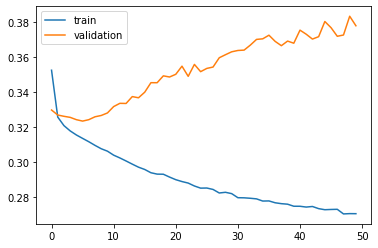

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.05813650870084491
Dropout rate 2: 0.2327540500862555
Fold: 1
Best val loss: 0.32336770073572796
#################################
Time to train MLP:  416.3965640068054
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 34s - loss: 0.3605 - acc: 0.8661 - val_loss: 0.3303 - val_acc: 0.8737

Epoch 00001: val_loss improved from inf to 0.33030, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 7s - loss: 0.3277 - acc: 0.8762 - val_loss: 0.3286 - val_acc: 0.8770

Epoch 00002: val_loss improved from 0.33030 to 0.32855, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3213 - acc: 0.8767 - val_loss: 0.3255 - val_acc: 0.8763

Epoch 00003: val_loss improved from 0.32855 to 0.32553, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 8s - loss: 0.3186 - acc: 0.8780 - val_loss: 0.3257 - val_acc: 0.8761

Epoch 00004: val_loss did not improve from 0.32553
Epoch 5/50
 - 8s - loss: 0.3167 -

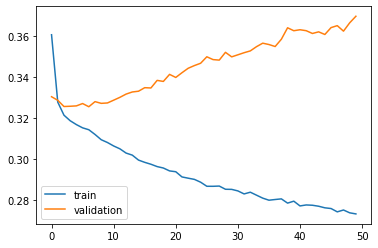

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.05813650870084491
Dropout rate 2: 0.2327540500862555
Fold: 2
Best val loss: 0.3254206893179152
#################################
Time to train MLP:  412.14687728881836
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 35s - loss: 0.3471 - acc: 0.8715 - val_loss: 0.3282 - val_acc: 0.8713

Epoch 00001: val_loss improved from inf to 0.32823, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 8s - loss: 0.3226 - acc: 0.8775 - val_loss: 0.3269 - val_acc: 0.8714

Epoch 00002: val_loss improved from 0.32823 to 0.32690, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3187 - acc: 0.8787 - val_loss: 0.3260 - val_acc: 0.8709

Epoch 00003: val_loss improved from 0.32690 to 0.32595, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 8s - loss: 0.3158 - acc: 0.8793 - val_loss: 0.3265 - val_acc: 0.8713

Epoch 00004: val_loss did not improve from 0.32595
Epoch 5/50
 - 8s - loss: 0.3140 -

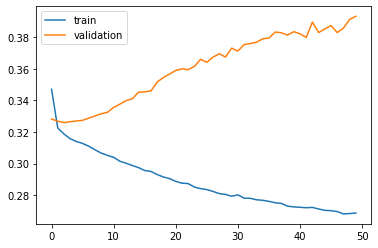

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.05813650870084491
Dropout rate 2: 0.2327540500862555
Fold: 3
Best val loss: 0.3259549663596683
#################################
Time to train MLP:  425.97247290611267
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 35s - loss: 0.3782 - acc: 0.8590 - val_loss: 0.3284 - val_acc: 0.8776

Epoch 00001: val_loss improved from inf to 0.32841, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 8s - loss: 0.3293 - acc: 0.8750 - val_loss: 0.3234 - val_acc: 0.8771

Epoch 00002: val_loss improved from 0.32841 to 0.32345, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3227 - acc: 0.8769 - val_loss: 0.3216 - val_acc: 0.8767

Epoch 00003: val_loss improved from 0.32345 to 0.32165, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 8s - loss: 0.3194 - acc: 0.8777 - val_loss: 0.3217 - val_acc: 0.8770

Epoch 00004: val_loss did not improve from 0.32165
Epoch 5/50
 - 8s - loss: 0.3172 -

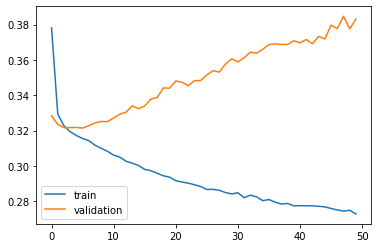

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.05813650870084491
Dropout rate 2: 0.2327540500862555
Fold: 4
Best val loss: 0.3214009379810757
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.408084149

Time to train MLP:  419.4193375110626


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f64083bd898>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f64083bddd8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File

Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 37s - loss: 0.3448 - acc: 0.8713 - val_loss: 0.3193 - val_acc: 0.8794

Epoch 00001: val_loss improved from inf to 0.31928, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 8s - loss: 0.3250 - acc: 0.8758 - val_loss: 0.3181 - val_acc: 0.8791

Epoch 00002: val_loss improved from 0.31928 to 0.31809, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3207 - acc: 0.8769 - val_loss: 0.3178 - val_acc: 0.8809

Epoch 00003: val_loss improved from 0.31809 to 0.31775, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 8s - loss: 0.3174 - acc: 0.8786 - val_loss: 0.3185 - val_acc: 0.8796

Epoch 00004: val_loss did not improve from 0.31775
Epoch 5/50
 - 8s - loss: 0.3153 - acc: 0.8789 - val_loss: 0.3184 - val_acc: 0.8801

Epoch 00005: val_loss did not improve from 0.31775
Epoch 6/50
 - 8s - loss: 0.3137 - acc: 0.8800 - val_loss: 0.3220 - val_acc: 0.8801

Epoch 00006: val_loss did not improve from 0.31775
Epoch 7/50
 - 8s -

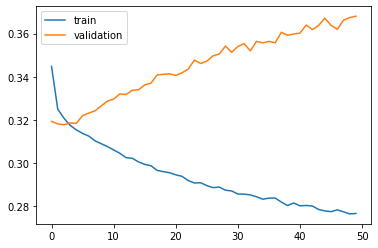

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.15494879224501462
Dropout rate 2: 0.01758413073540238
Fold: 0
Best val loss: 0.3177528760168287
#################################
Time to train MLP:  431.98325061798096
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 37s - loss: 0.3818 - acc: 0.8563 - val_loss: 0.3305 - val_acc: 0.8729

Epoch 00001: val_loss improved from inf to 0.33052, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 8s - loss: 0.3253 - acc: 0.8765 - val_loss: 0.3278 - val_acc: 0.8746

Epoch 00002: val_loss improved from 0.33052 to 0.32785, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3208 - acc: 0.8782 - val_loss: 0.3272 - val_acc: 0.8737

Epoch 00003: val_loss improved from 0.32785 to 0.32724, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 8s - loss: 0.3171 - acc: 0.8789 - val_loss: 0.3268 - val_acc: 0.8739

Epoch 00004: val_loss improved from 0.32724 to 0.32685, saving model to MLP_val_wei

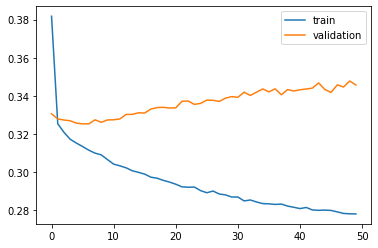

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.15494879224501462
Dropout rate 2: 0.01758413073540238
Fold: 1
Best val loss: 0.32522112645043266
#################################
Time to train MLP:  424.85104489326477
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 37s - loss: 0.3478 - acc: 0.8679 - val_loss: 0.3284 - val_acc: 0.8752

Epoch 00001: val_loss improved from inf to 0.32837, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 8s - loss: 0.3235 - acc: 0.8765 - val_loss: 0.3267 - val_acc: 0.8760

Epoch 00002: val_loss improved from 0.32837 to 0.32673, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3183 - acc: 0.8775 - val_loss: 0.3254 - val_acc: 0.8762

Epoch 00003: val_loss improved from 0.32673 to 0.32538, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 8s - loss: 0.3159 - acc: 0.8786 - val_loss: 0.3265 - val_acc: 0.8762

Epoch 00004: val_loss did not improve from 0.32538
Epoch 5/50
 - 8s - loss: 0.3139

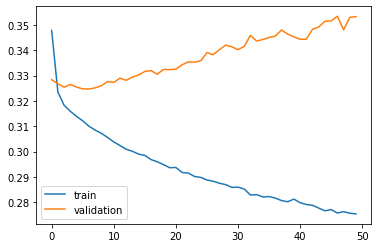

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.15494879224501462
Dropout rate 2: 0.01758413073540238
Fold: 2
Best val loss: 0.32468229042159186
#################################
Time to train MLP:  436.252703666687
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 40s - loss: 0.3407 - acc: 0.8728 - val_loss: 0.3305 - val_acc: 0.8688

Epoch 00001: val_loss improved from inf to 0.33049, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 8s - loss: 0.3233 - acc: 0.8769 - val_loss: 0.3274 - val_acc: 0.8719

Epoch 00002: val_loss improved from 0.33049 to 0.32742, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3184 - acc: 0.8787 - val_loss: 0.3276 - val_acc: 0.8719

Epoch 00003: val_loss did not improve from 0.32742
Epoch 4/50
 - 8s - loss: 0.3145 - acc: 0.8796 - val_loss: 0.3292 - val_acc: 0.8718

Epoch 00004: val_loss did not improve from 0.32742
Epoch 5/50
 - 8s - loss: 0.3131 - acc: 0.8799 - val_loss: 0.3281 - val_acc:

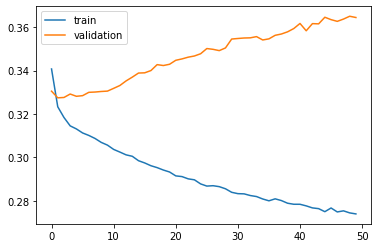

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.15494879224501462
Dropout rate 2: 0.01758413073540238
Fold: 3
Best val loss: 0.3274249967734019
#################################
Time to train MLP:  442.4045081138611
Train on 81000 samples, validate on 9000 samples
Epoch 1/50
 - 36s - loss: 0.3397 - acc: 0.8739 - val_loss: 0.3223 - val_acc: 0.8770

Epoch 00001: val_loss improved from inf to 0.32235, saving model to MLP_val_weights.hdf5
Epoch 2/50
 - 8s - loss: 0.3219 - acc: 0.8768 - val_loss: 0.3209 - val_acc: 0.8760

Epoch 00002: val_loss improved from 0.32235 to 0.32093, saving model to MLP_val_weights.hdf5
Epoch 3/50
 - 8s - loss: 0.3189 - acc: 0.8778 - val_loss: 0.3205 - val_acc: 0.8783

Epoch 00003: val_loss improved from 0.32093 to 0.32048, saving model to MLP_val_weights.hdf5
Epoch 4/50
 - 9s - loss: 0.3150 - acc: 0.8788 - val_loss: 0.3206 - val_acc: 0.8780

Epoch 00004: val_loss did not improve from 0.32048
Epoch 5/50
 - 8s - loss: 0.3127 -

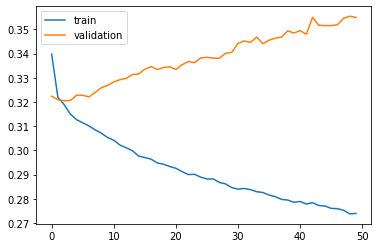

#################################
Number of units: 16
Batch size: 64
Dropout rate 1: 0.15494879224501462
Dropout rate 2: 0.01758413073540238
Fold: 4
Best val loss: 0.3204754455619388
#################################
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414

Time to train MLP:  434.2054591178894
Entire process took:  36289.2475669384
Experiment record:
[[16, 64, 0.07708142118983619, 0.3357263226060013, 0, 0.3173180478678809], [16, 64, 0.07708142118983619, 0.3357263226060013, 1, 0.3224948298666212], [16, 64, 0.07708142118983619, 0.3357263226060013, 2, 0.3268813591533237], [16, 64, 0.07708142118983619, 0.3357263226060013, 3, 0.3260361191696591], [16, 64, 0.07708142118983619, 0.3357263226060013, 4, 0.3193798927201165], [16, 64, 0.3700248482577024, 0.23561488912500705, 0, 0.3178065161969927], [16, 64, 0.3700248482577024, 0.23561488912500705, 1, 0.32310840423901876], [16, 64, 0.3700248482577024, 0.23561488912500705, 2, 0.3251951296594408], [16, 64, 0.3700248482577024, 0.23561488912500705, 3, 0.3300845676528083], [16, 64, 0.3700248482577024, 0.23561488912500705, 4, 0.32121809917026095], [16, 64, 0.13165750759256734, 0.40808414902301343, 0, 0.3169564678139157], [16, 64, 0.13165750759256734, 0.40808414902301343, 1, 0.32326197327507866], [16, 64, 0

In [13]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


num_per_fold = x_train.shape[0]//10
print(num_per_fold)

start_time = time.time()

n_units = 16
b_size = 64

exp_record = []

for i in range(25):
    dropout_rate_1 = dropout_rate_1_list[i]
    dropout_rate_2 = dropout_rate_2_list[i]

    for f in range(5):#10
        #start = f*num_per_fold
        end = (f+1)*num_per_fold
        train1_x = x_train[:end, ]
        train2_x = x_train[end:, ]
        train_x_mlp = np.append(train2_x, train1_x, axis=0) #new obj
        train1_y = y_train[:end, ]
        train2_y = y_train[end:, ]
        train_y_mlp = np.append(train2_y, train1_y, axis=0)

        start_time_inner = time.time()
        with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
            model = set_up_model(n_units, 
                                 dropout_rate_1, 
                                 dropout_rate_2)
            v_loss = fit_model(model, train_x_mlp, 
                               train_y_mlp, b_size)
            print("#################################")
            print("Number of units:", n_units)
            print("Batch size:", b_size)
            print("Dropout rate 1:", dropout_rate_1)
            print("Dropout rate 2:", dropout_rate_2)
            print("Fold:", f)
            print("Best val loss:", v_loss)
            exp_record.append([n_units, b_size, 
                               dropout_rate_1, 
                               dropout_rate_2, 
                               f, v_loss])
            print("#################################")
            if(f==4):
                print(exp_record)
        print("Time to train MLP: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [14]:
complete_v = np.array(exp_record)
print(complete_v.shape)

val_loss_list = []
for i in range(25):
    model_v = complete_v[(i*5):((i+1)*5), :]
    print("#######################")
    print("Units:\t\t", model_v[0, 0])
    print("Batch size:\t", model_v[0, 1])
    print("Dropout rate 1:\t", model_v[0, 2])
    print("Dropout rate 2:\t", model_v[0, 3])
    print("Val loss (mean):", np.mean(model_v[:, 5]))
    print("Val loss (Std): ", np.std(model_v[:, 5]))
    print("#######################")
    val_loss_list.append(np.mean(model_v[:, 5]))
print(min(val_loss_list))

(125, 6)
#######################
Units:		 16.0
Batch size:	 64.0
Dropout rate 1:	 0.07708142118983619
Dropout rate 2:	 0.3357263226060013
Val loss (mean): 0.3224220497555203
Val loss (Std):  0.003694801474428801
#######################
#######################
Units:		 16.0
Batch size:	 64.0
Dropout rate 1:	 0.3700248482577024
Dropout rate 2:	 0.23561488912500705
Val loss (mean): 0.3234825433837043
Val loss (Std):  0.004098893717122994
#######################
#######################
Units:		 16.0
Batch size:	 64.0
Dropout rate 1:	 0.13165750759256734
Dropout rate 2:	 0.40808414902301343
Val loss (mean): 0.3227552592701382
Val loss (Std):  0.0033495146725755188
#######################
#######################
Units:		 16.0
Batch size:	 64.0
Dropout rate 1:	 0.26686969669014887
Dropout rate 2:	 0.14479339176527678
Val loss (mean): 0.3226597907702128
Val loss (Std):  0.003779921468622913
#######################
#######################
Units:		 16.0
Batch size:	 64.0
Dropout rate 1:	 0.00728

(125, 6)
(25, 3)


<IPython.core.display.Javascript object>


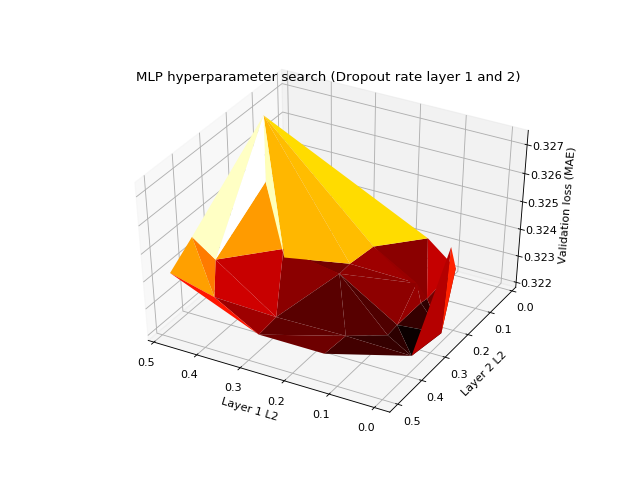

Text(0.5, 0.92, 'MLP hyperparameter search (Dropout rate layer 1 and 2)')

In [4]:
complete_v = np.array(exp_record)
print(complete_v.shape)
xyz = []
for i in range(25):#50
    fold_v = complete_v[(i*5):((i+1)*5), :]
    xyz.append([fold_v[0, 2], 
                fold_v[0, 3], 
                np.mean(fold_v[:, 5])])
xyz_v = np.array(xyz)
print(xyz_v.shape)

fig = pyplot.figure(figsize=(8, 6))
#ax = fig.add_subplot(111, projection='3d')
ax = pyplot.axes(projection='3d')
ax.set_xlabel('Layer 1 L2')
ax.set_ylabel('Layer 2 L2')
ax.set_zlabel('Validation loss (MAE)')
#ax = plt.axes(projection='3d')
#ax.plot_surface(X, Y, z, rstride=1, cstride=1,
#                cmap='winter', edgecolor='none')
ax.plot_trisurf(xyz_v[:, 0], xyz_v[:, 1], xyz_v[:, 2],
               cmap='hot', edgecolor='none')
ax.set_title('MLP hyperparameter search (Dropout rate layer 1 and 2)')